# Exploratory Data Analysis (EDA) on NVDA, INTC, and AMD

## 1. Data Collection

### Objective
To obtain comprehensive OHLC (Open, High, Low, Close) data for the semiconductor companies NVIDIA (NVDA), Intel (INTC), and Advanced Micro Devices (AMD) across multiple timeframes: daily, weekly, and monthly. This data forms the foundation for subsequent analysis, including calculating key financial metrics and building predictive models.

### Timeframes
- **Daily Data**: To capture short-term price movements and volatility.
- **Weekly Data**: To smooth out noise and capture medium-term trends.
- **Monthly Data**: To understand long-term trends and investment performance.

### Data Sources
- **Primary Source**: Yahoo Finance API. Selected for its reliability, comprehensiveness, and ease of access to historical stock price data.
- **Alternative Sources**: Alpha Vantage API, Quandl API, or Bloomberg Terminal (if available for institutional access).

### Data Extraction Process
1. **API Setup**: Configure API keys and authentication for Yahoo Finance and other potential data providers.
2. **Data Retrieval**:
   - **Tickers**: `NVDA`, `INTC`, `AMD`
   - **Timeframes**: Daily, weekly, and monthly
   - **Fields**: Date, Open, High, Low, Close, Volume
3. **Data Storage**:
   - Store raw data in CSV format for each ticker and timeframe.
   - Maintain separate directories for each timeframe (e.g., `/data/daily/`, `/data/weekly/`, `/data/monthly/`).
4. **Data Validation**:
   - **Integrity Checks**: Ensure no missing dates or duplicate entries.
   - **Consistency Checks**: Verify that the data retrieved matches across different sources (if using multiple APIs).
   - **Data Backup**: Implement version control for raw data files to track changes and maintain historical records.

### Tools and Libraries
- **Programming Language**: Python (selected for its extensive libraries and support in data analysis)
- **Libraries**: `yfinance`, `pandas`, `numpy`, `requests`
- **Environment**: Jupyter Notebooks for interactive analysis, with data stored in a secure, backed-up file system.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from datetime import datetime

class DataCollector:
    def __init__(self, tickers, timeframes):
        self.tickers = tickers
        self.timeframes = timeframes
        self.data_dir = Path('raw_data')
        self.setup_logging()
        self.create_directories()

    def setup_logging(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def create_directories(self):
        self.data_dir.mkdir(parents=True, exist_ok=True)

    def download_and_save_data(self, ticker, timeframe):
        try:
            end_date = datetime.now().strftime('%Y-%m-%d')
            data = yf.download(ticker, start='1900-01-01', end=end_date, interval=timeframe)
            data = data[~data.index.duplicated(keep='first')].sort_index()
            
            filename = f"{ticker}_{timeframe}.csv"
            filepath = self.data_dir / filename
            data.to_csv(filepath)
            logging.info(f"Data for {ticker} ({timeframe}) saved to {filepath}")
            
            return data
        except Exception as e:
            logging.error(f"Error downloading data for {ticker} ({timeframe}): {e}")
            return None

    def validate_data(self, data):
        if data is None:
            return False
        
        if data.isnull().sum().sum() > 0:
            logging.warning(f"Missing values detected in data")
            return False
        
        date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=data.index.inferred_freq)
        if len(date_range) != len(data):
            logging.warning(f"Inconsistent date range detected in data")
            return False
        
        return True

    def collect_and_validate_data(self):
        for ticker in self.tickers:
            for timeframe in self.timeframes:
                data = self.download_and_save_data(ticker, timeframe)
                if data is not None and self.validate_data(data):
                    logging.info(f"Data validation successful for {ticker} ({timeframe})")
                else:
                    logging.warning(f"Data validation failed for {ticker} ({timeframe})")

    def run(self):
        logging.info("Starting data collection and validation process.")
        self.collect_and_validate_data()
        logging.info("Data collection and validation complete.")

# Usage
tickers = ['NVDA', 'INTC', 'AMD']
timeframes = ['1d', '1wk', '1mo']

collector = DataCollector(tickers, timeframes)
collector.run()

# Log data for each ticker and timeframe
import pandas as pd

def log_data_summary(ticker, timeframe):
    filepath = collector.data_dir / f"{ticker}_{timeframe}.csv"
    if filepath.exists():
        data = pd.read_csv(filepath, index_col=0, parse_dates=True)
        logging.info(f"Summary for {ticker} ({timeframe}):")
        logging.info(f"  Date range: {data.index.min()} to {data.index.max()}")
        logging.info(f"  Number of records: {len(data)}")
        logging.info(f"  Columns: {', '.join(data.columns)}")
        logging.info(f"  Missing values: {data.isnull().sum().sum()}")
    else:
        logging.warning(f"No data file found for {ticker} ({timeframe})")

for ticker in tickers:
    for timeframe in timeframes:
        log_data_summary(ticker, timeframe)


## 2. Data Preprocessing and Cleaning

### Objective
To prepare the raw OHLC data for analysis by cleaning, transforming, and engineering features that are critical for financial analysis and model building.

### Steps for Data Preprocessing

#### 2.1 Handling Missing Values
- **Detection**: Identify missing values in OHLC data using `pandas.isnull()` and `pandas.DataFrame.info()`.
- **Treatment**:
  - **Forward Fill (ffill)**: For missing daily data, use the last available price to fill forward, assuming minimal daily price gaps.
  - **Drop Rows**: If large gaps exist, particularly in weekly or monthly data, remove rows with missing values to avoid skewing results.
  - **Imputation**: Use interpolation methods for non-critical missing values, ensuring no significant impact on volatility calculations.

#### 2.2 Data Transformation
- **Resampling**: Convert daily data into weekly and monthly data using `pandas.DataFrame.resample()`:
  - **Weekly Data**: Use the end-of-week prices to represent each week.
  - **Monthly Data**: Use the end-of-month prices to represent each month.
- **Adjusting for Corporate Actions**:
  - **Dividends**: Adjust prices to reflect dividend payouts using adjusted close prices.
  - **Stock Splits**: Normalize data for stock splits to maintain continuity in price movements.

#### 2.3 Feature Engineering

##### Monthly Data Metrics
1. **Percentage Returns**: Calculate monthly returns using the formula:
   \[
   \text{Monthly Return} = \frac{\text{Close}_{t} - \text{Close}_{t-1}}{\text{Close}_{t-1}}
   \]
2. **Positive Return Percentage (Pos %)**
   - Calculate the fraction of months with positive returns:
   \[
   \text{Pos \%} = \frac{\text{Number of Months with Positive Returns}}{\text{Total Number of Months}}
   \]
3. **Kelly Ratio**: Calculate the optimal fraction of capital to allocate to the stock:
   \[
   \text{Kelly Ratio} = \frac{P \times B - (1-P)}{B}
   \]
   Where \( P \) is the probability of a gain, and \( B \) is the ratio of the average gain to the average loss.
4. **Kelly Fraction**: Normalize the Kelly Ratio to maintain risk management.
5. **Tail Ratio**: Measure the ratio of the average of the largest 10% gains to the largest 10% losses:
   \[
   \text{Tail Ratio} = \frac{\text{Average of Top 10\% Gains}}{\text{Average of Top 10\% Losses}}
   \]
6. **Sharpe Ratio**: Calculate risk-adjusted returns:
   \[
   \text{Sharpe Ratio} = \frac{\text{Mean Return} - \text{Risk-Free Rate}}{\text{Standard Deviation of Returns}}
   \]
   Assume a constant risk-free rate (e.g., 2% annualized).
7. **Alpha (Alpha_SPY)**: Calculate the excess return over the S&P 500 benchmark.
8. **Sharpe Standard Deviation (Sharpe_std)**: Compute the standard deviation of the Sharpe ratio over time to gauge consistency.

##### 52-Week Data Metrics
1. **Percentage Returns**: Calculate weekly returns.
2. **Positive Return Percentage (Pos % per Week)**: Calculate the fraction of weeks with positive returns.
3. **Kelly Ratio and Kelly Fraction**: Compute on a weekly basis.
4. **Tail Ratio**: Measure weekly tail ratios.
5. **Sharpe Ratio**: Calculate weekly Sharpe ratios.
6. **Alpha (Alpha_SPY)**: Compute weekly alpha relative to the SPY.
7. **Sharpe Standard Deviation (Sharpe_std)**: Calculate the standard deviation of the weekly Sharpe ratio.

### Tools and Libraries for Preprocessing
- **Python Libraries**: `pandas` for data manipulation, `numpy` for numerical operations.
- **Jupyter Notebook Environment**: For iterative development and visualization of data cleaning steps.



In [ ]:
!pwd && cd raw_data/ && ls
!pwd && cd processed_data/ && ls

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Optional
import os
import yfinance as yf

class StockAnalyzer:
    def __init__(self, stock_symbols: List[str], spy_symbol: str = 'SPY'):
        self.stock_symbols = stock_symbols
        self.spy_symbol = spy_symbol
        self.raw_data_dir = 'raw_data'
        self.processed_data_dir = 'processed_data'
        self.stock_data = {symbol: self.load_data(symbol) for symbol in stock_symbols}
        self.spy_data = self.load_data(spy_symbol)
        for symbol in self.stock_symbols + [spy_symbol]:
            if symbol not in self.stock_data:
                self.stock_data[symbol] = self.download_data(symbol)
            self.stock_data[symbol] = self.preprocess_data(self.stock_data[symbol])

    def load_data(self, symbol: str) -> dict:
        """Load stock data from CSV files in the raw_data directory."""
        data = {}
        for period in ['1d', '1wk', '1mo']:
            file_path = os.path.join(self.raw_data_dir, f"{symbol}_{period}.csv")
            if os.path.exists(file_path):
                data[period] = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
            else:
                print(f"Warning: File not found - {file_path}")
        return data

    def download_data(self, symbol: str) -> dict:
        """Download stock data using yfinance if not available locally."""
        print(f"Downloading data for {symbol}")
        data = {}
        for period in ['1d', '1wk', '1mo']:
            df = yf.download(symbol, period="max", interval=period)
            if not df.empty:
                file_path = os.path.join(self.raw_data_dir, f"{symbol}_{period}.csv")
                df.to_csv(file_path)
                data[period] = df
            else:
                print(f"Warning: Unable to download data for {symbol} with period {period}")
        return data

    @staticmethod
    def preprocess_data(data_dict: dict) -> dict:
        """Preprocess the data: handle missing values, adjust for dividends and splits."""
        for period, df in data_dict.items():
            df = df.sort_index()  # Ensure data is sorted by date
            df = df.ffill()  # Forward fill missing values
            
            # Adjust for dividends and splits
            df['Adj Close'] = df['Close'] * df['Adj Close'] / df['Close'].shift(1)
            df['Adj Open'] = df['Open'] * df['Adj Close'] / df['Close']
            df['Adj High'] = df['High'] * df['Adj Close'] / df['Close']
            df['Adj Low'] = df['Low'] * df['Adj Close'] / df['Close']
            
            data_dict[period] = df
        return data_dict

    def calculate_returns(self, symbol: str, period: str = '1mo') -> pd.Series:
        """Calculate percentage returns for the given period."""
        if symbol not in self.stock_data or period not in self.stock_data[symbol]:
            print(f"Warning: No data available for {symbol} with period {period}")
            return pd.Series()
        data = self.stock_data[symbol][period]
        return data['Adj Close'].pct_change()

    @staticmethod
    def positive_return_percentage(returns: pd.Series) -> float:
        """Calculate the percentage of positive returns."""
        return (returns > 0).mean()

    @staticmethod
    def kelly_ratio(returns: pd.Series) -> float:
        """Calculate the Kelly Ratio."""
        p = StockAnalyzer.positive_return_percentage(returns)
        b = returns[returns > 0].mean() / abs(returns[returns < 0].mean())
        return p * b - (1 - p)

    @staticmethod
    def kelly_fraction(kelly_ratio: float, max_fraction: float = 0.5) -> float:
        """Normalize Kelly Ratio for risk management."""
        return min(kelly_ratio, max_fraction)

    @staticmethod
    def tail_ratio(returns: pd.Series) -> float:
        """Calculate the Tail Ratio."""
        threshold = returns.quantile(0.9)
        top_gains = returns[returns >= threshold]
        top_losses = returns[returns <= -threshold]
        return abs(top_gains.mean() / top_losses.mean())

    @staticmethod
    def sharpe_ratio(returns: pd.Series, risk_free_rate: float = 0.02) -> float:
        """Calculate the Sharpe Ratio."""
        excess_returns = returns - risk_free_rate / 12  # Assuming monthly returns
        return excess_returns.mean() / excess_returns.std() * np.sqrt(12)

    def alpha_spy(self, stock_returns: pd.Series, period: str) -> float:
        """Calculate Alpha relative to S&P 500."""
        spy_returns = self.calculate_returns(self.spy_symbol, period)
        if spy_returns.empty:
            print(f"Warning: Unable to calculate Alpha for period {period} due to missing SPY data")
            return np.nan
        return stock_returns.mean() - spy_returns.mean()

    @staticmethod
    def sharpe_std(returns: pd.Series, window: int = 12) -> pd.Series:
        """Calculate rolling Sharpe Ratio standard deviation."""
        rolling_sharpe = returns.rolling(window).apply(StockAnalyzer.sharpe_ratio)
        return rolling_sharpe.std()

    def calculate_metrics(self, symbol: str, period: str = '1mo') -> pd.DataFrame:
        """Calculate all metrics for the given period and symbol."""
        stock_returns = self.calculate_returns(symbol, period)
        
        if stock_returns.empty:
            print(f"Warning: Unable to calculate metrics for {symbol} with period {period}")
            return pd.DataFrame()
        
        metrics = pd.DataFrame({
            'Returns': stock_returns,
            'Pos %': self.positive_return_percentage(stock_returns),
            'Kelly Ratio': self.kelly_ratio(stock_returns),
            'Kelly Fraction': self.kelly_fraction(self.kelly_ratio(stock_returns)),
            'Tail Ratio': self.tail_ratio(stock_returns),
            'Sharpe Ratio': self.sharpe_ratio(stock_returns),
            'Alpha_SPY': self.alpha_spy(stock_returns, period),
            'Sharpe_std': self.sharpe_std(stock_returns)
        })
        
        # Fill NaN values with forward fill, then backward fill
        metrics = metrics.ffill().bfill()
        
        return metrics

    def save_processed_data(self, data: pd.DataFrame, filename: str):
        """Save processed data to the processed_data directory."""
        if not os.path.exists(self.processed_data_dir):
            os.makedirs(self.processed_data_dir)
        file_path = os.path.join(self.processed_data_dir, filename)
        data.to_csv(file_path)
        print(f"Processed data saved to {file_path}")

# Example usage
stock_symbols = ['NVDA', 'INTC', 'AMD']  # Stock symbols for NVIDIA, Intel, and AMD
analyzer = StockAnalyzer(stock_symbols)

for symbol in stock_symbols:
    monthly_metrics = analyzer.calculate_metrics(symbol, '1mo')
    weekly_metrics = analyzer.calculate_metrics(symbol, '1wk')

    if not monthly_metrics.empty:
        # print(f"\nMonthly Metrics for {symbol}:")
        # print(monthly_metrics.head())
        analyzer.save_processed_data(monthly_metrics, f"{symbol}_monthly_metrics.csv")

    if not weekly_metrics.empty:
        # print(f"\nWeekly Metrics for {symbol}:")
        # print(weekly_metrics.head())
        analyzer.save_processed_data(weekly_metrics, f"{symbol}_weekly_metrics.csv")


## 4. Forecasting and Model Building
Objective: Use the calculated features to predict future performance and build models.

### Selected Features for Modeling:

Tail Ratio: Provides insights into return distribution asymmetry.
Sharpe Ratio Last Year: Past performance metric for risk-adjusted returns.
Kurtosis: Measure of extreme returns frequency.
Skewness: Asymmetry of return distribution.
Sharpe Standard Deviation (Sharpe_std): Variability in risk-adjusted returns.
Alpha (Alpha_SPY): Measures outperformance relative to the market.
Sortino Ratio: Risk-adjusted return considering downside risk only.

### Modeling Approaches:

Regression Models: Linear regression, Lasso, Ridge for predicting future returns.
Tree-Based Models: Random Forest, Gradient Boosting for feature importance and prediction.
Time Series Models: ARIMA, LSTM for time-based forecasting.
Validation: Use cross-validation to ensure model robustness.


In [38]:
!pip install pmdarima


Correlation Analysis for NVDA_1mo


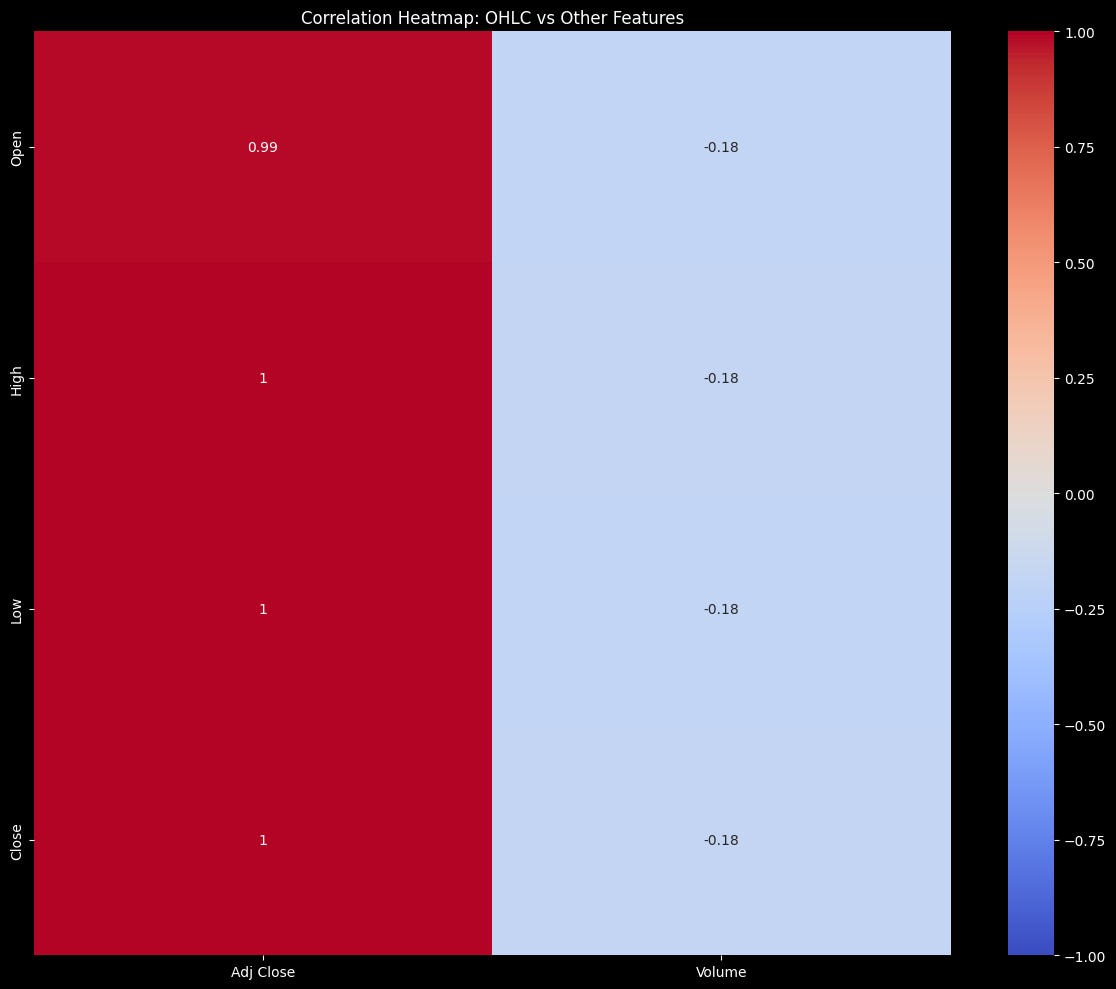


Top 5 highest absolute correlations:
Adj Close - Close: 1.0000
Adj Close - High: 0.9985
Adj Close - Low: 0.9961
Adj Close - Open: 0.9917
Volume - Low: 0.1847



Correlation Analysis for SPY_analyzed_output


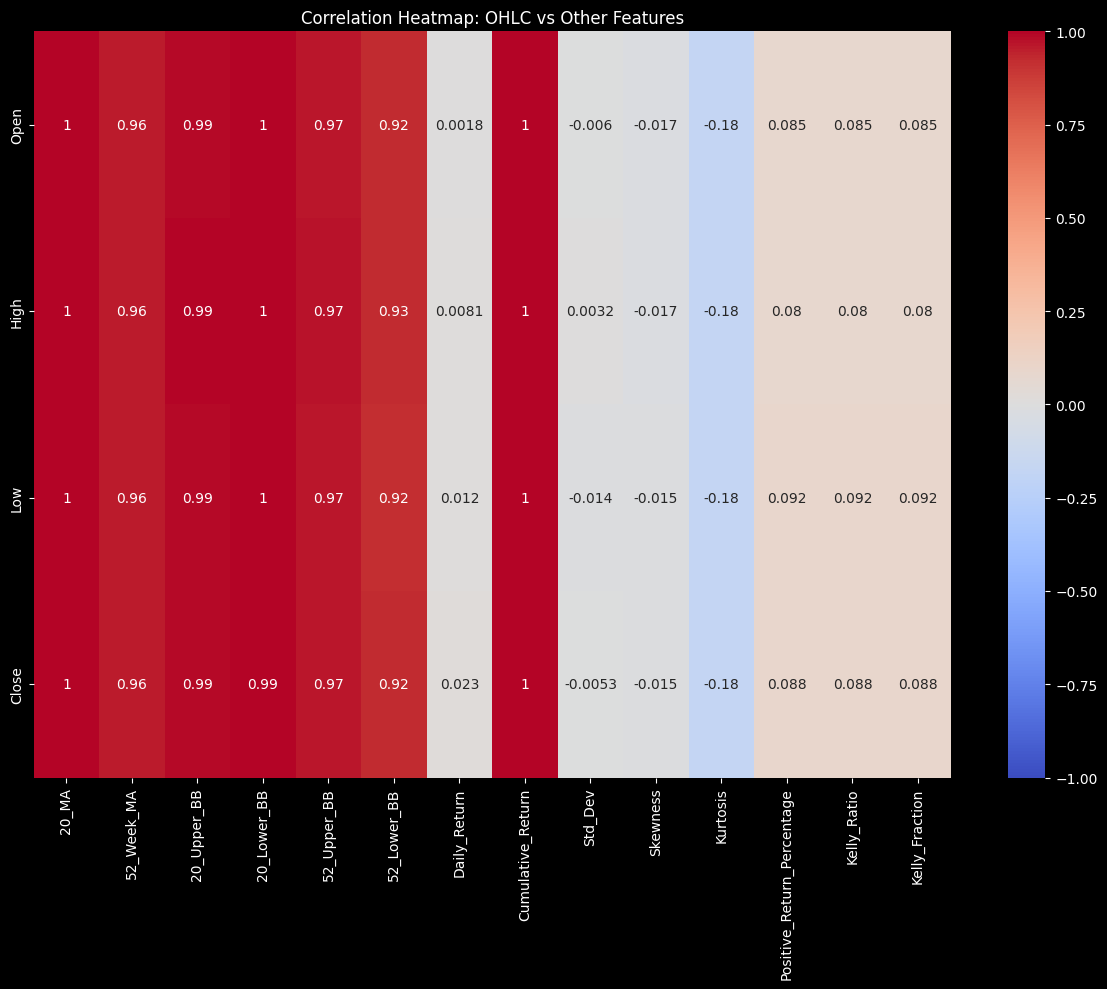


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for INTC_1mo


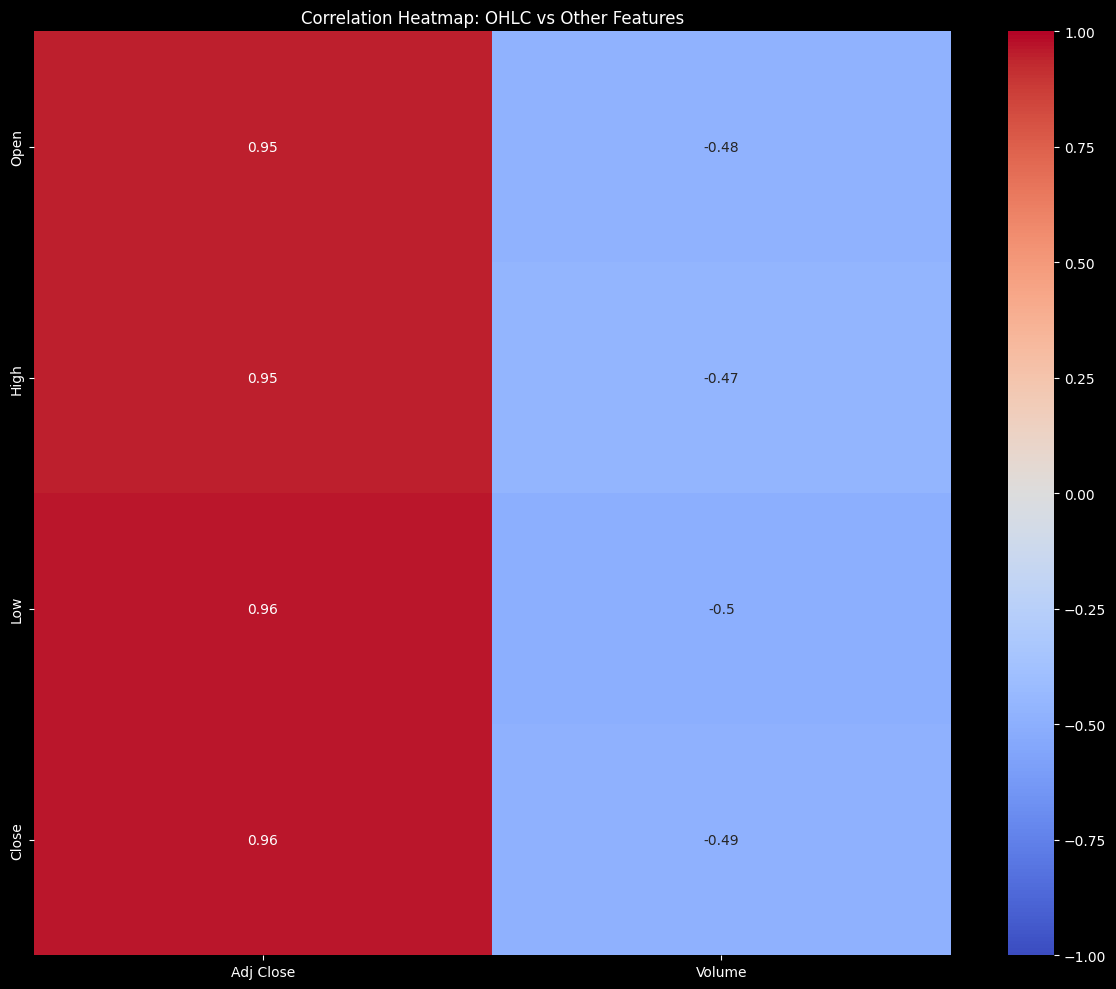


Top 5 highest absolute correlations:
Adj Close - Low: 0.9626
Adj Close - Close: 0.9612
Adj Close - High: 0.9507
Adj Close - Open: 0.9491
Volume - Low: 0.5047



Correlation Analysis for SPI_analyzed_output


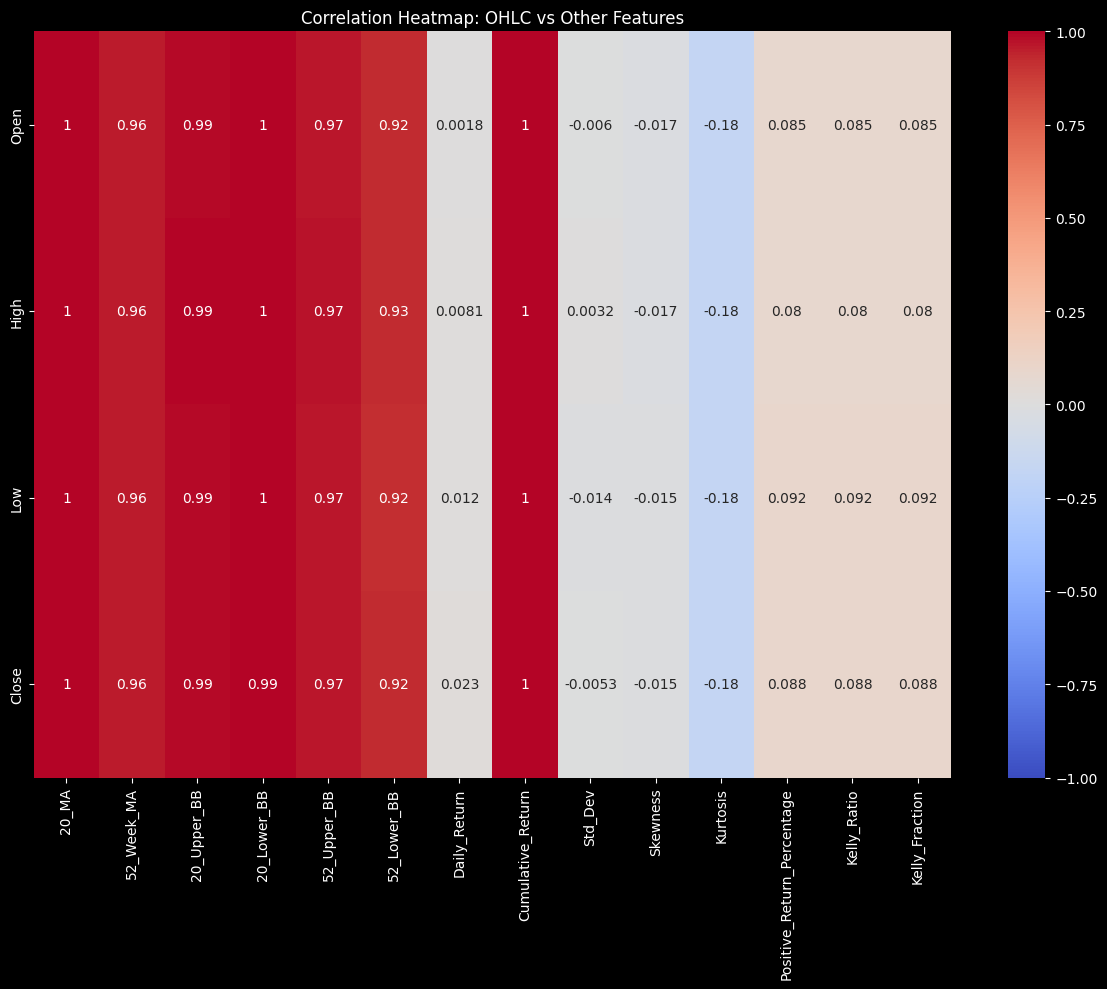


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for AMD_1mo


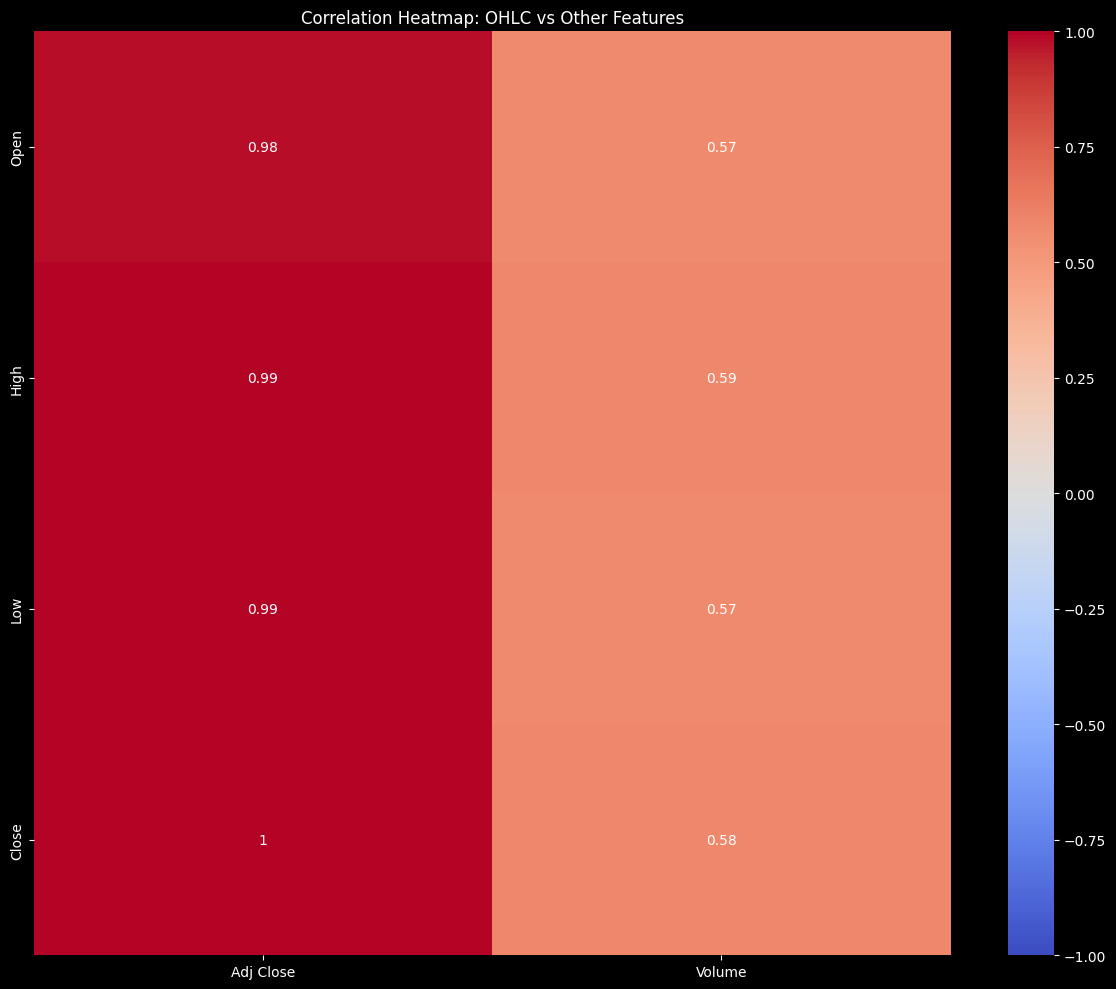


Top 5 highest absolute correlations:
Adj Close - High: 0.9945
Adj Close - Low: 0.9937
Adj Close - Open: 0.9842
Volume - High: 0.5851
Volume - Close: 0.5786



Correlation Analysis for SPXS_analyzed_output


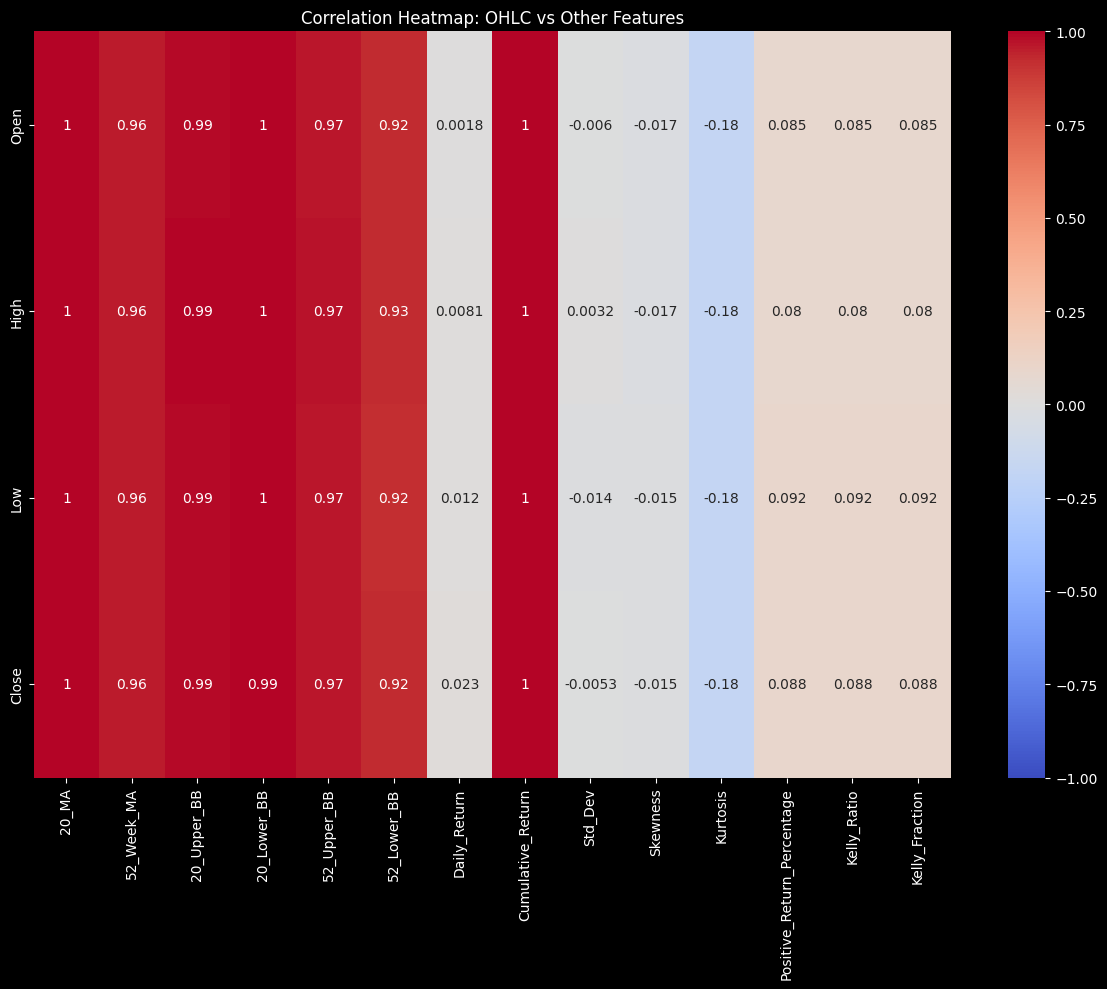


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for NVDA_1d


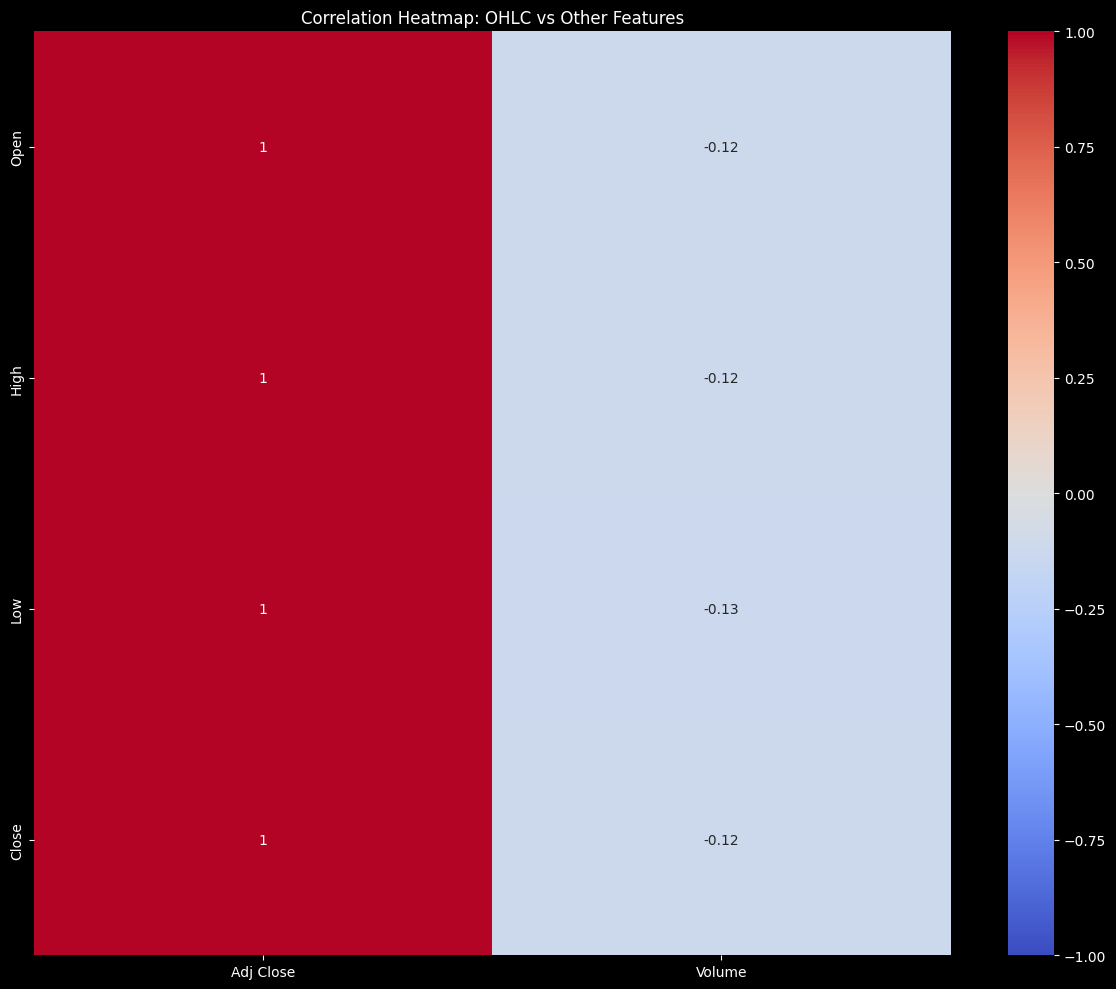


Top 5 highest absolute correlations:
Adj Close - Close: 1.0000
Adj Close - Low: 0.9998
Adj Close - High: 0.9998
Adj Close - Open: 0.9996
Volume - Low: 0.1259



Correlation Analysis for AMD_1d


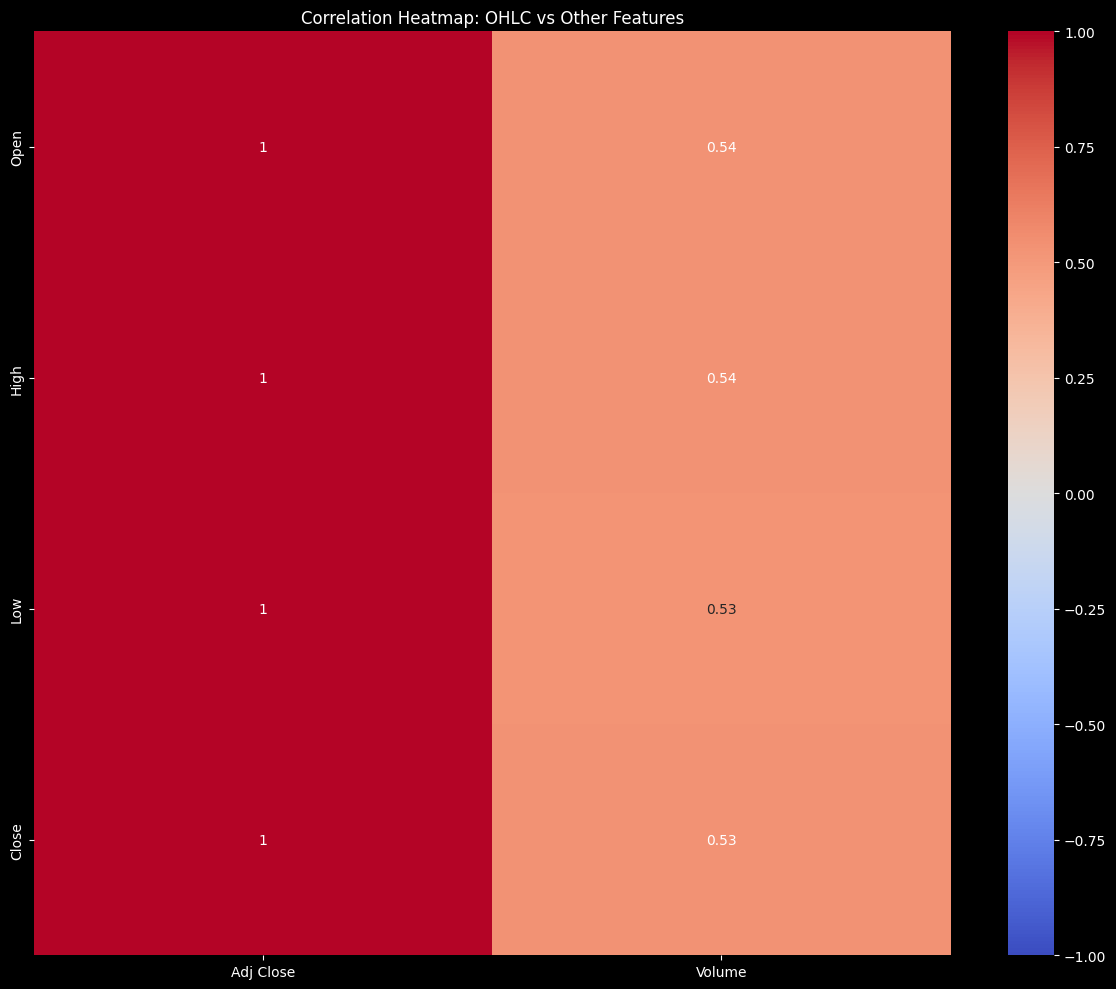


Top 5 highest absolute correlations:
Adj Close - Close: 1.0000
Adj Close - Low: 0.9998
Adj Close - High: 0.9997
Adj Close - Open: 0.9987
Volume - Open: 0.5368



Correlation Analysis for TQQQ_analyzed_output


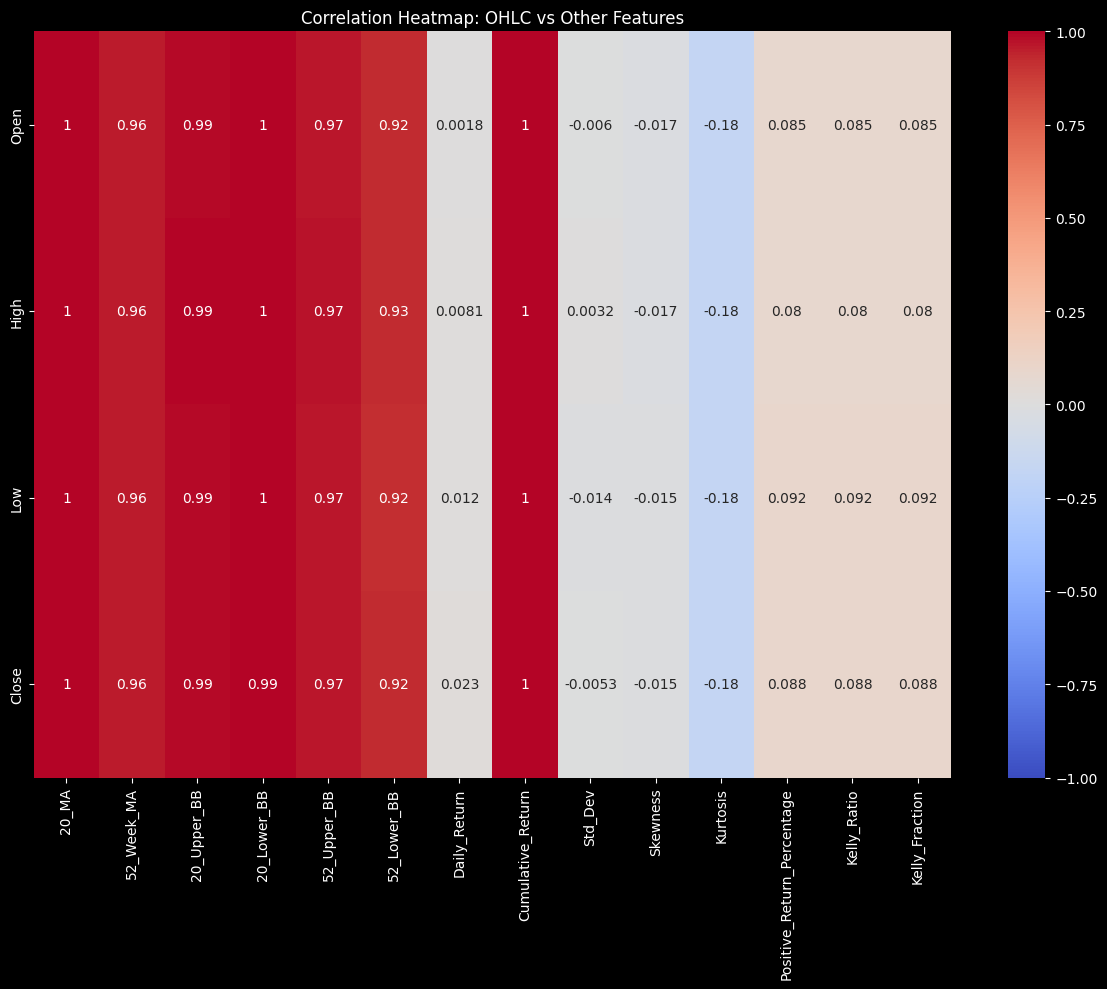


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for SPY_1mo


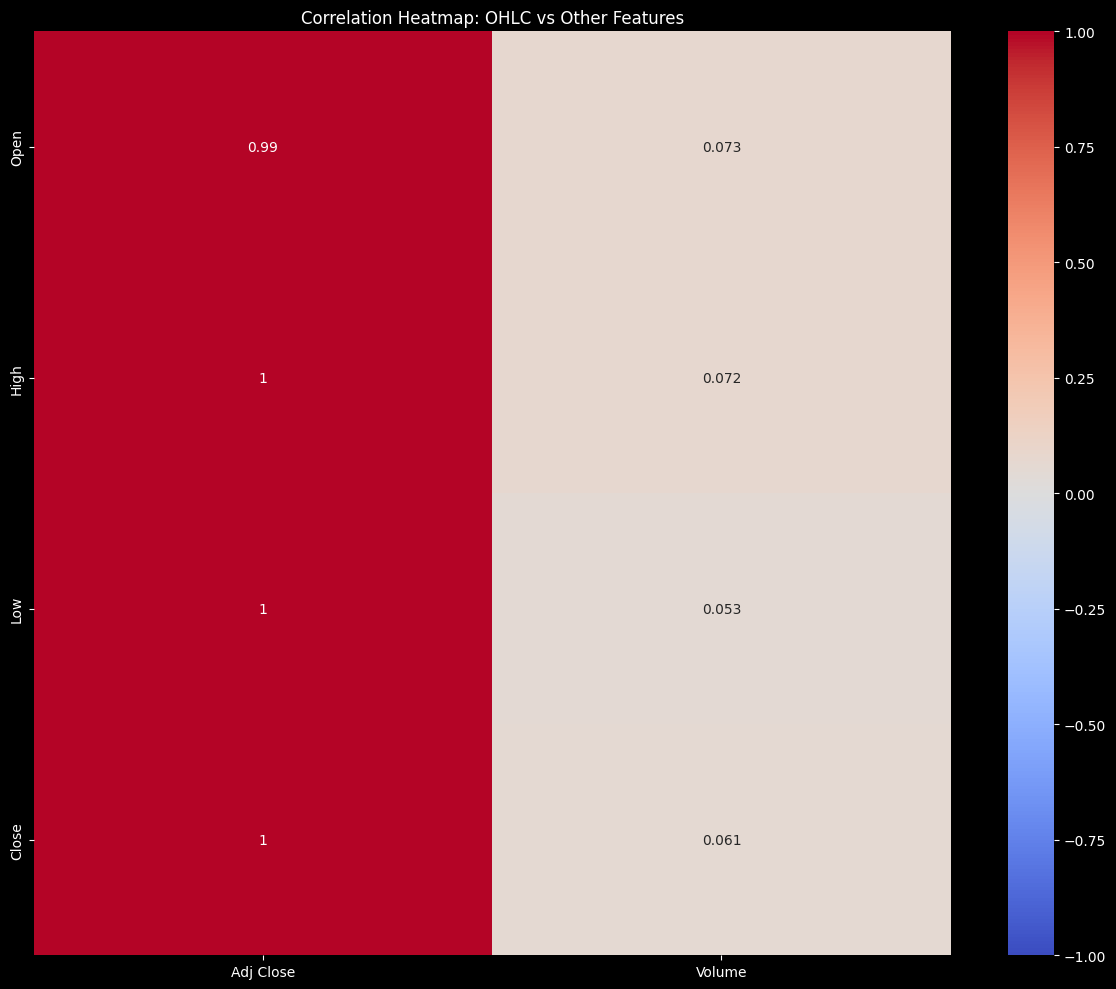


Top 5 highest absolute correlations:
Adj Close - Close: 0.9976
Adj Close - High: 0.9962
Adj Close - Low: 0.9960
Adj Close - Open: 0.9945
Volume - Open: 0.0731



Correlation Analysis for SPY_1d


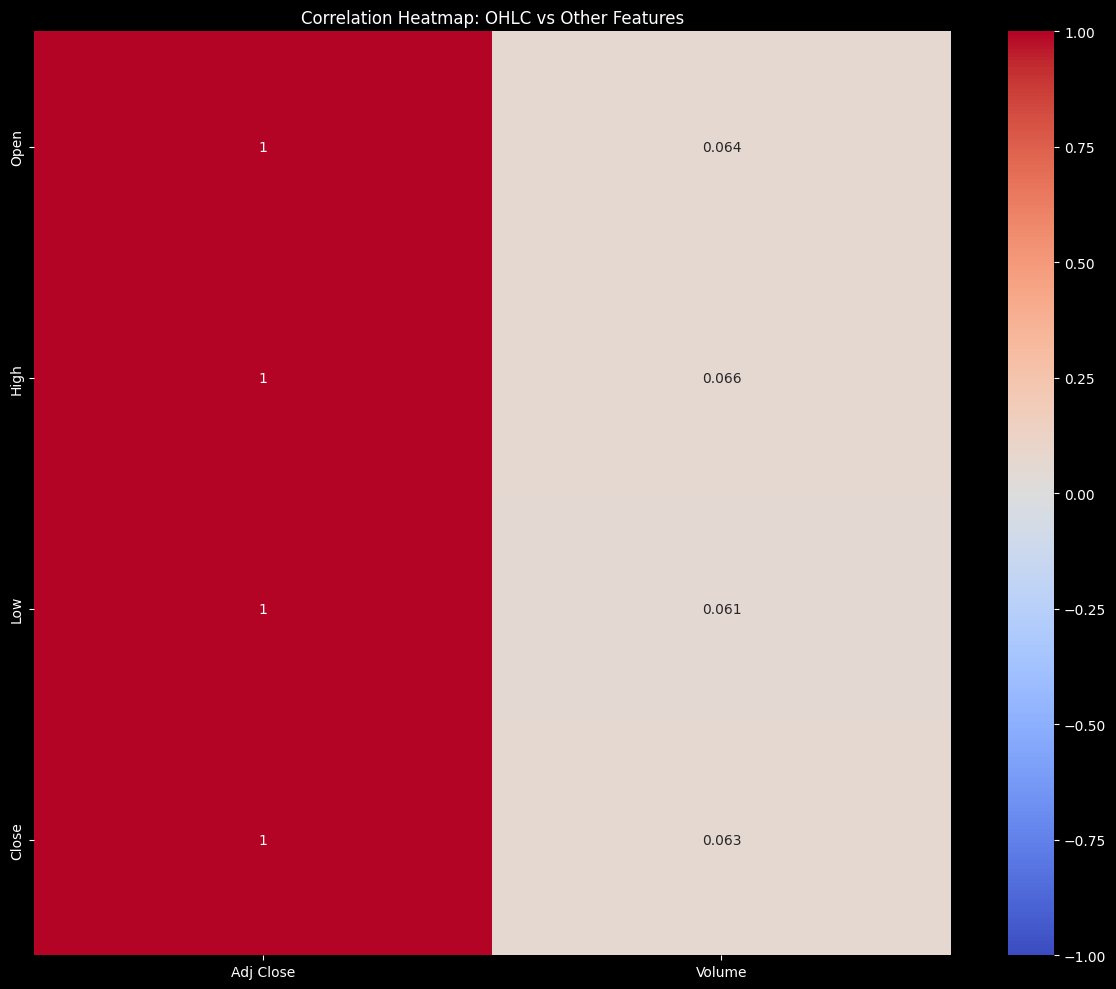


Top 5 highest absolute correlations:
Adj Close - Close: 0.9975
Adj Close - Low: 0.9975
Adj Close - High: 0.9975
Adj Close - Open: 0.9974
Volume - High: 0.0661



Correlation Analysis for INTC_1d


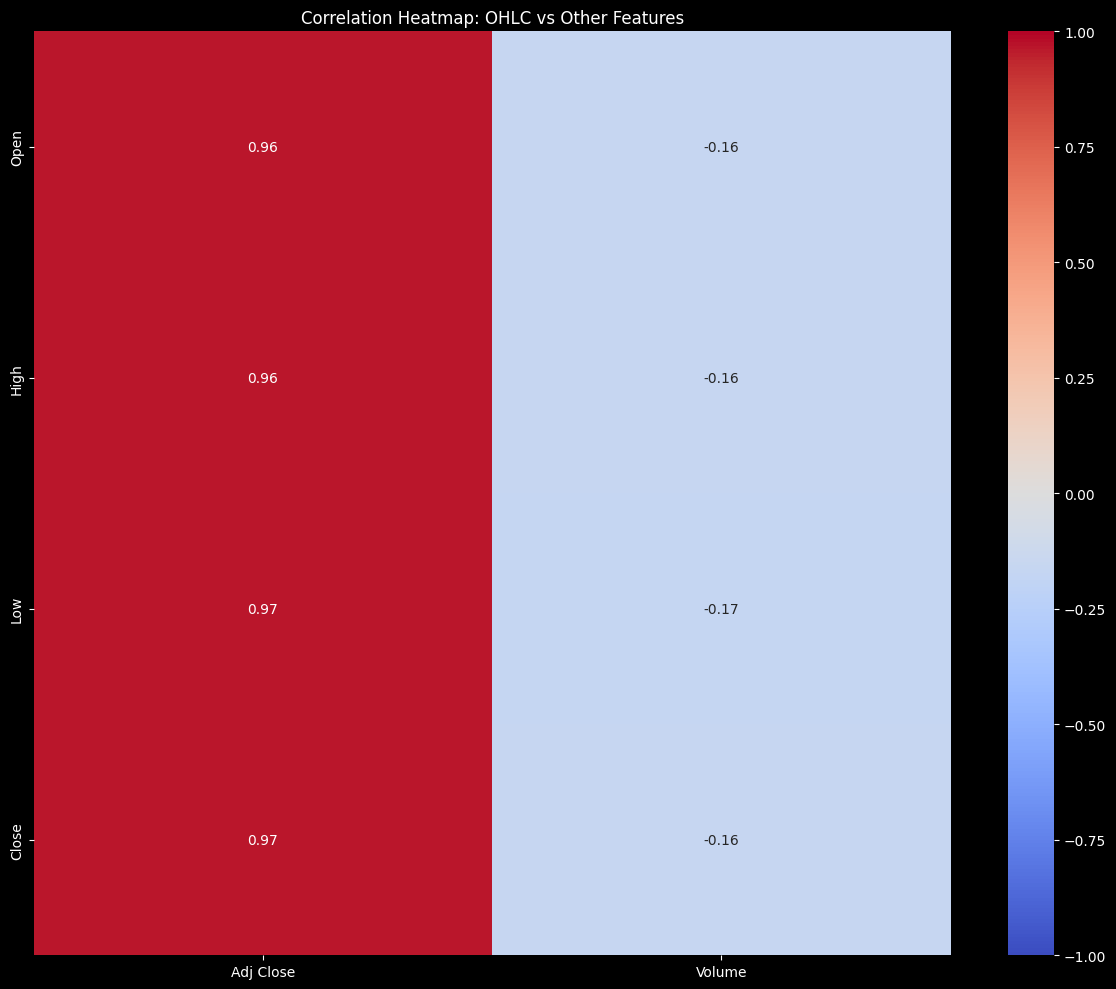


Top 5 highest absolute correlations:
Adj Close - Low: 0.9658
Adj Close - Close: 0.9651
Adj Close - Open: 0.9646
Adj Close - High: 0.9638
Volume - Low: 0.1667



Correlation Analysis for INTC_1wk


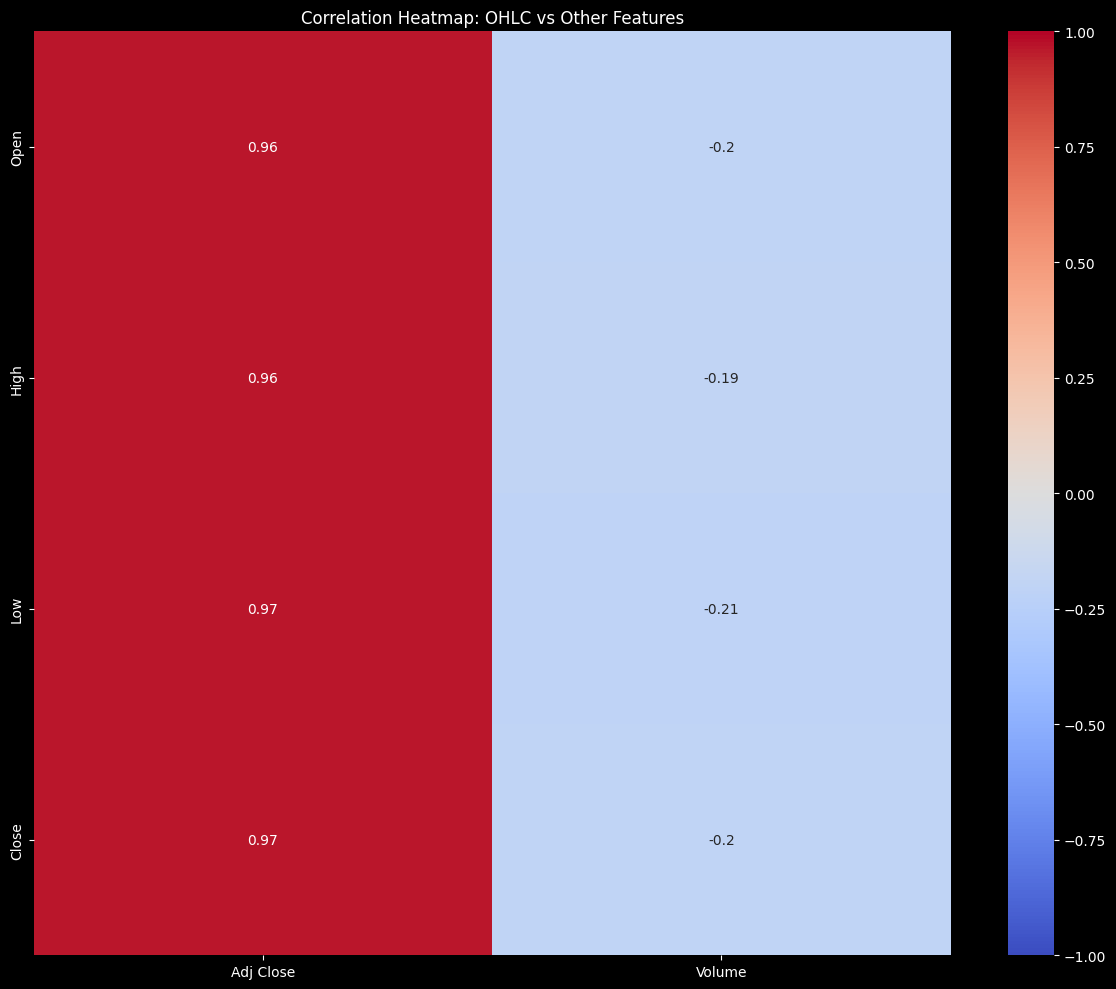


Top 5 highest absolute correlations:
Adj Close - Low: 0.9666
Adj Close - Close: 0.9651
Adj Close - Open: 0.9626
Adj Close - High: 0.9617
Volume - Low: 0.2091



Correlation Analysis for SPY_1wk


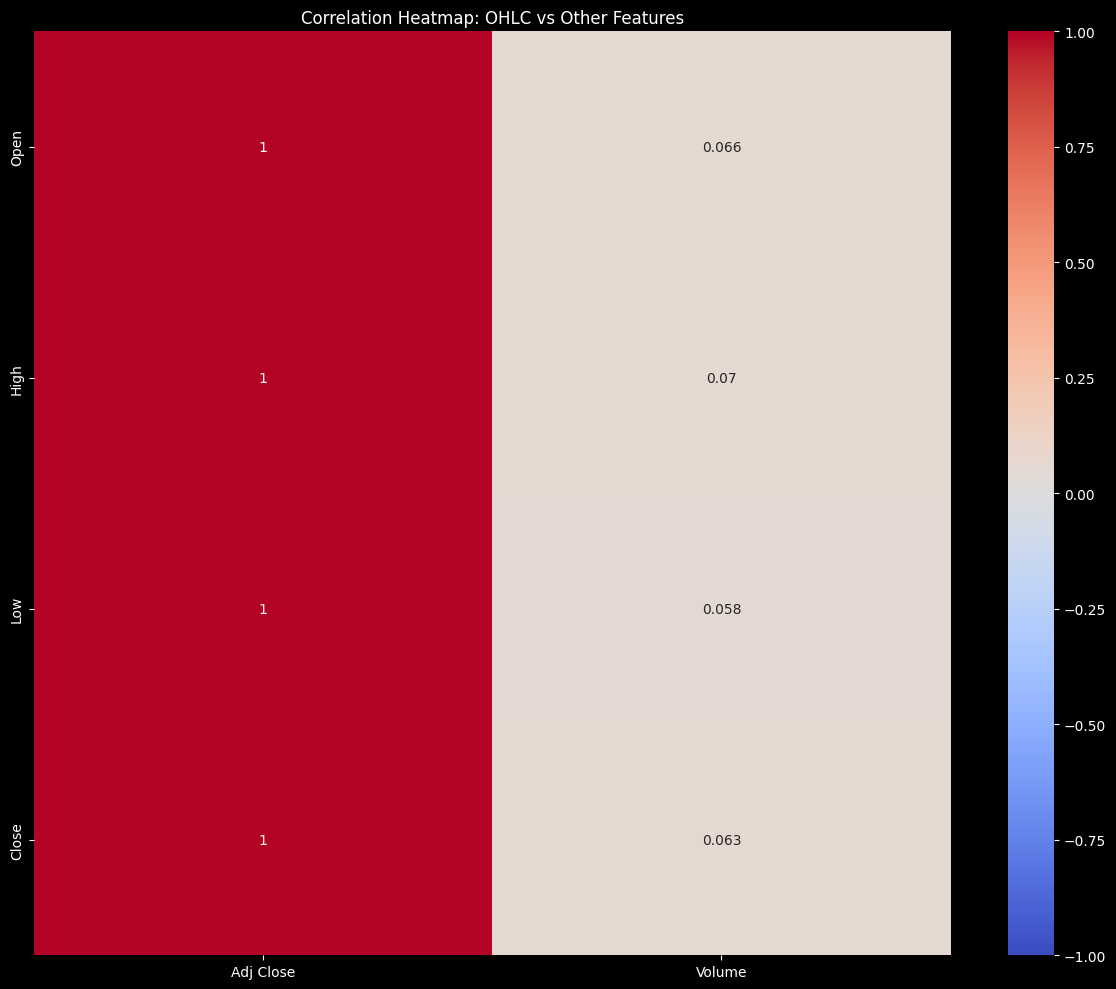


Top 5 highest absolute correlations:
Adj Close - Close: 0.9975
Adj Close - High: 0.9972
Adj Close - Low: 0.9972
Adj Close - Open: 0.9968
Volume - High: 0.0697



Correlation Analysis for AMD_1wk


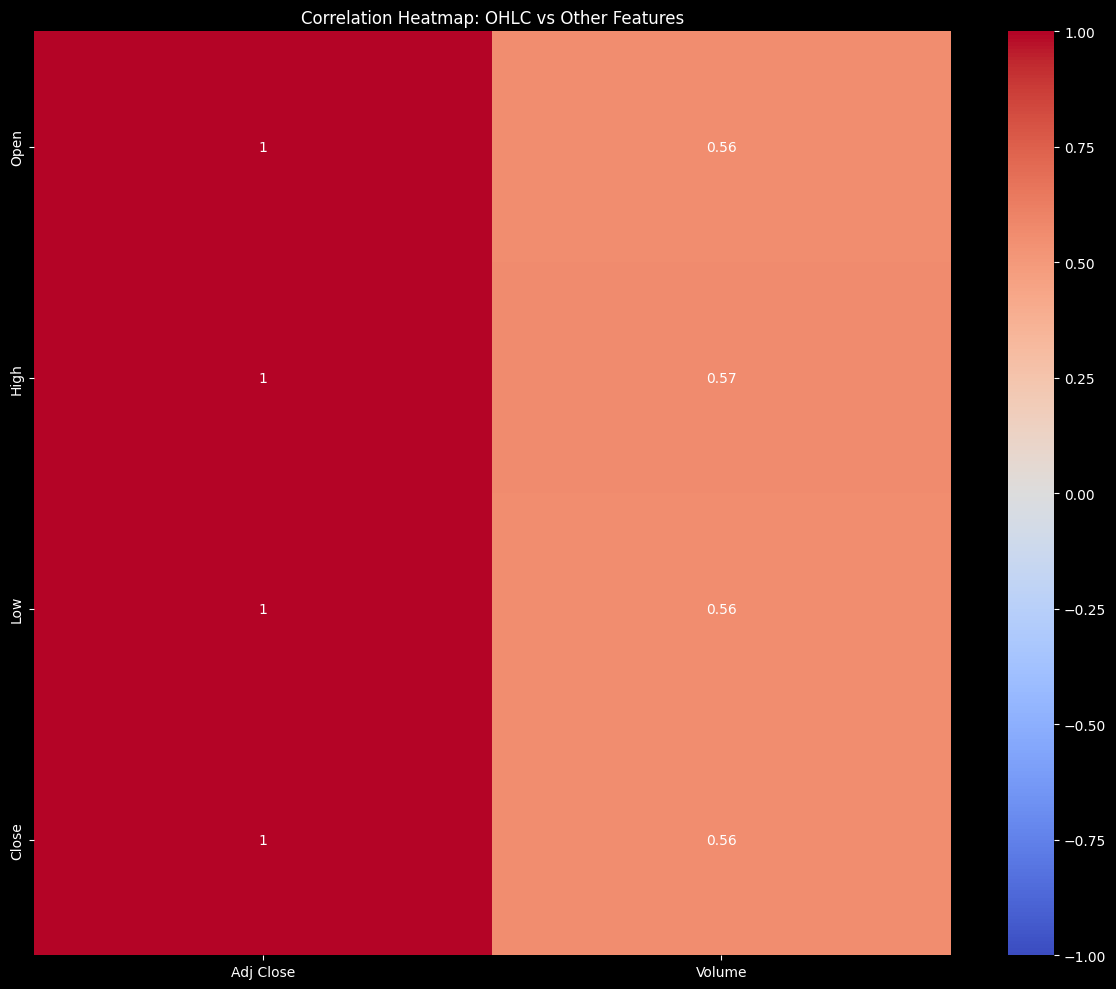


Top 5 highest absolute correlations:
Adj Close - High: 0.9987
Adj Close - Low: 0.9986
Adj Close - Open: 0.9959
Volume - High: 0.5655
Volume - Open: 0.5614



Correlation Analysis for QQQ_analyzed_output


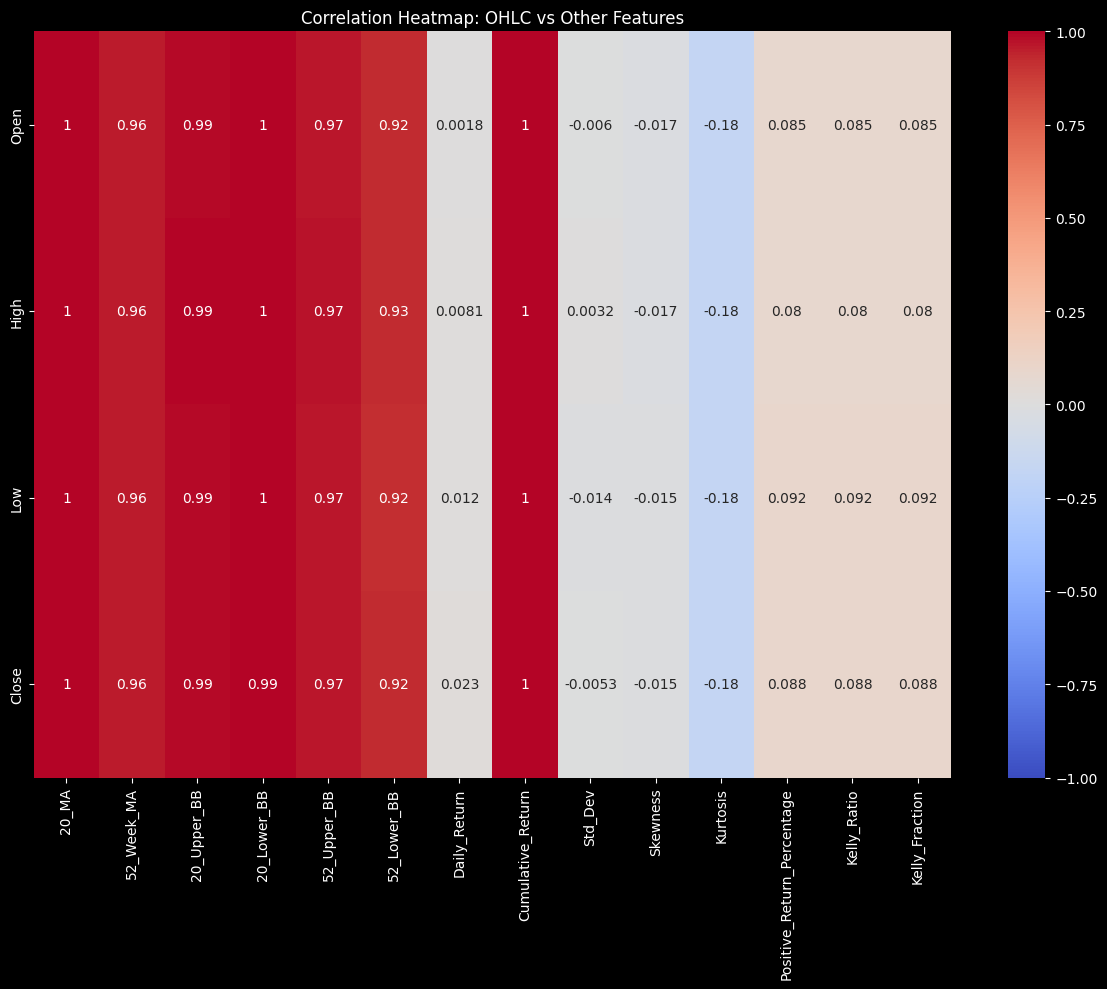


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for NVDA_1wk


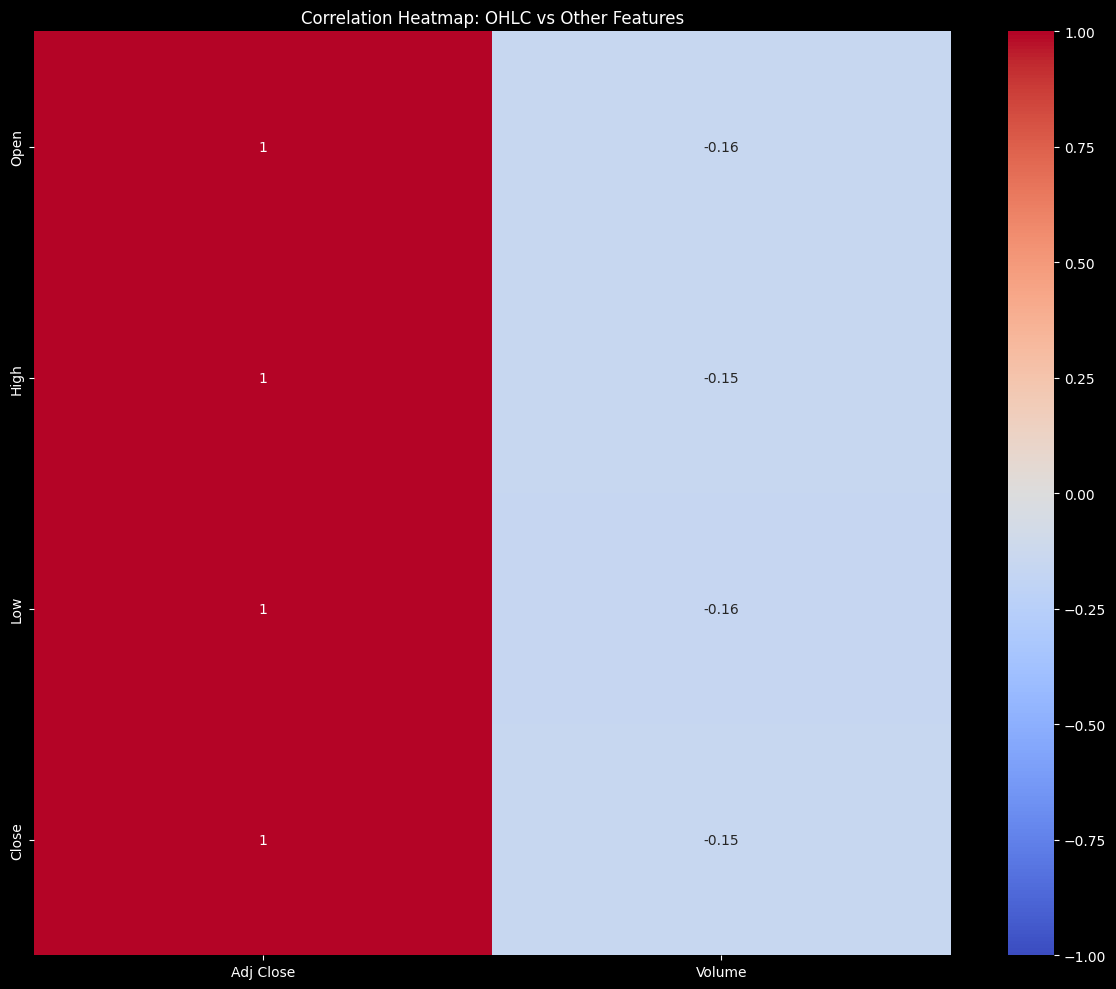


Top 5 highest absolute correlations:
Adj Close - Close: 1.0000
Adj Close - High: 0.9991
Adj Close - Low: 0.9988
Adj Close - Open: 0.9974
Volume - Low: 0.1568



Correlation Analysis for UPRO_analyzed_output


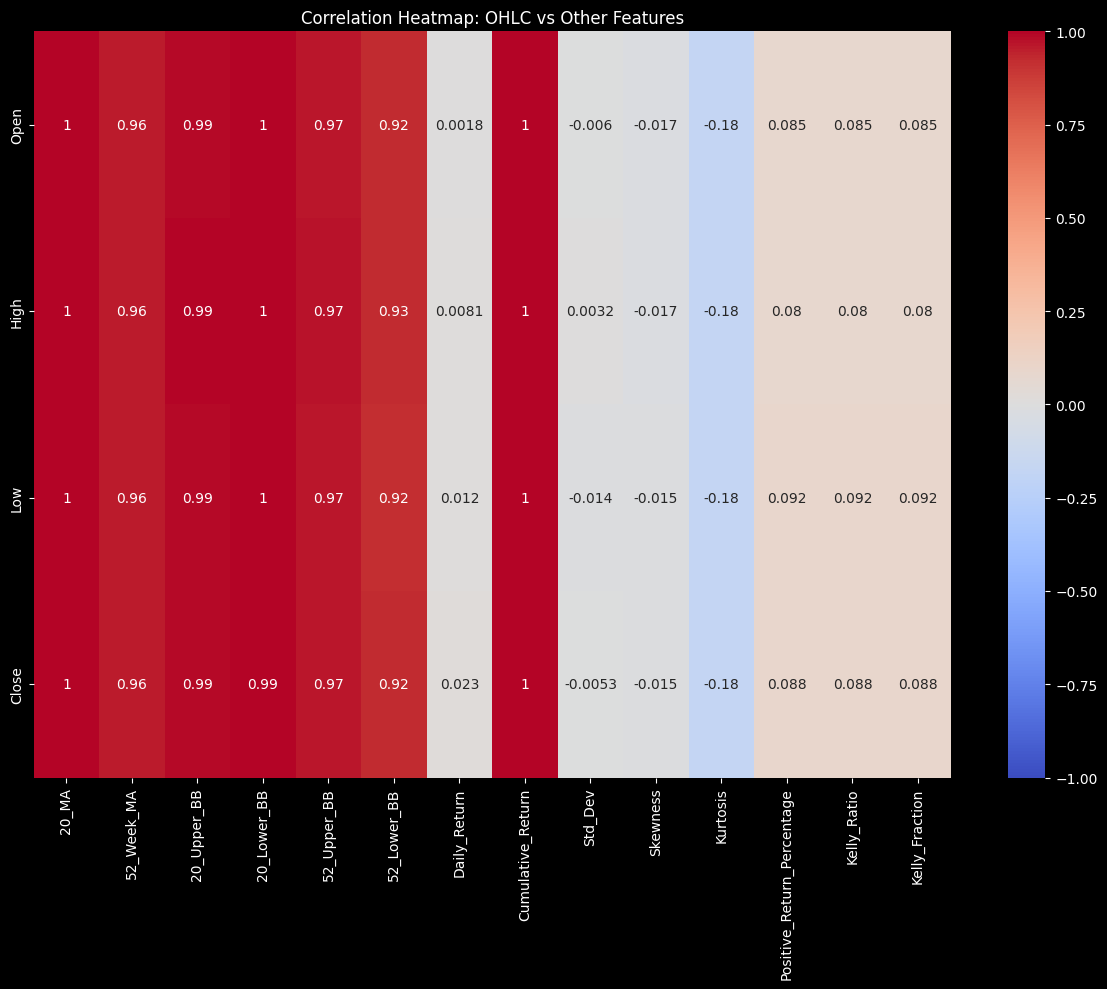


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for SQQQ_analyzed_output


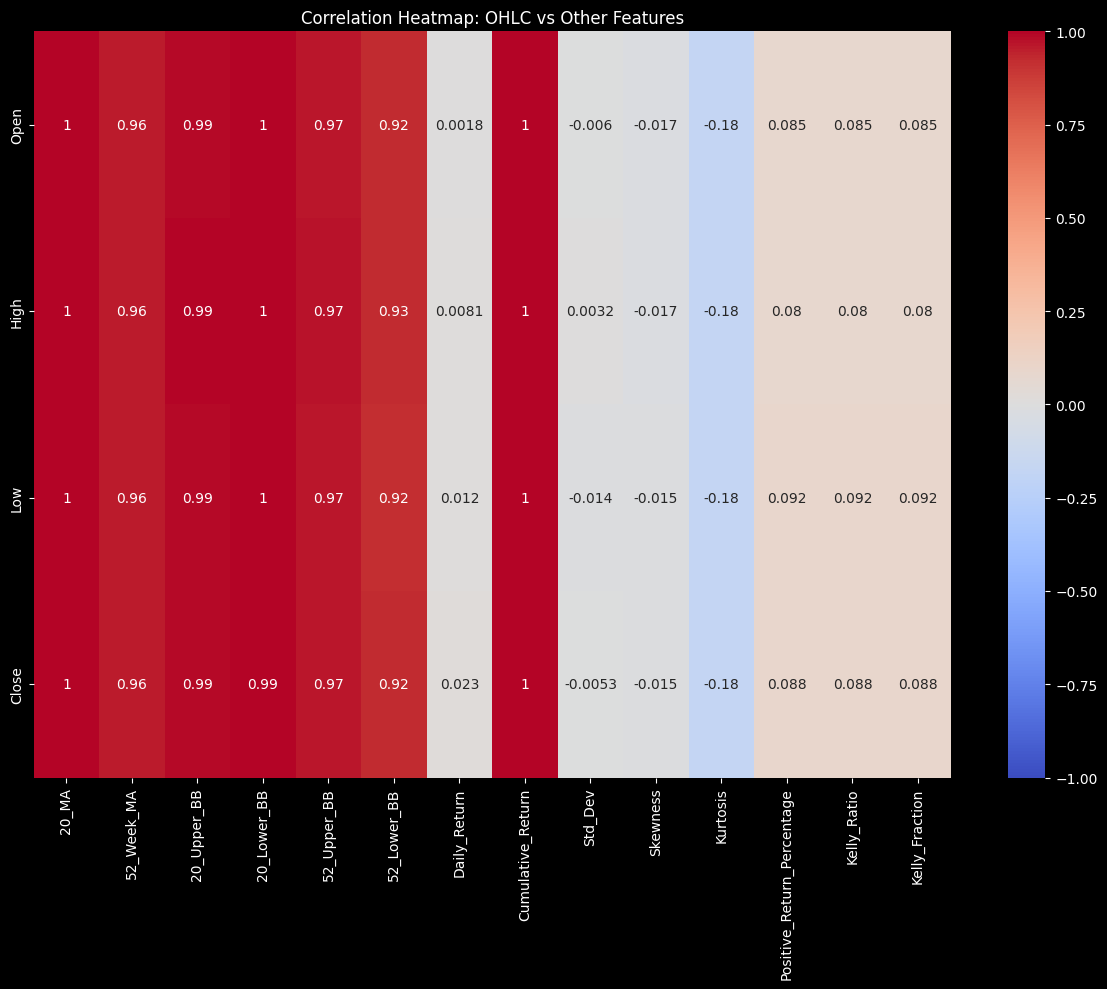


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968



Correlation Analysis for PSQ_analyzed_output


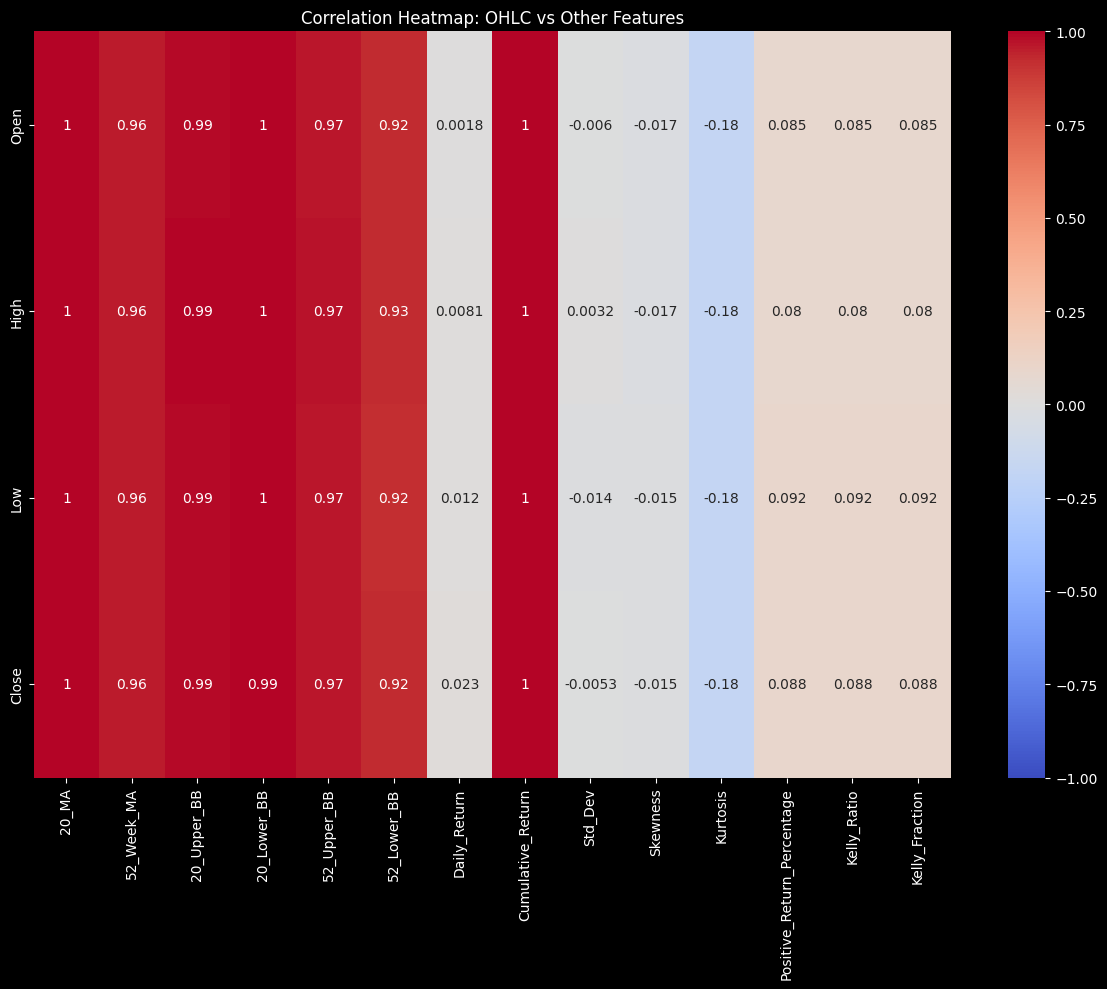


Top 5 highest absolute correlations:
Cumulative_Return - Close: 1.0000
Cumulative_Return - Low: 0.9998
Cumulative_Return - High: 0.9997
Cumulative_Return - Open: 0.9996
20_MA - High: 0.9968




In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def measure_and_visualize_correlations(df):
    """
    Measure correlations between OHLC features and other features, and visualize them using a heatmap.
    
    Args:
    df (pd.DataFrame): DataFrame containing the stock data
    
    Returns:
    pd.DataFrame: Correlation matrix
    """
    # Select OHLC features
    ohlc_features = ['Open', 'High', 'Low', 'Close']
    
    # Select other features (excluding OHLC)
    other_features = [col for col in df.columns if col not in ohlc_features]
    
    # Create a correlation matrix
    corr_matrix = pd.DataFrame(index=ohlc_features, columns=other_features)
    
    # Calculate correlations
    for ohlc in ohlc_features:
        for feature in other_features:
            corr_matrix.loc[ohlc, feature] = df[ohlc].corr(df[feature])
    
    # Visualize the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap: OHLC vs Other Features')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Apply the function to each stock's data
for symbol, df in data_dict.items():
    print(f"\nCorrelation Analysis for {symbol}")
    try:
        # Convert all columns to numeric, coercing errors to NaN
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Drop any columns that are entirely NaN
        df = df.dropna(axis=1, how='all')
        
        corr_matrix = measure_and_visualize_correlations(df)
        
        # Print the highest correlations
        print("\nTop 5 highest absolute correlations:")
        # Flatten the correlation matrix and remove self-correlations
        corr_series = corr_matrix.abs().unstack()
        corr_series = corr_series[corr_series != 1.0]
        
        # Sort correlations and get top 5
        top_correlations = corr_series.sort_values(ascending=False).head(5)
        
        for (ohlc, feature), correlation in top_correlations.items():
            print(f"{ohlc} - {feature}: {correlation:.4f}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check the data types and content of the DataFrame.")
    
    print("\n" + "="*50 + "\n")



Analyzing NVDA_1mo
Random Forest - Mean Squared Error: 6.2723
Random Forest - R-squared Score: 0.9857

Random Forest Feature Importance:
  feature  importance
Adj Close    0.306974
      Low    0.259507
     High    0.253509
     Open    0.177342
   Volume    0.002669


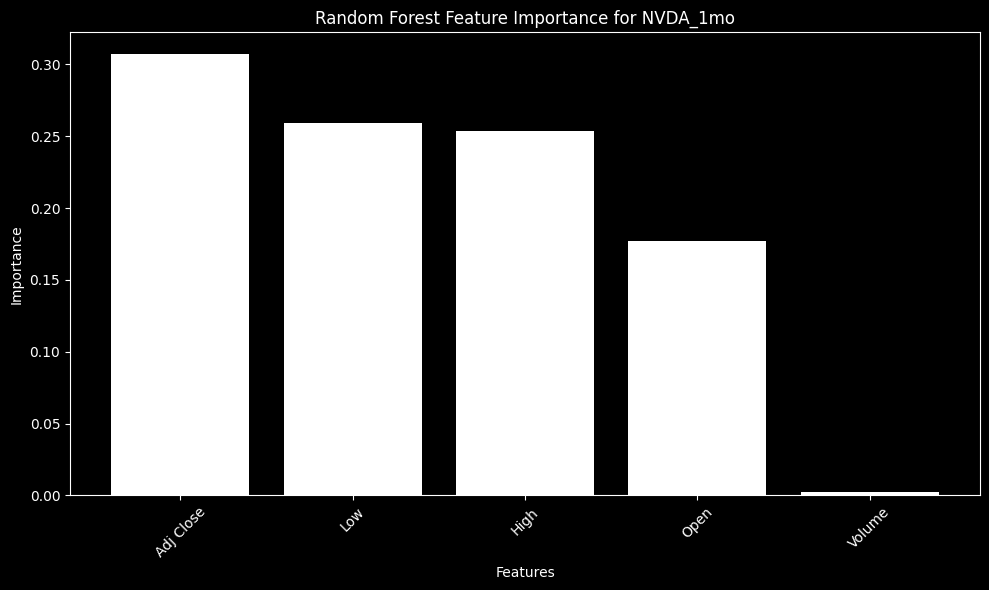

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1394.922, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1436.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1412.146, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1412.104, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1441.871, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1395.751, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1394.726, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1413.977, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1390.911, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1349.047, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1363.687, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1323.324, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1364.671, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1322.423, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0]          

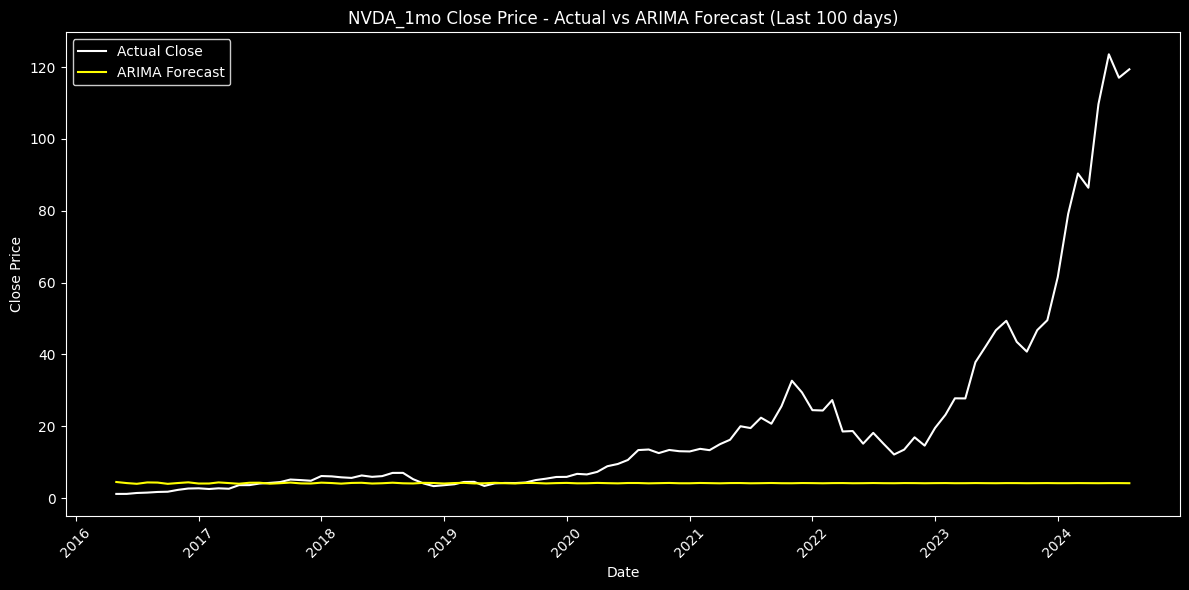


Analyzing SPY_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


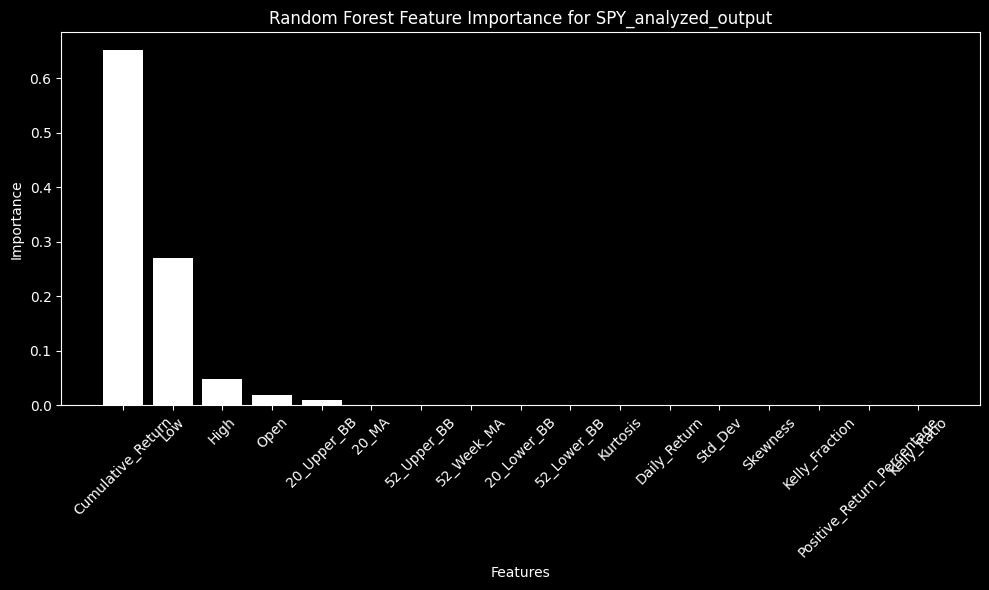

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.398 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

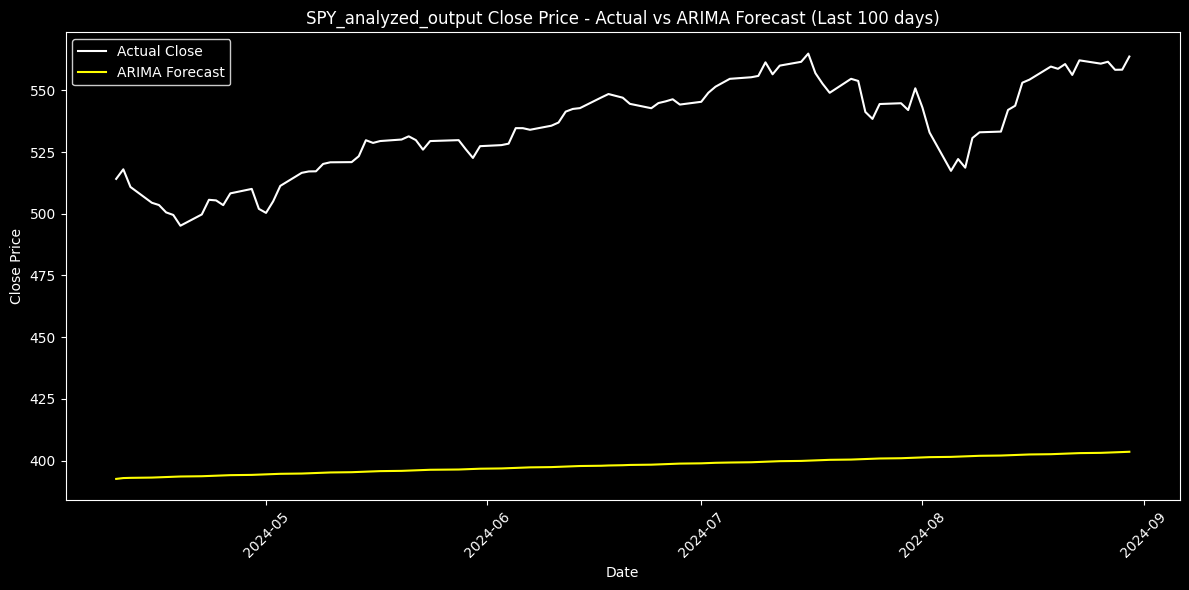


Analyzing INTC_1mo
Random Forest - Mean Squared Error: 3.0822
Random Forest - R-squared Score: 0.9905

Random Forest Feature Importance:
  feature  importance
      Low    0.506566
     High    0.266411
Adj Close    0.171763
     Open    0.054062
   Volume    0.001198


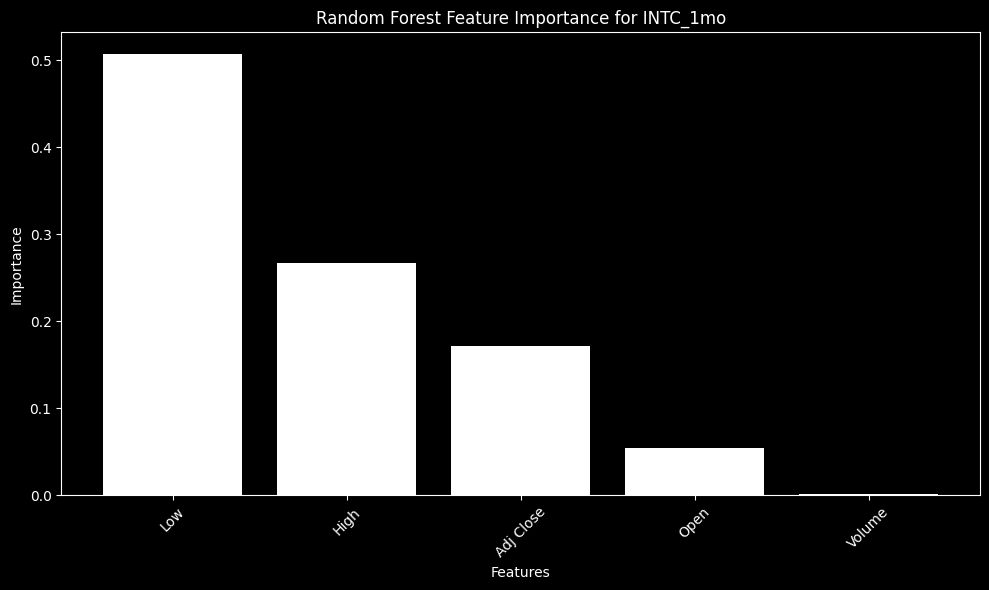

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2416.028, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2416.757, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2414.071, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2414.347, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2414.860, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2415.935, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2416.729, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2412.206, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2414.063, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2414.161, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2412.482, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2414.830, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.656 seconds
ARIMA - Mean Squared Error: 177.3527


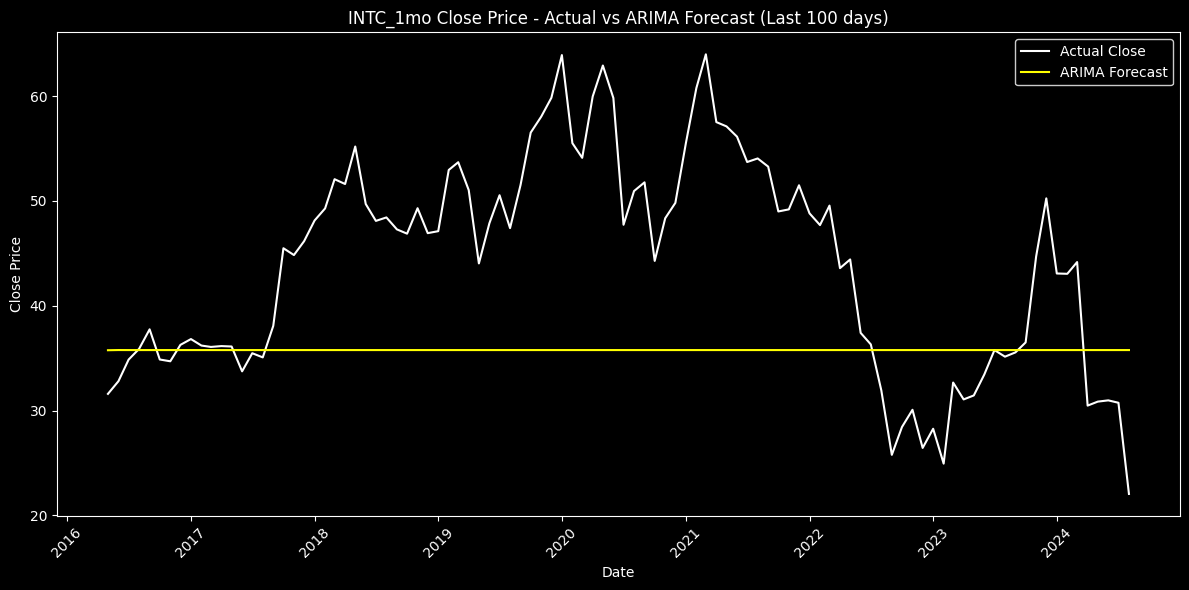


Analyzing SPI_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


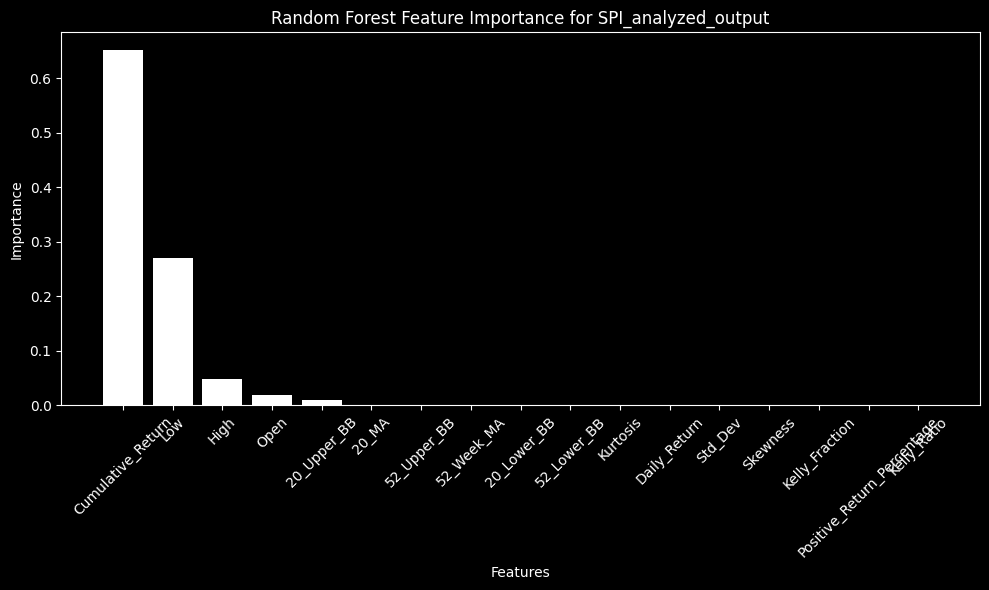

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.201 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

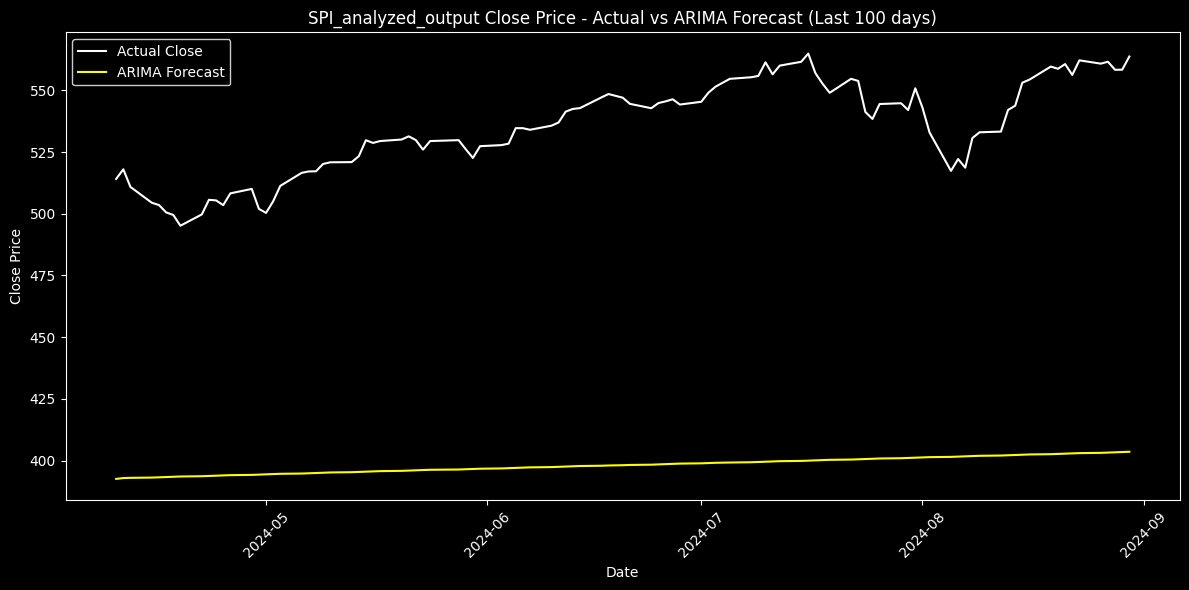


Analyzing AMD_1mo
Random Forest - Mean Squared Error: 1.6586
Random Forest - R-squared Score: 0.9988

Random Forest Feature Importance:
  feature  importance
Adj Close    0.447174
     High    0.240840
      Low    0.204670
     Open    0.106929
   Volume    0.000387


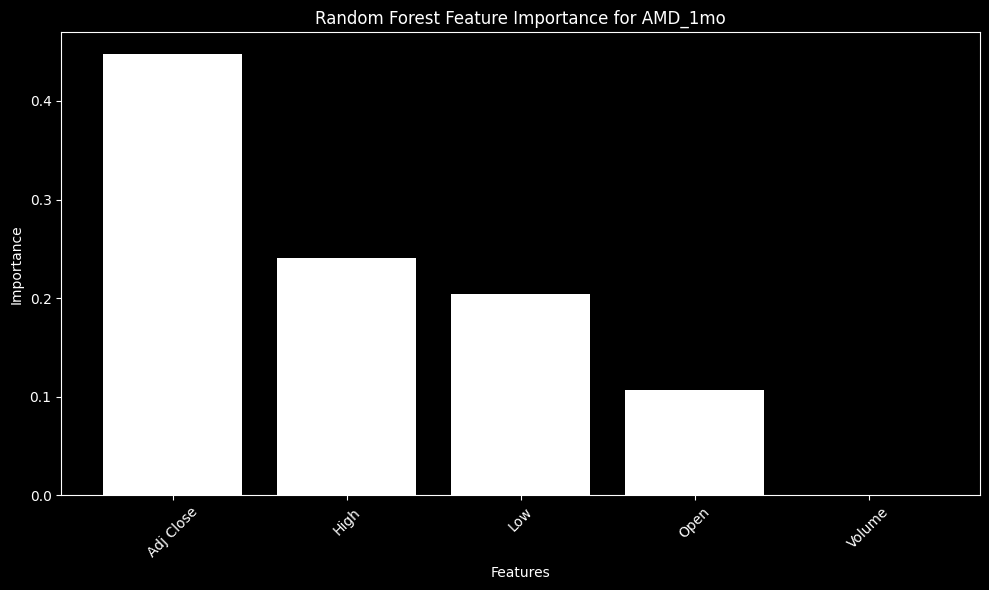

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2999.237, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2995.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2997.888, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2997.881, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2995.078, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
ARIMA - Mean Squared Error: 6020.8779


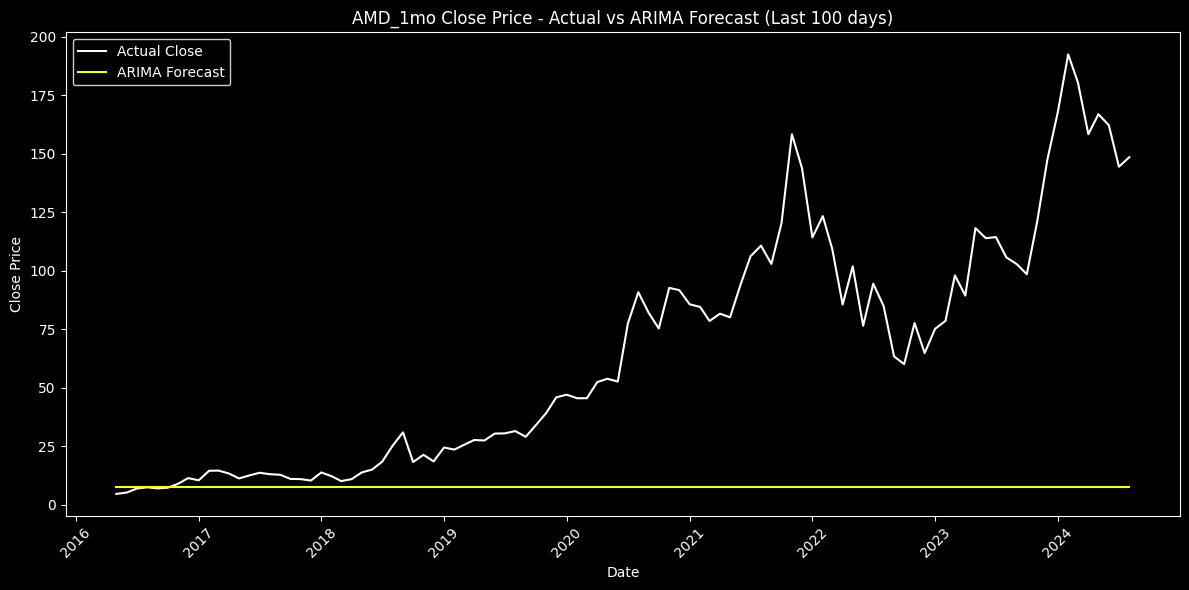


Analyzing SPXS_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


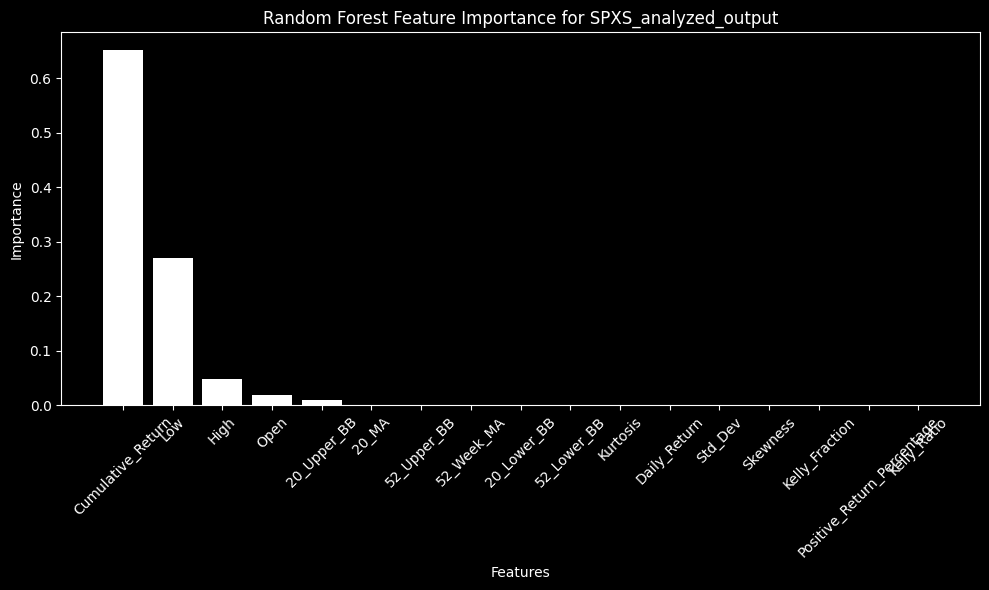

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.403 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

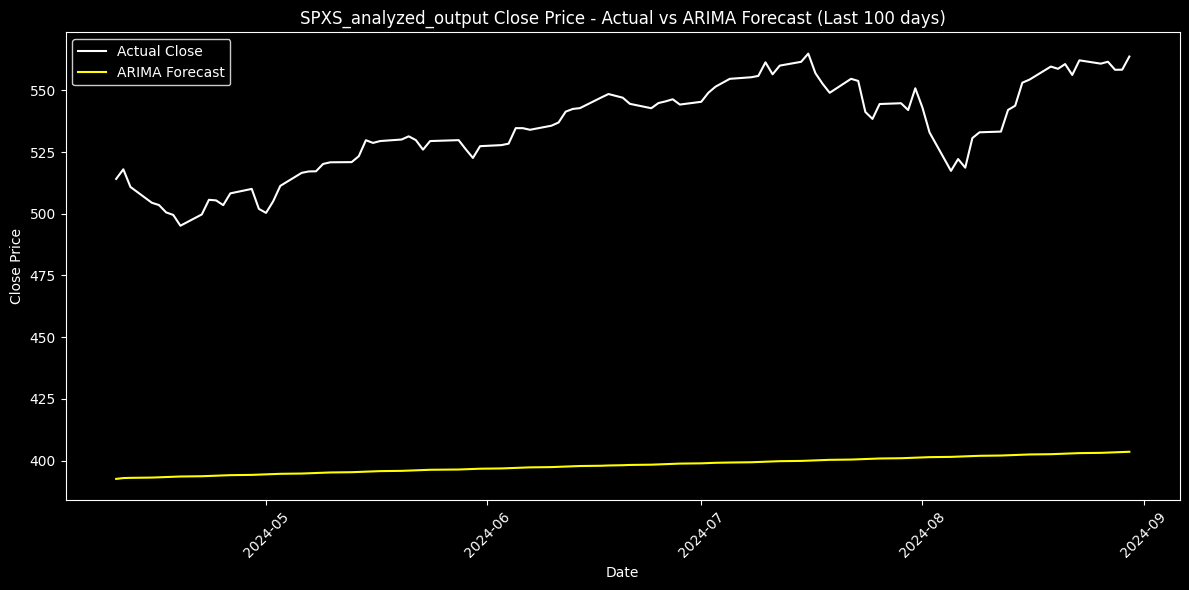


Analyzing NVDA_1d
Random Forest - Mean Squared Error: 0.0169
Random Forest - R-squared Score: 0.9999

Random Forest Feature Importance:
  feature  importance
Adj Close    0.449921
      Low    0.187732
     High    0.185035
     Open    0.177303
   Volume    0.000010


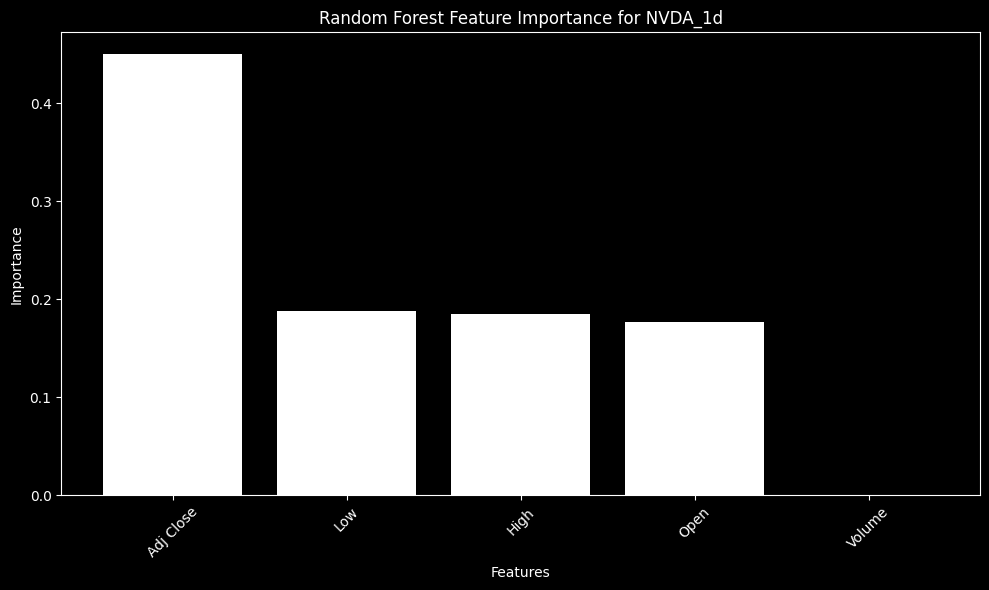

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12481.416, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12624.723, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12540.008, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12547.609, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12628.044, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12483.380, Time=1.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12483.375, Time=1.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12534.990, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12528.361, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12484.825, Time=3.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12485.512, Time=0.41 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 9.851 seconds


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

ARIMA - Mean Squared Error: 1448.8691


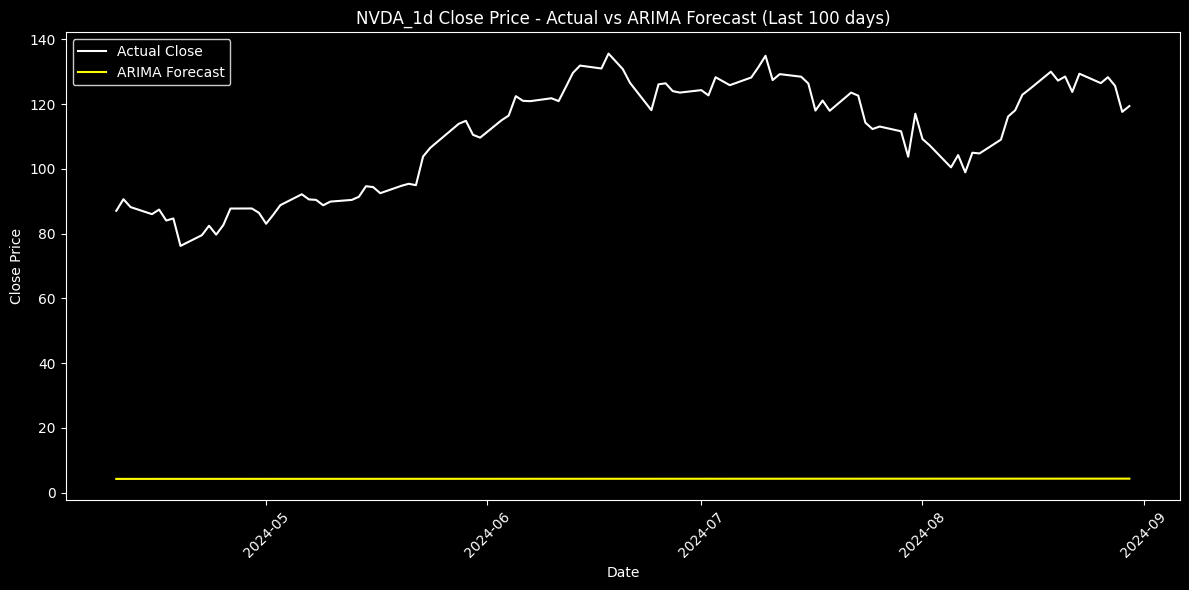


Analyzing AMD_1d
Random Forest - Mean Squared Error: 0.0417
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
  feature  importance
Adj Close    0.963620
      Low    0.034026
     High    0.002328
     Open    0.000021
   Volume    0.000005


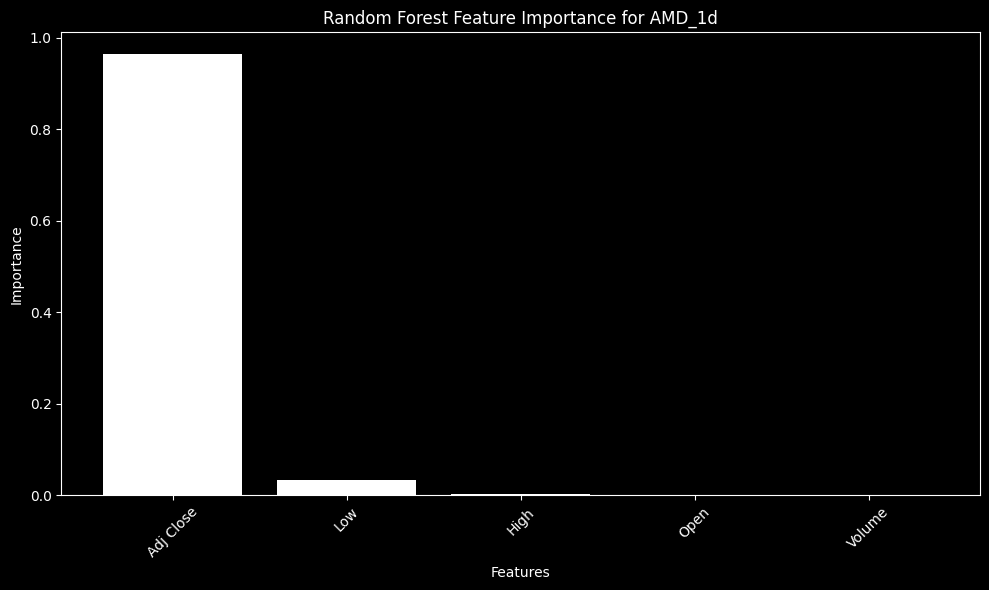

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36022.150, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36026.399, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36020.686, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36020.540, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36025.694, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=36021.723, Time=1.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36017.501, Time=8.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36024.951, Time=8.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=36020.613, Time=10.82 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=36021.857, Time=2.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=36017.442, Time=8.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36021.575, Time=1.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=36021.143, Time=7.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36021.908, Time=1.54 sec
 ARIMA(3,1,2)(0,0,

/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

ARIMA - Mean Squared Error: 5900.5689


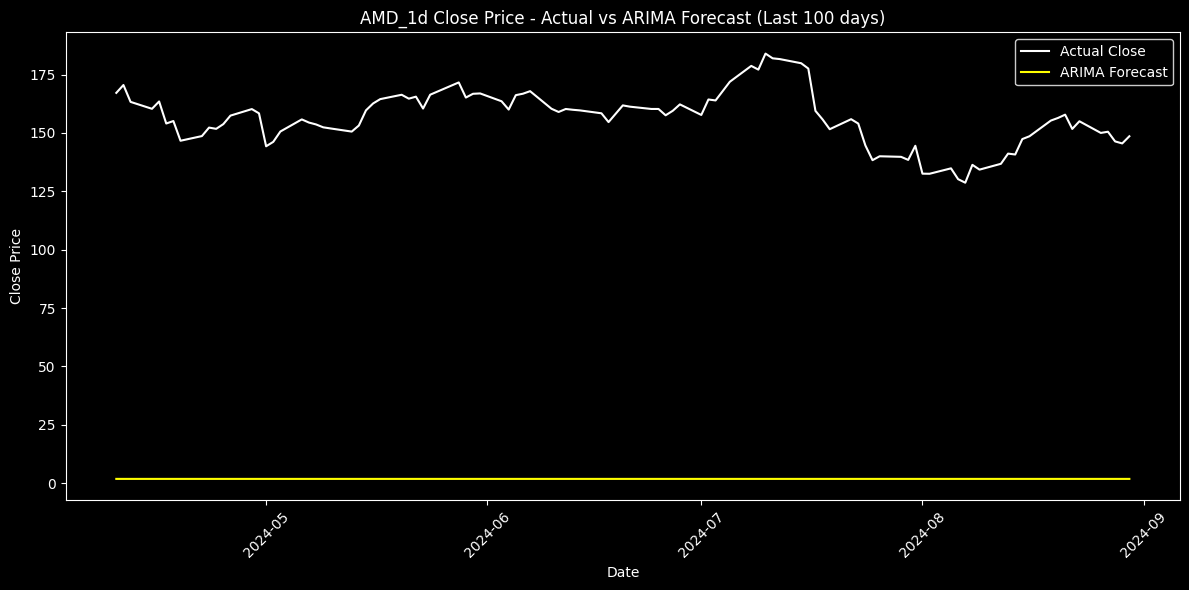


Analyzing TQQQ_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


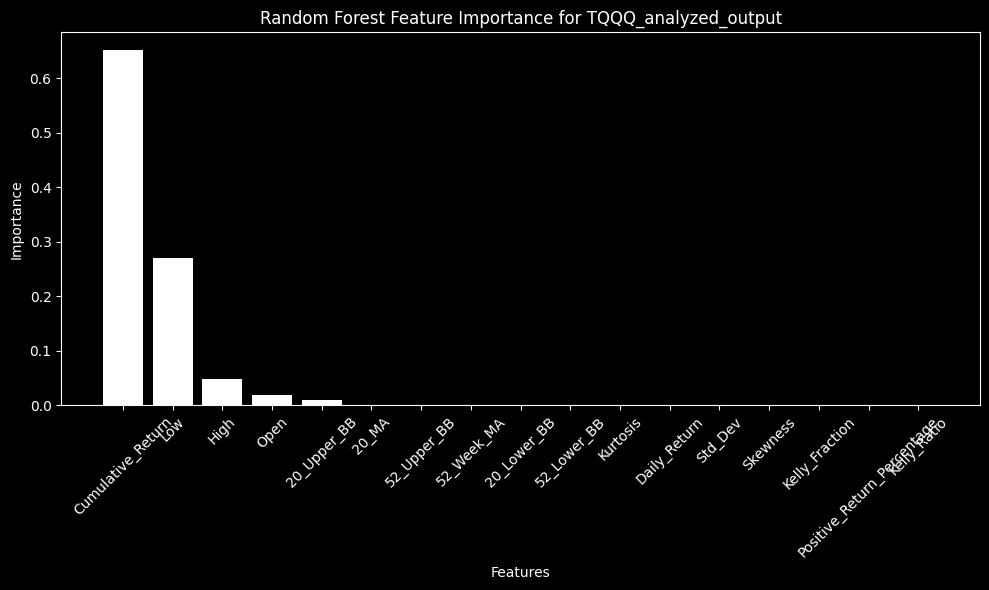

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.235 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

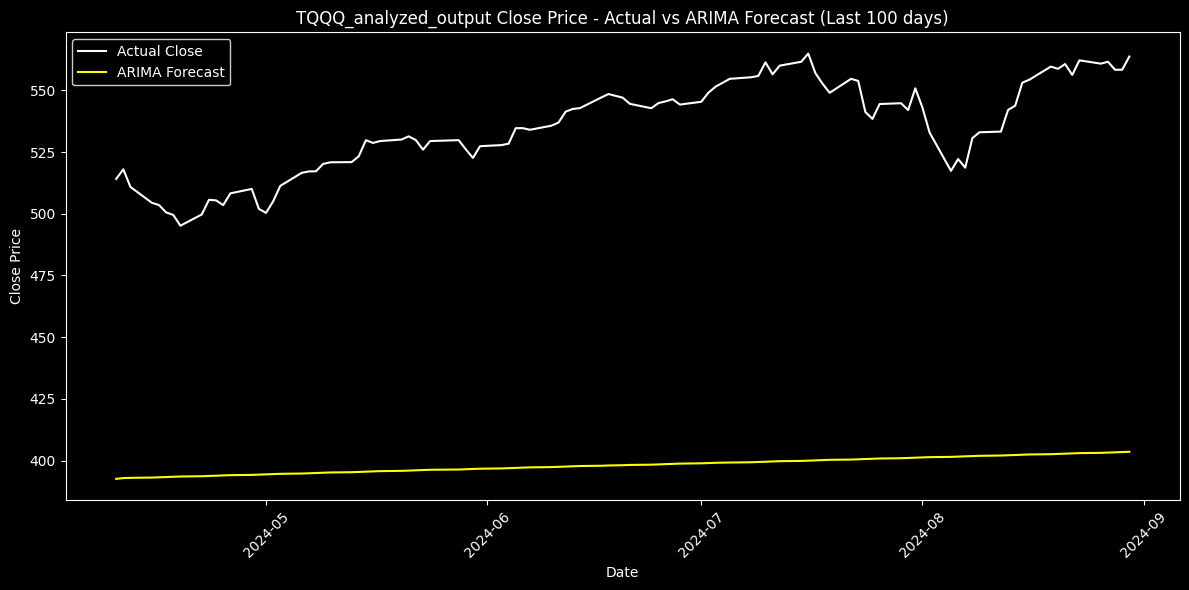


Analyzing SPY_1mo
Random Forest - Mean Squared Error: 20.5618
Random Forest - R-squared Score: 0.9985

Random Forest Feature Importance:
  feature  importance
Adj Close    0.436596
      Low    0.247897
     High    0.159094
     Open    0.155575
   Volume    0.000838


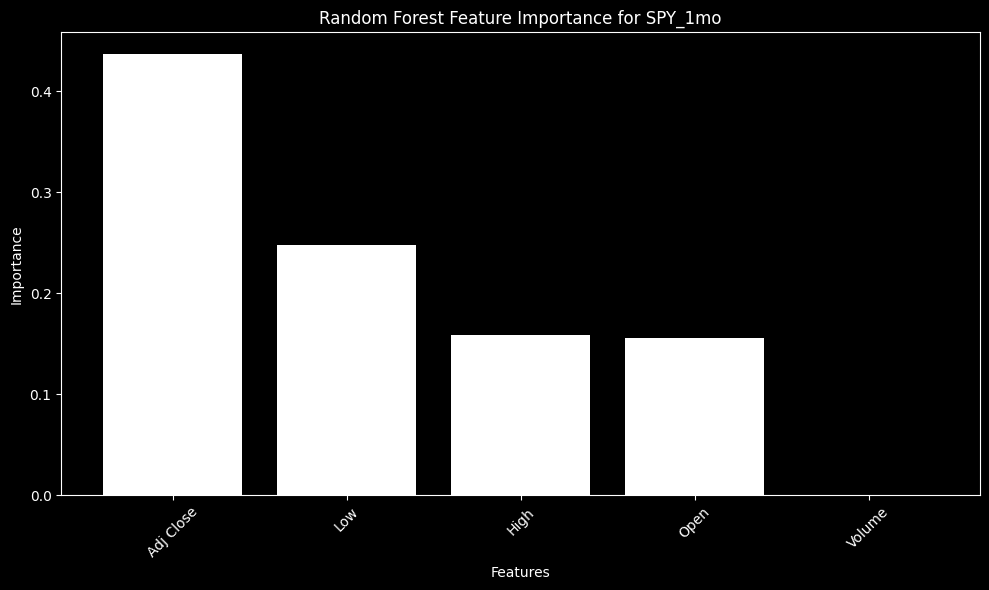

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2789.727, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2790.622, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2788.478, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2787.924, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2795.994, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2789.314, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2795.199, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.590 seconds
ARIMA - Mean Squared Error: 11813.6489


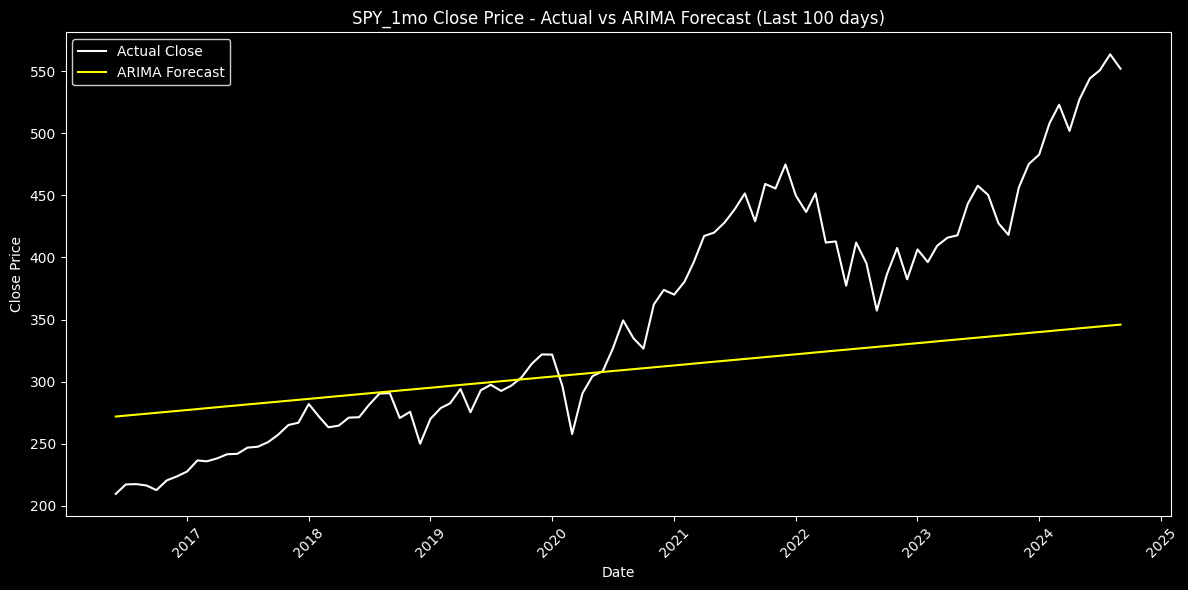


Analyzing SPY_1d
Random Forest - Mean Squared Error: 0.8087
Random Forest - R-squared Score: 0.9999

Random Forest Feature Importance:
  feature  importance
      Low    0.495268
     Open    0.213548
     High    0.184928
Adj Close    0.106249
   Volume    0.000008


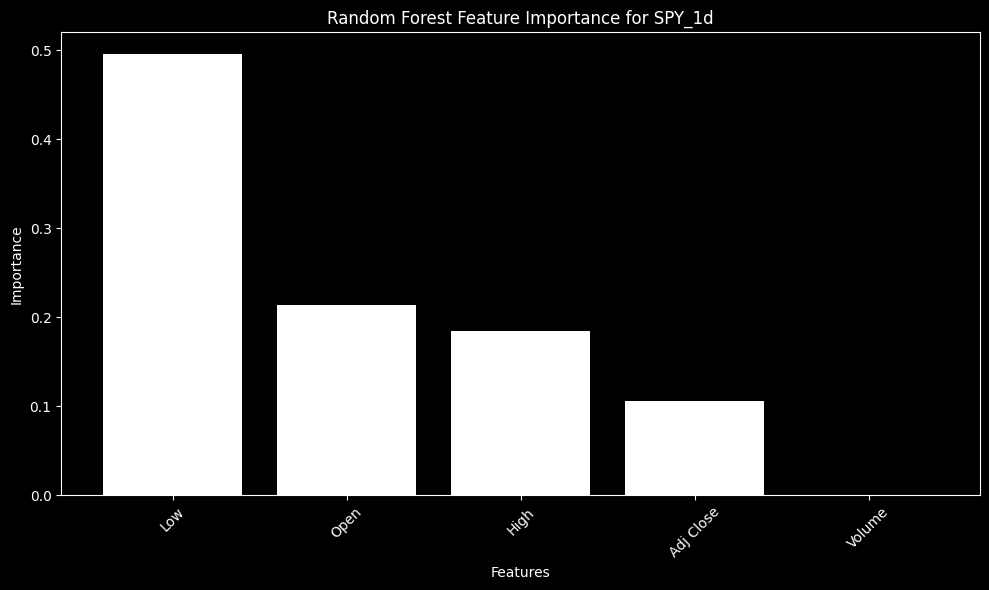

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35944.502, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35978.416, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35943.310, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35944.038, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35982.434, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35944.707, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35946.489, Time=1.88 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35948.225, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.126 seconds


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

ARIMA - Mean Squared Error: 11690.6326


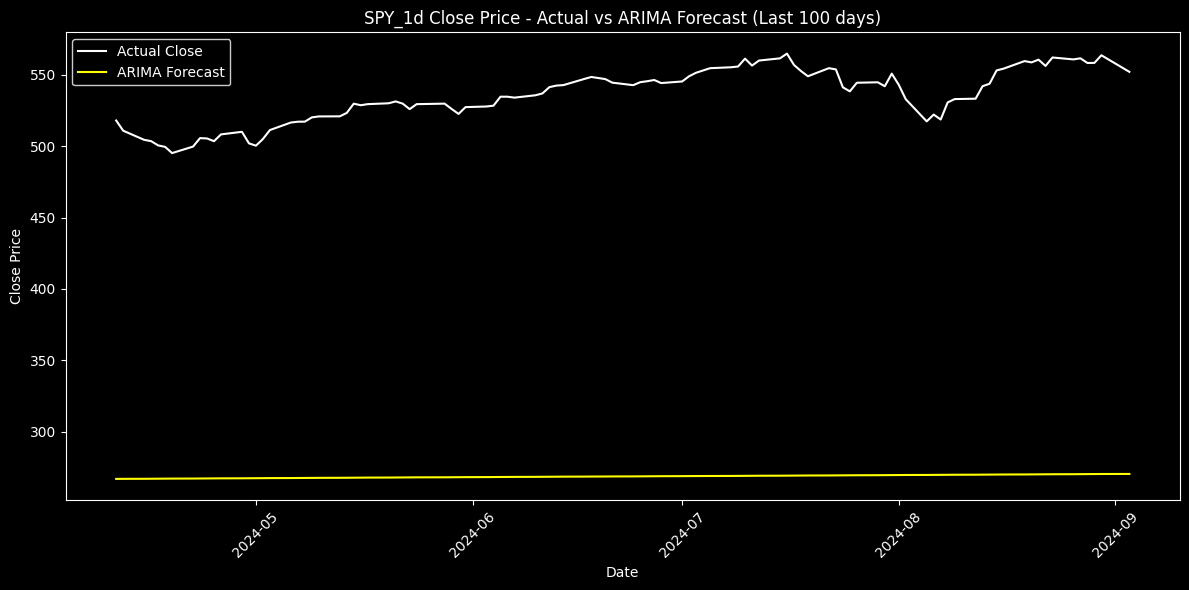


Analyzing INTC_1d
Random Forest - Mean Squared Error: 0.0599
Random Forest - R-squared Score: 0.9998

Random Forest Feature Importance:
  feature  importance
     High    0.679347
      Low    0.287170
Adj Close    0.032370
     Open    0.001087
   Volume    0.000027


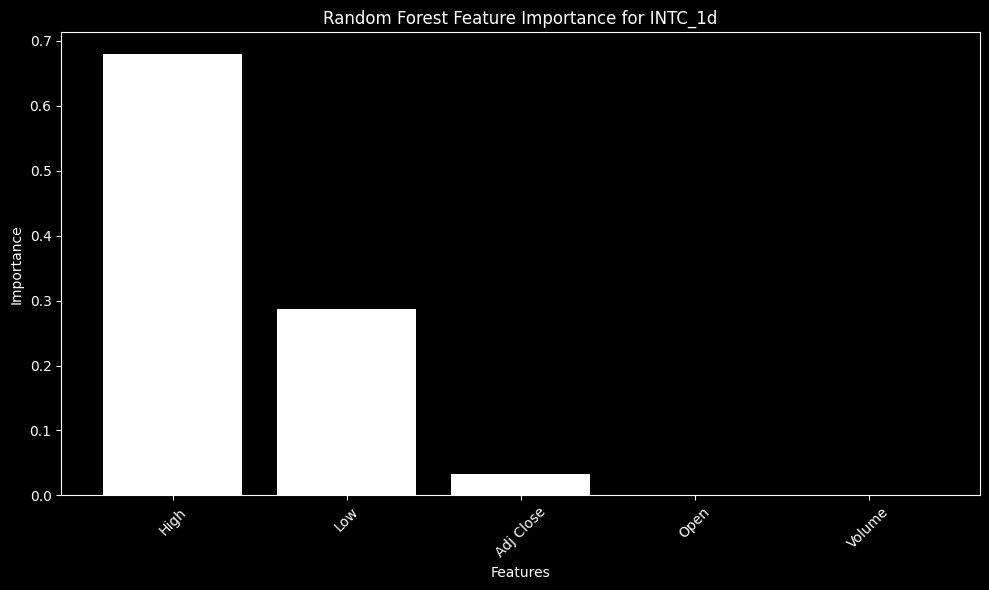

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22938.169, Time=4.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23012.697, Time=1.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22944.669, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22947.926, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23010.790, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22940.116, Time=7.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22940.104, Time=5.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22942.736, Time=2.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22940.529, Time=1.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22940.572, Time=16.84 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22936.272, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22946.033, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22942.775, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=22938.218, Time=1.65 sec
 ARIMA(1,1,2)(0,0,

/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

ARIMA - Mean Squared Error: 276.5986


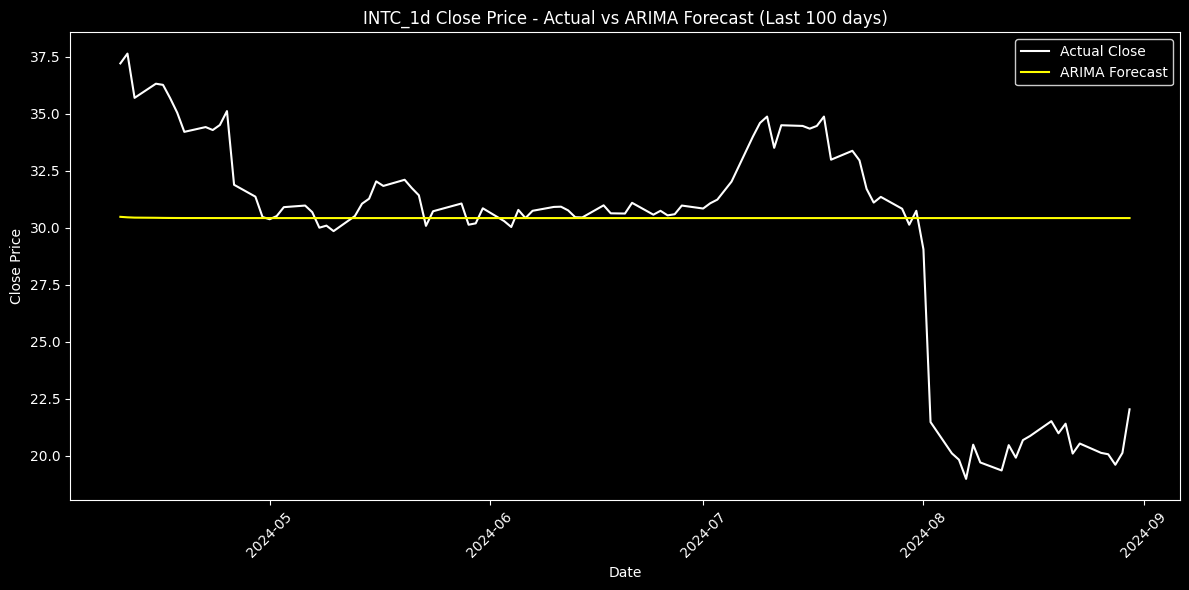


Analyzing INTC_1wk
Random Forest - Mean Squared Error: 0.4541
Random Forest - R-squared Score: 0.9985

Random Forest Feature Importance:
  feature  importance
      Low    0.401105
     High    0.322773
Adj Close    0.266463
     Open    0.009496
   Volume    0.000163


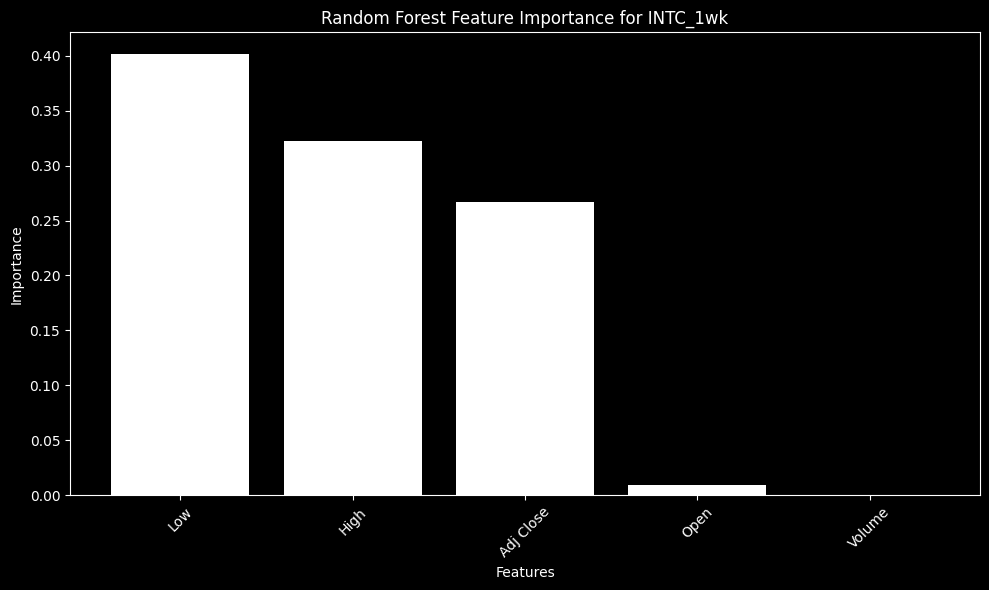

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8085.242, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8081.680, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8083.574, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8083.569, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8079.787, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.970 seconds
ARIMA - Mean Squared Error: 233.7021


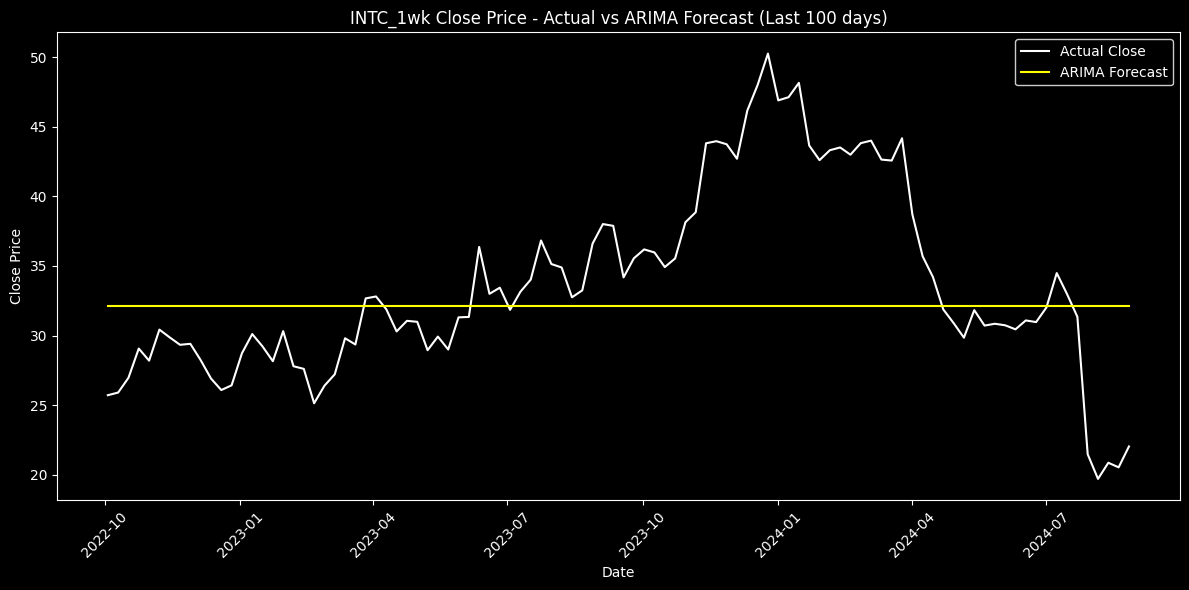


Analyzing SPY_1wk
Random Forest - Mean Squared Error: 5.0668
Random Forest - R-squared Score: 0.9996

Random Forest Feature Importance:
  feature  importance
Adj Close    0.506792
      Low    0.185345
     Open    0.157948
     High    0.149873
   Volume    0.000043


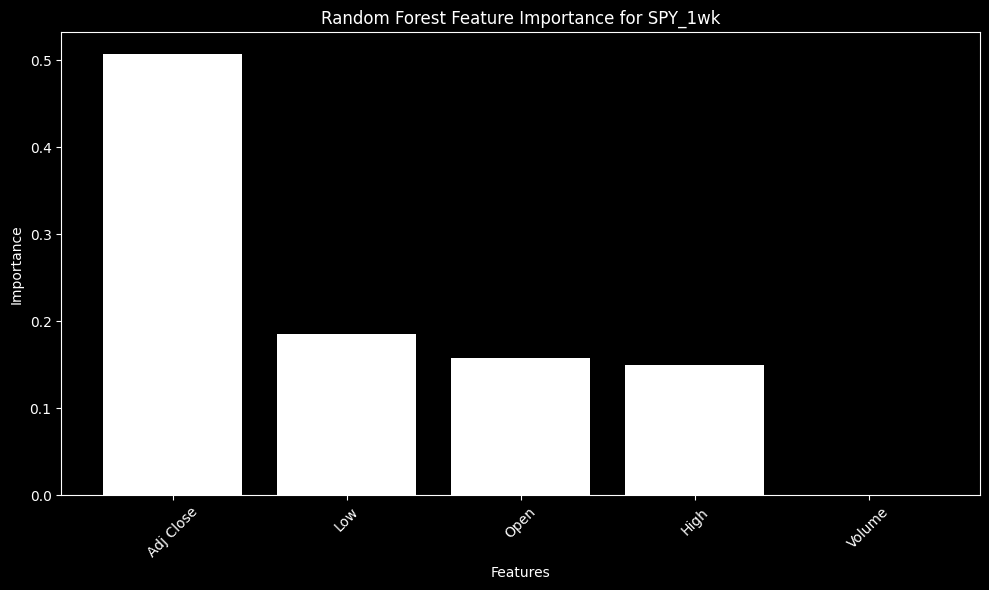

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9888.895, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9890.390, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9888.167, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9888.361, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9895.036, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9889.216, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9890.894, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9893.505, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.485 seconds
ARIMA - Mean Squared Error: 10863.5401


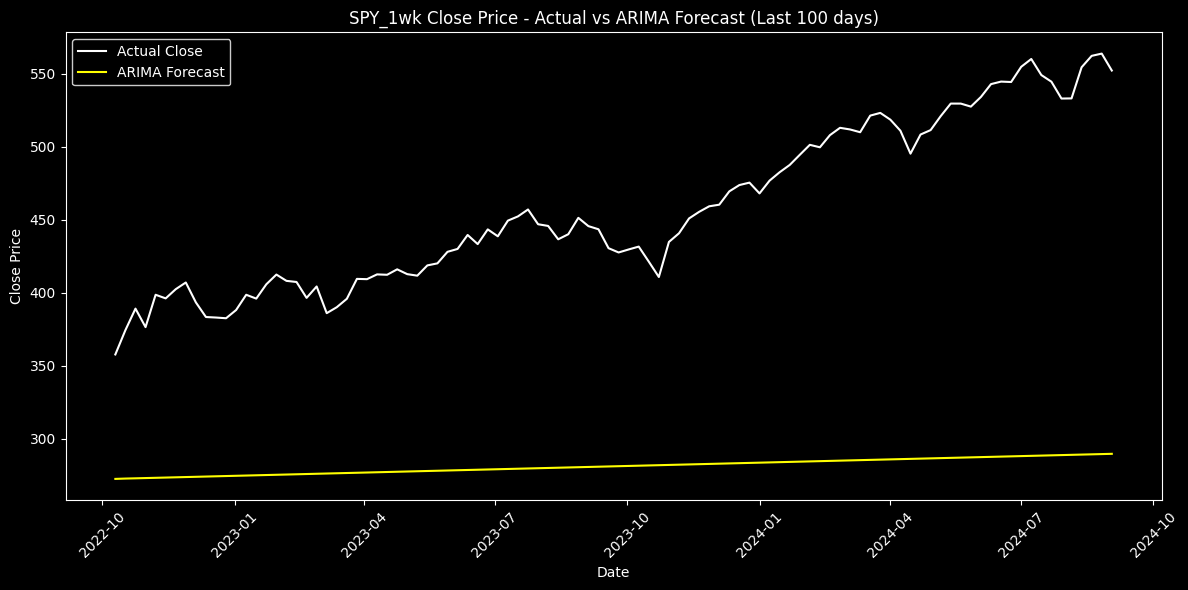


Analyzing AMD_1wk
Random Forest - Mean Squared Error: 0.2158
Random Forest - R-squared Score: 0.9997

Random Forest Feature Importance:
  feature  importance
Adj Close    0.395250
     High    0.214028
      Low    0.200596
     Open    0.190057
   Volume    0.000069


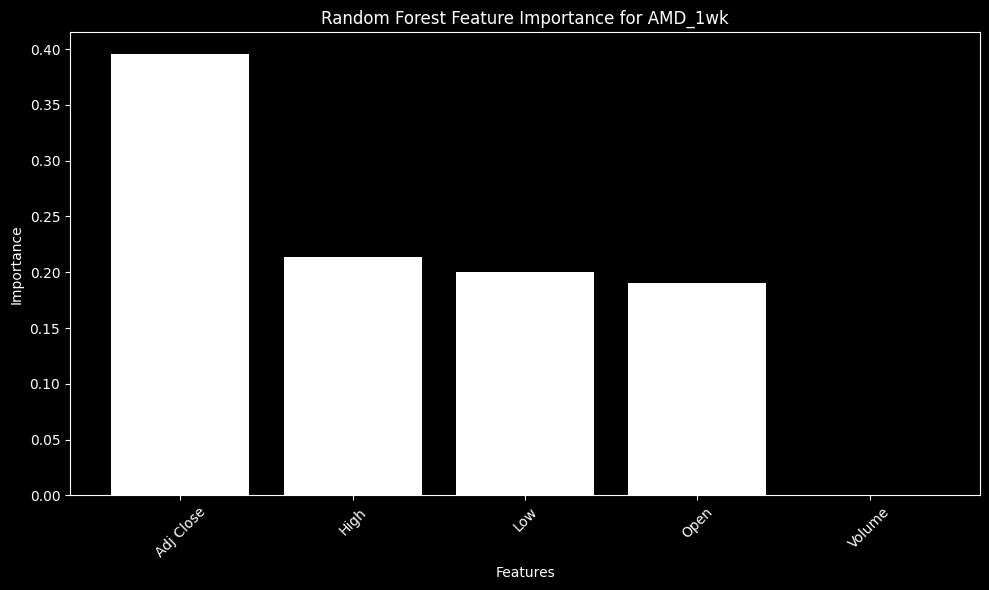

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10929.354, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10945.589, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10937.876, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10936.786, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10944.984, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10930.903, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10930.918, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10931.889, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10933.650, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10929.613, Time=2.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10928.626, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10935.996, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10937.093, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10930.211, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0

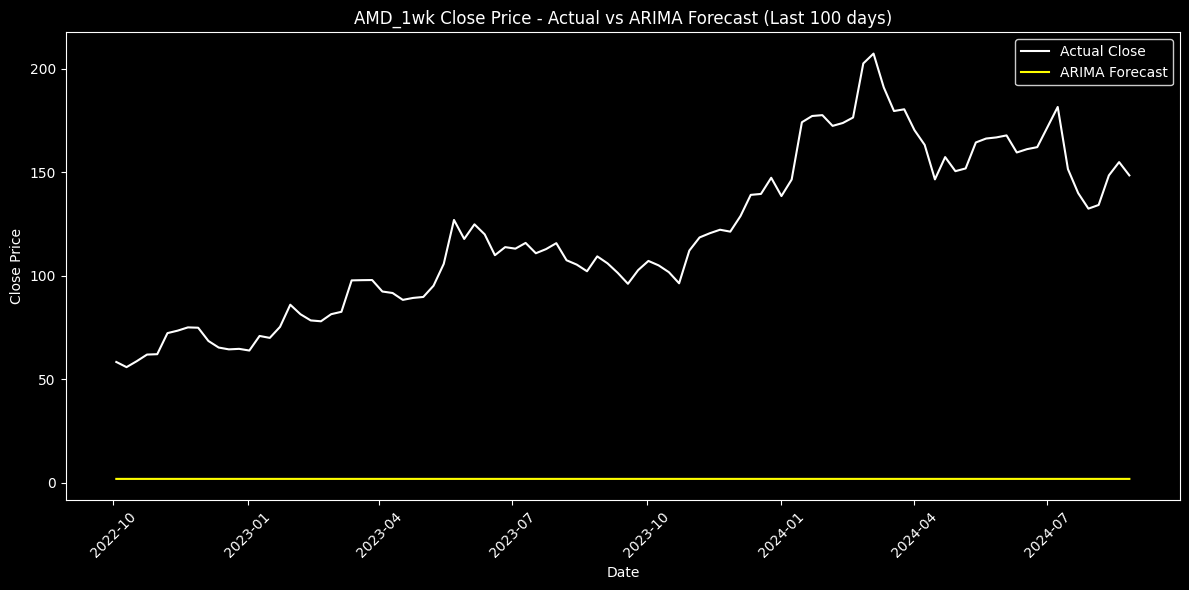


Analyzing QQQ_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


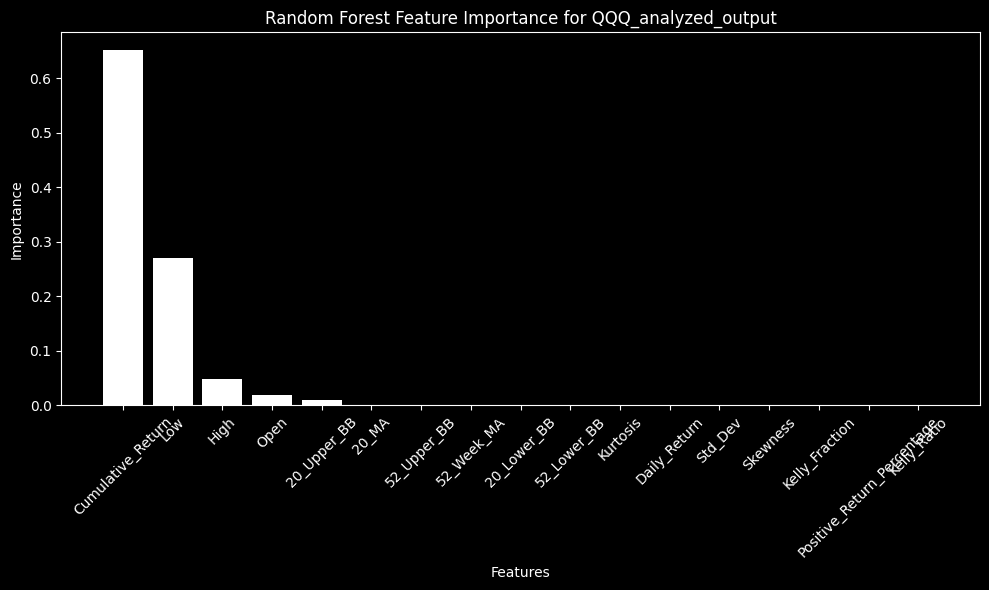

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.502 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

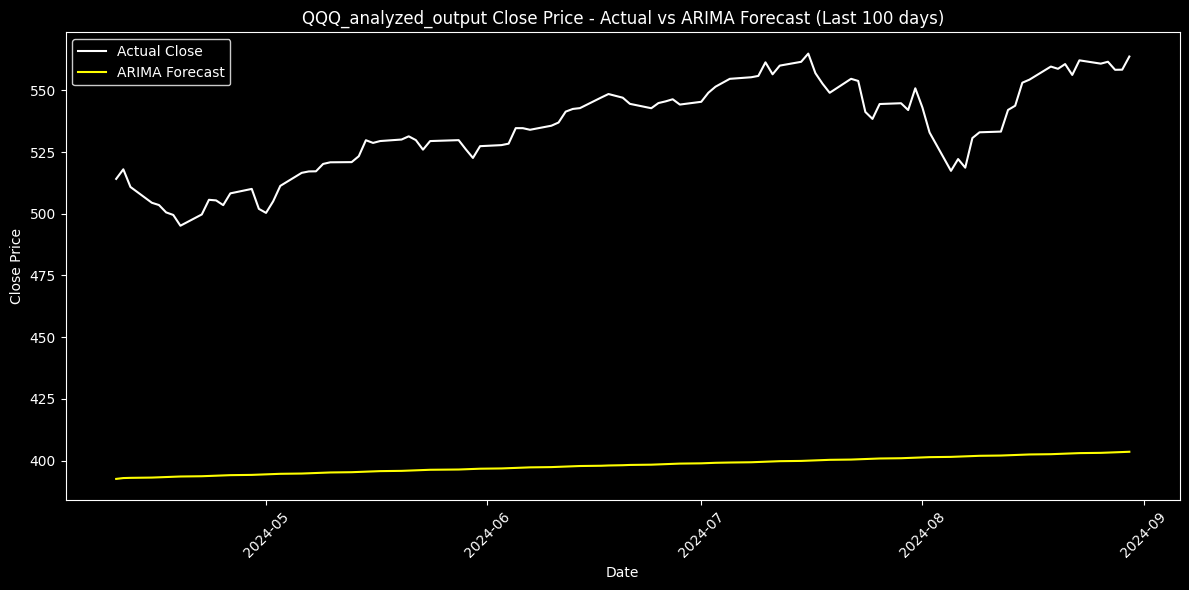


Analyzing NVDA_1wk
Random Forest - Mean Squared Error: 0.5233
Random Forest - R-squared Score: 0.9988

Random Forest Feature Importance:
  feature  importance
Adj Close    0.346434
      Low    0.234614
     High    0.226280
     Open    0.191450
   Volume    0.001222


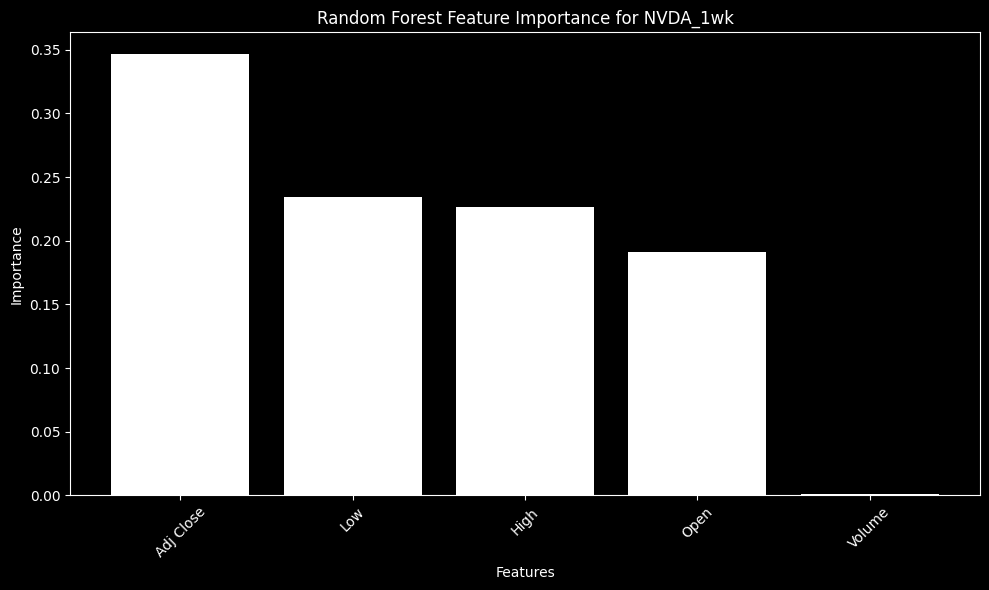

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4395.097, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4474.707, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4450.055, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4446.311, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4479.102, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4392.303, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4447.876, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4435.222, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4374.951, Time=1.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4392.519, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4376.474, Time=2.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4394.110, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4

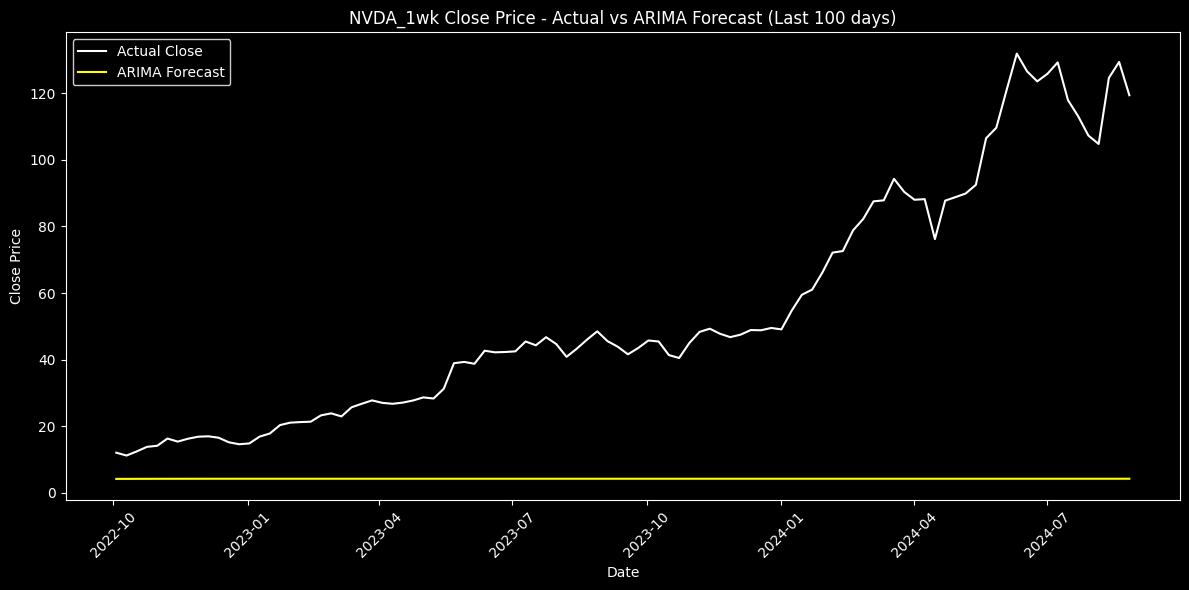


Analyzing UPRO_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


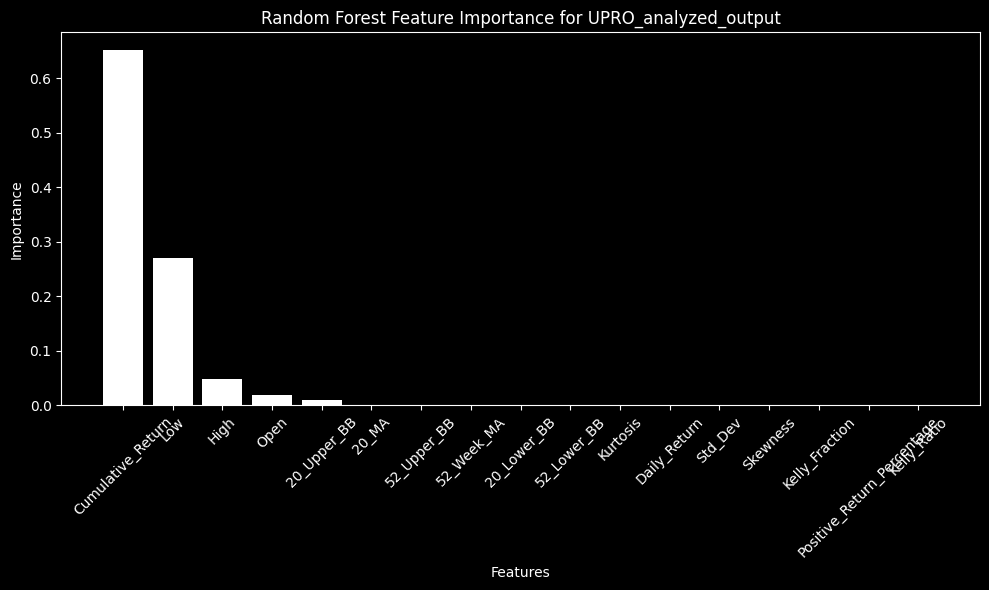

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.154 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

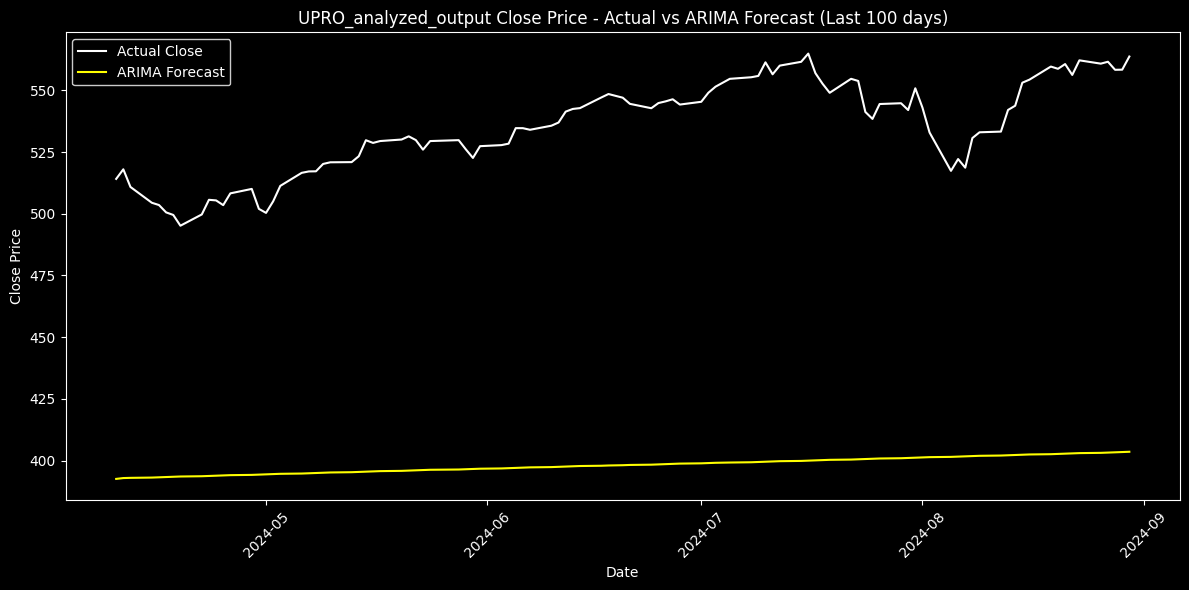


Analyzing SQQQ_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


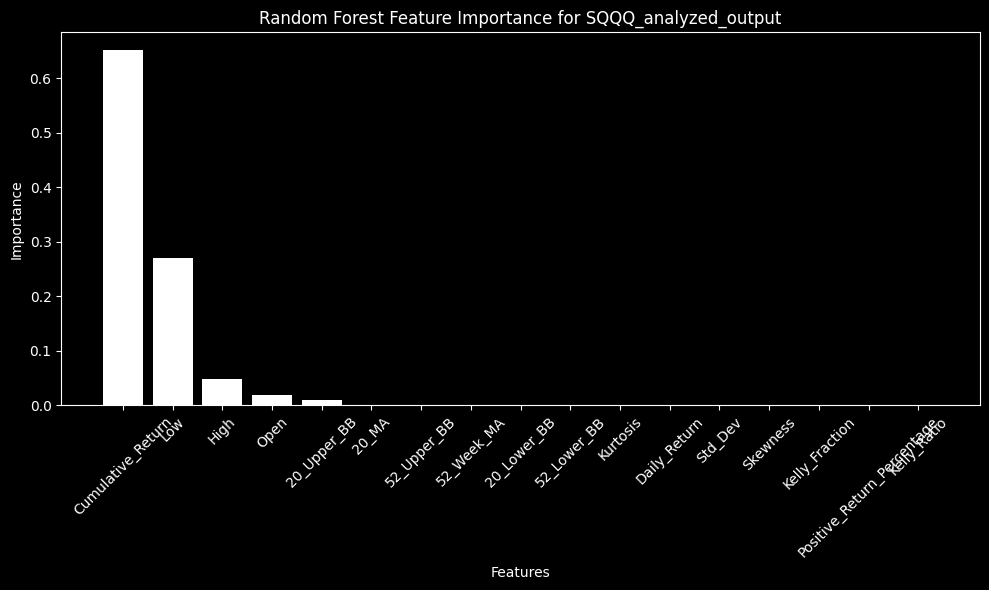

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.188 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

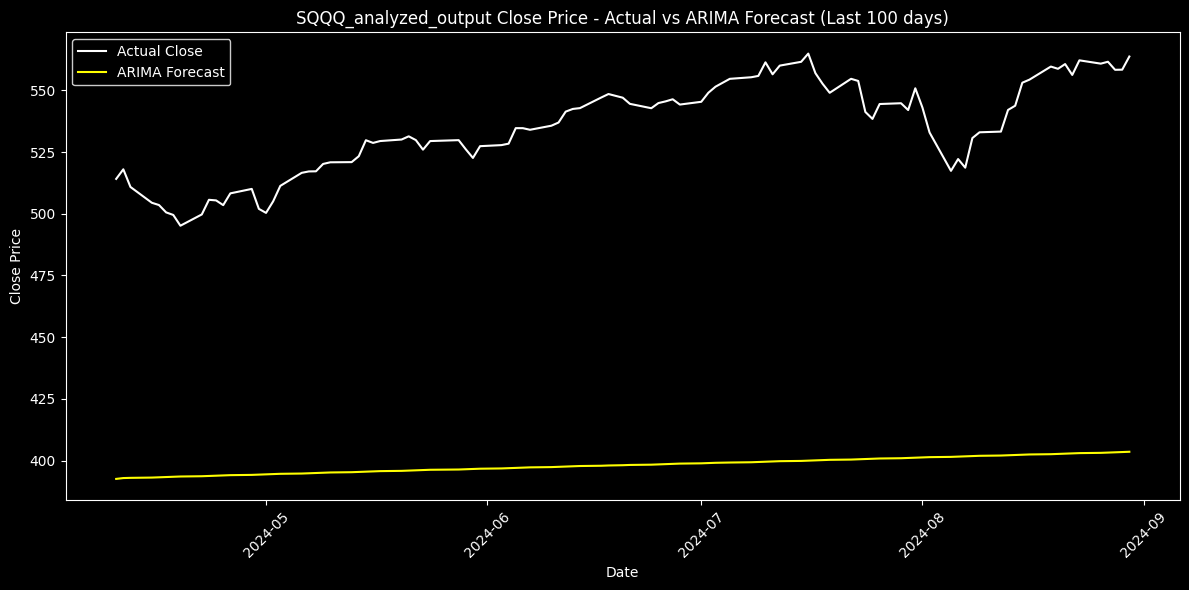


Analyzing PSQ_analyzed_output
Random Forest - Mean Squared Error: 0.1560
Random Forest - R-squared Score: 1.0000

Random Forest Feature Importance:
                   feature   importance
         Cumulative_Return 6.518696e-01
                       Low 2.709049e-01
                      High 4.849298e-02
                      Open 1.773840e-02
               20_Upper_BB 9.197462e-03
                     20_MA 6.591104e-04
               52_Upper_BB 5.489835e-04
                52_Week_MA 3.577598e-04
               20_Lower_BB 1.883317e-04
               52_Lower_BB 3.275577e-05
                  Kurtosis 1.707923e-06
              Daily_Return 1.691865e-06
                   Std_Dev 1.637702e-06
                  Skewness 1.500419e-06
            Kelly_Fraction 1.207207e-06
Positive_Return_Percentage 1.193956e-06
               Kelly_Ratio 7.644398e-07


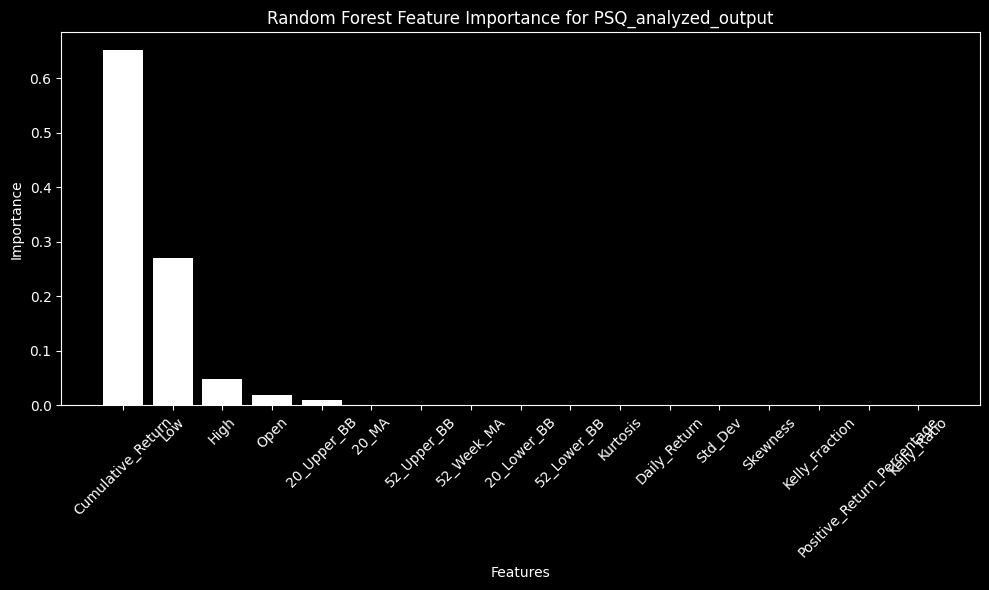

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12393.355, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12403.022, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.881, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12393.539, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12405.217, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12393.222, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12395.115, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12395.716, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.112 seconds
ARIMA - Mean Squared Error: 3365.3713


/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drc/miniconda/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

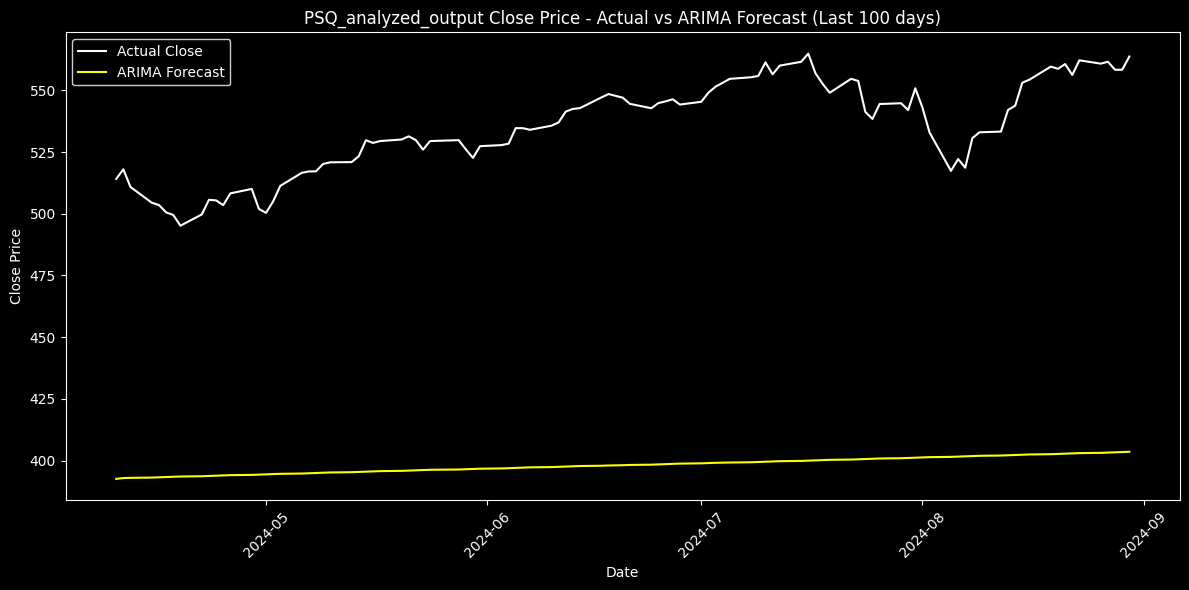


Summary Statistics for NVDA_1mo:
             Open        High         Low       Close   Adj Close        Volume
count  307.000000  307.000000  307.000000  307.000000  307.000000  3.070000e+02
mean     6.408374    7.361760    5.783635    6.766922    6.740131  1.269032e+10
std     16.717386   19.511957   14.979000   17.815707   17.818539  6.295433e+09
min      0.035417    0.039844    0.033333    0.035547    0.032605  1.767024e+09
25%      0.275292    0.321041    0.233875    0.280916    0.257664  8.120261e+09
50%      0.462750    0.493250    0.420750    0.463500    0.437542  1.152937e+10
75%      4.281500    4.623375    3.753750    4.227000    4.189029  1.565716e+10
max    123.470001  140.759995  112.002998  123.540001  123.529854  3.728180e+10

Summary Statistics for SPY_analyzed_output:
              Open         High          Low        Close        20_MA   52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return      Std_Dev     Skewness     Ku

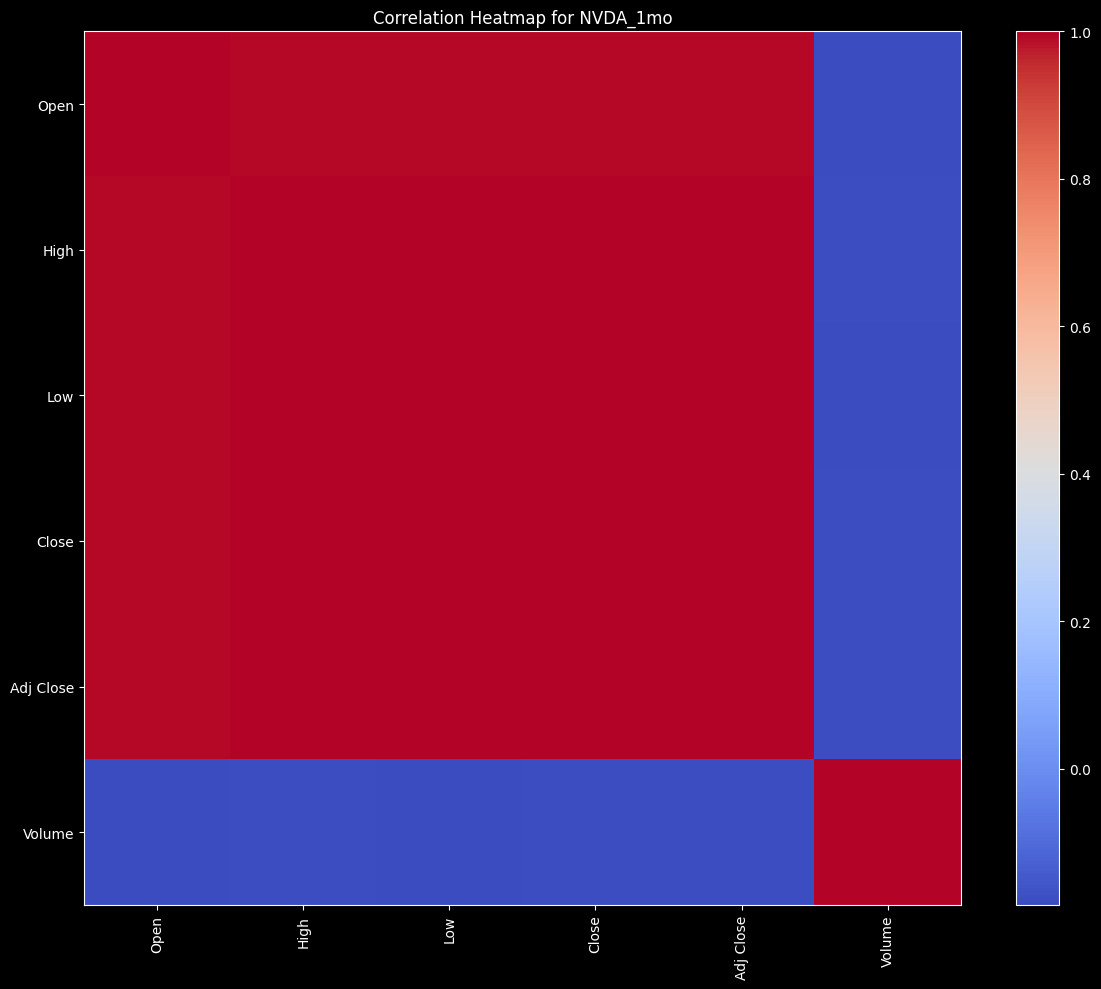


Correlation Matrix for SPY_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.99976

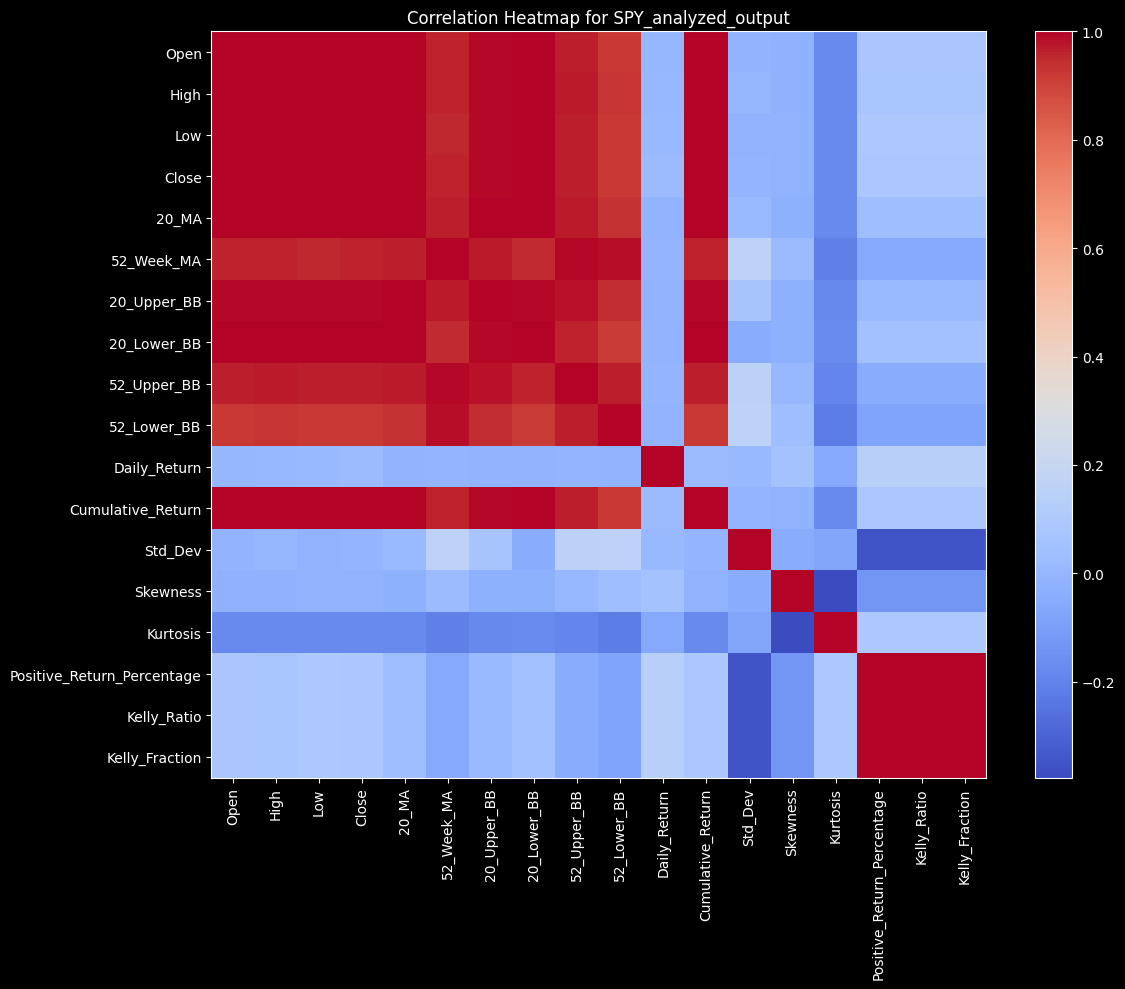


Correlation Matrix for INTC_1mo:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.995235  0.989856  0.983619   0.949054 -0.477085
High       0.995235  1.000000  0.990825  0.991097   0.950731 -0.465193
Low        0.989856  0.990825  1.000000  0.994872   0.962595 -0.504719
Close      0.983619  0.991097  0.994872  1.000000   0.961201 -0.487096
Adj Close  0.949054  0.950731  0.962595  0.961201   1.000000 -0.548143
Volume    -0.477085 -0.465193 -0.504719 -0.487096  -0.548143  1.000000


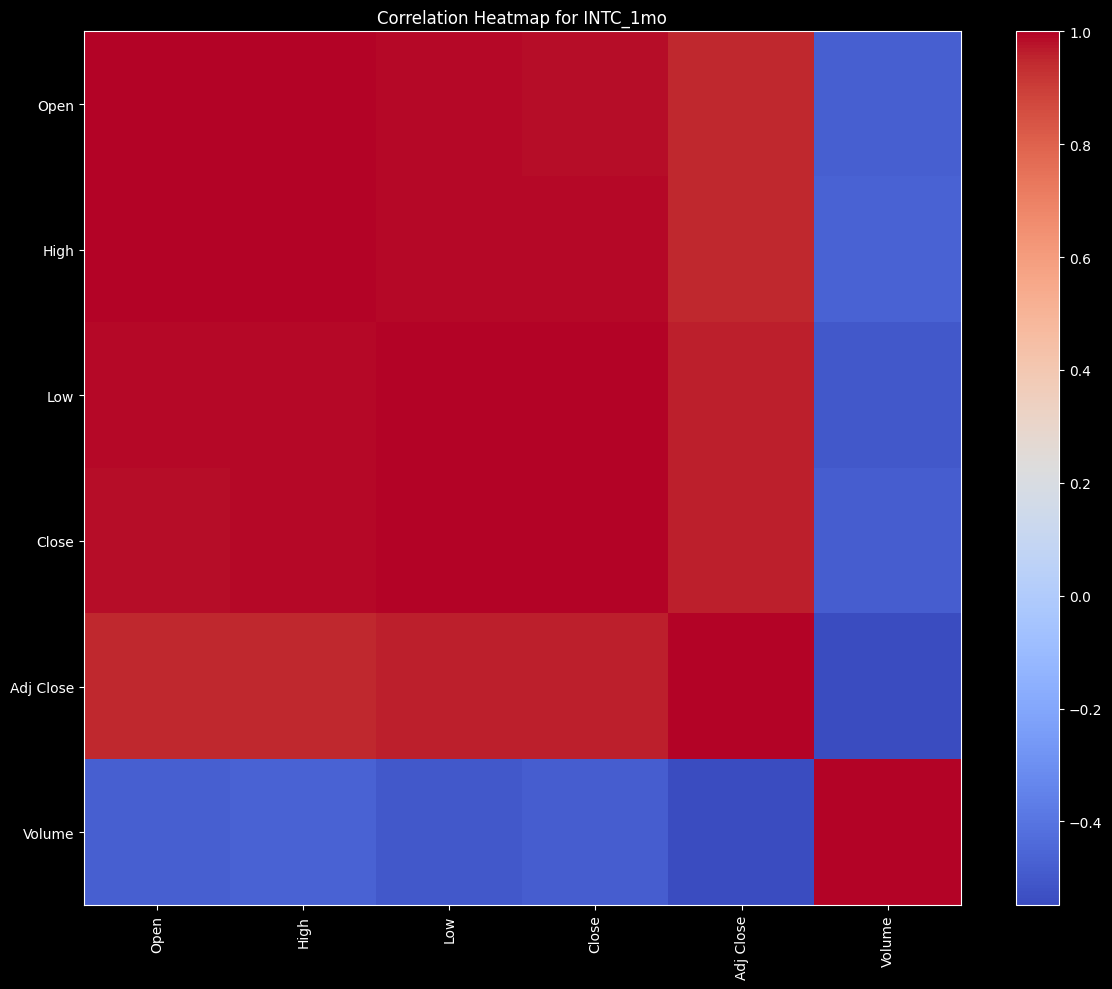


Correlation Matrix for SPI_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.99976

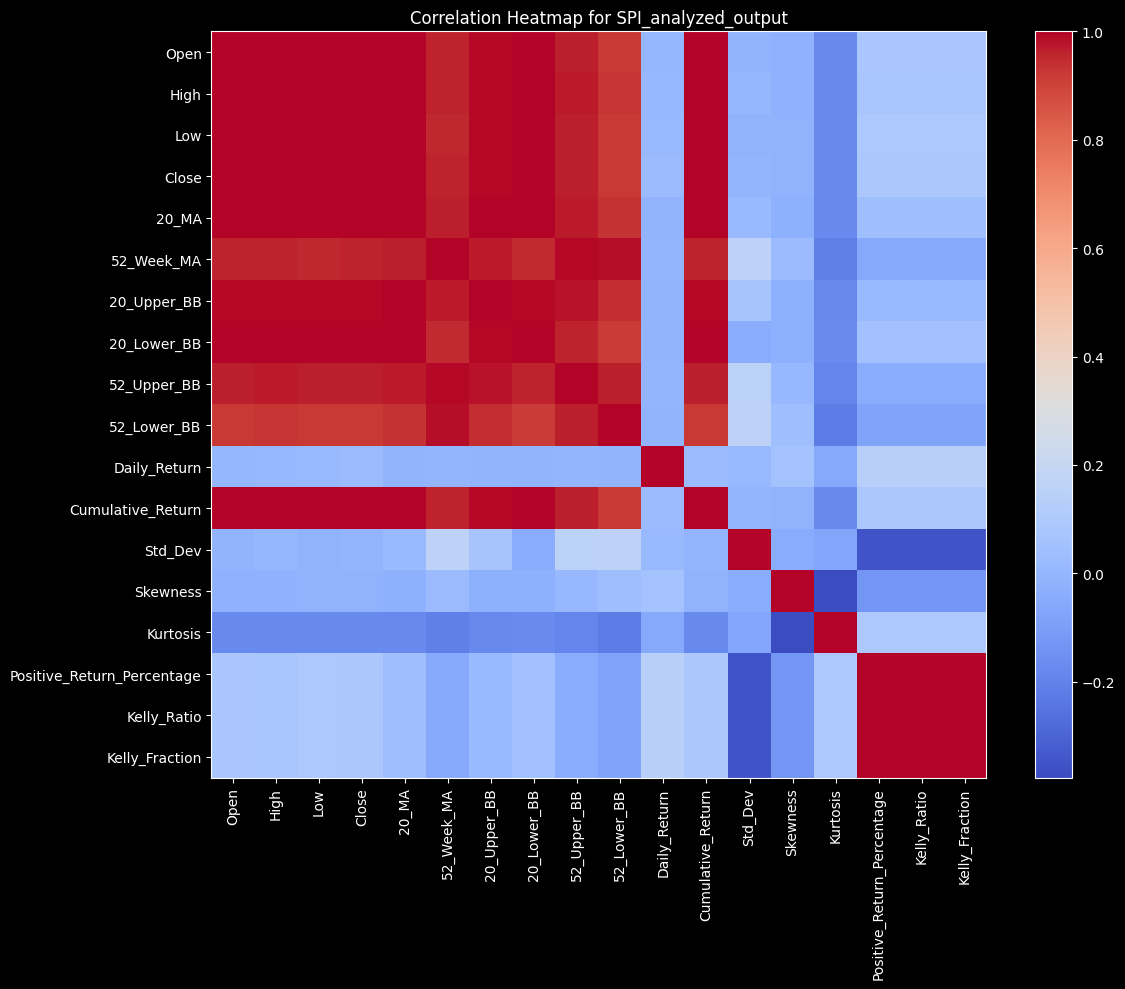


Correlation Matrix for AMD_1mo:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.993641  0.994154  0.984224   0.984224  0.573731
High       0.993641  1.000000  0.994529  0.994492   0.994492  0.585066
Low        0.994154  0.994529  1.000000  0.993712   0.993712  0.572337
Close      0.984224  0.994492  0.993712  1.000000   1.000000  0.578620
Adj Close  0.984224  0.994492  0.993712  1.000000   1.000000  0.578620
Volume     0.573731  0.585066  0.572337  0.578620   0.578620  1.000000


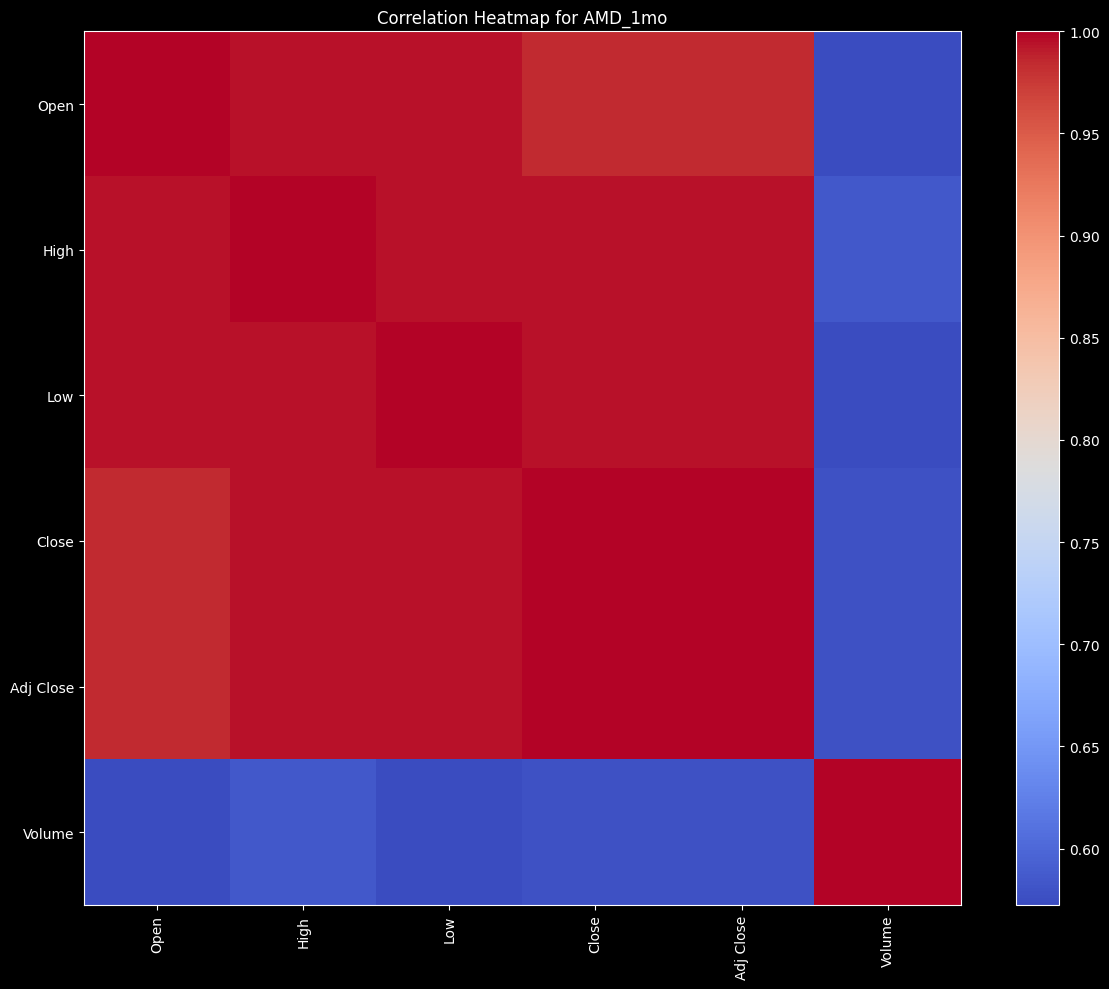


Correlation Matrix for SPXS_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.9997

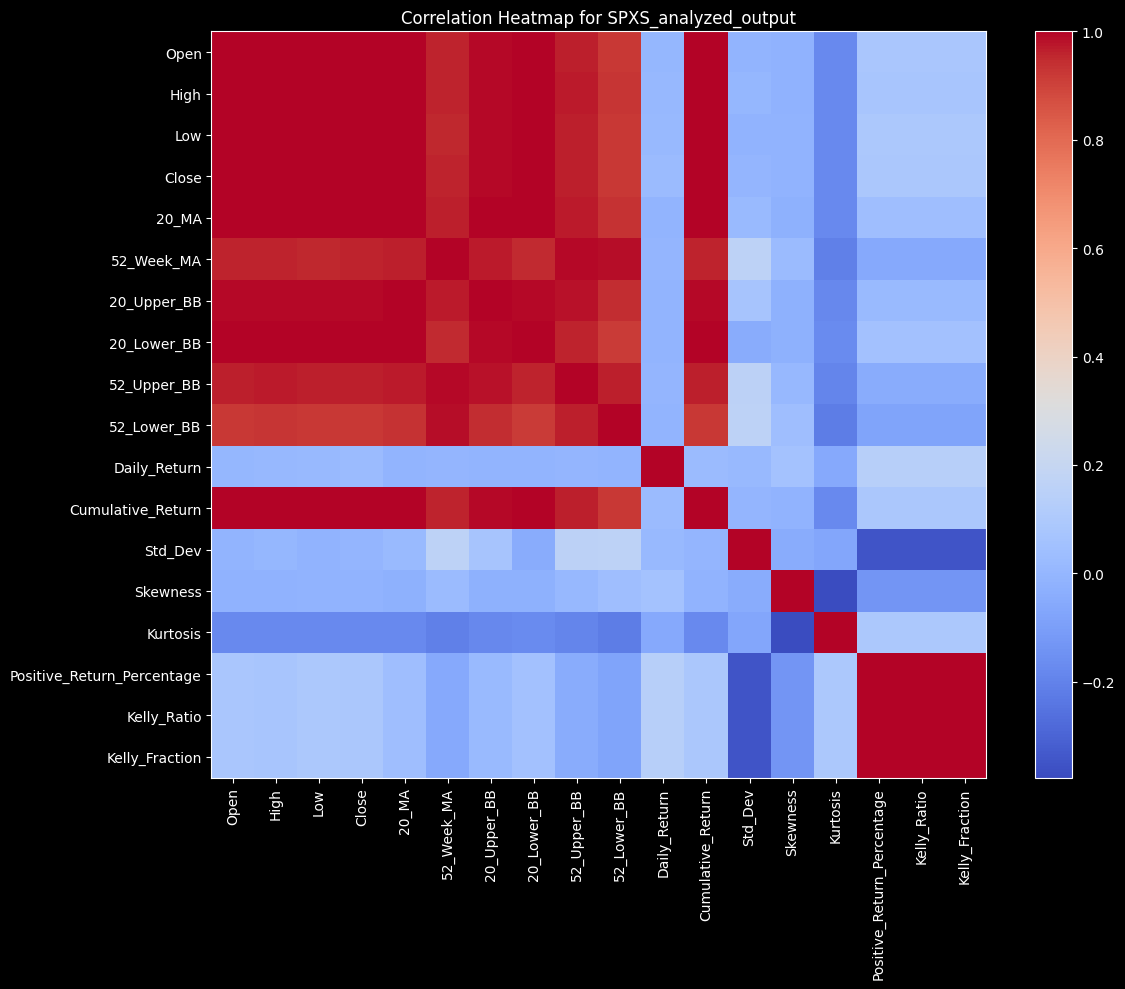


Correlation Matrix for NVDA_1d:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999864  0.999780  0.999559   0.999558 -0.124681
High       0.999864  1.000000  0.999784  0.999774   0.999774 -0.123814
Low        0.999780  0.999784  1.000000  0.999846   0.999845 -0.125946
Close      0.999559  0.999774  0.999846  1.000000   1.000000 -0.124980
Adj Close  0.999558  0.999774  0.999845  1.000000   1.000000 -0.125013
Volume    -0.124681 -0.123814 -0.125946 -0.124980  -0.125013  1.000000


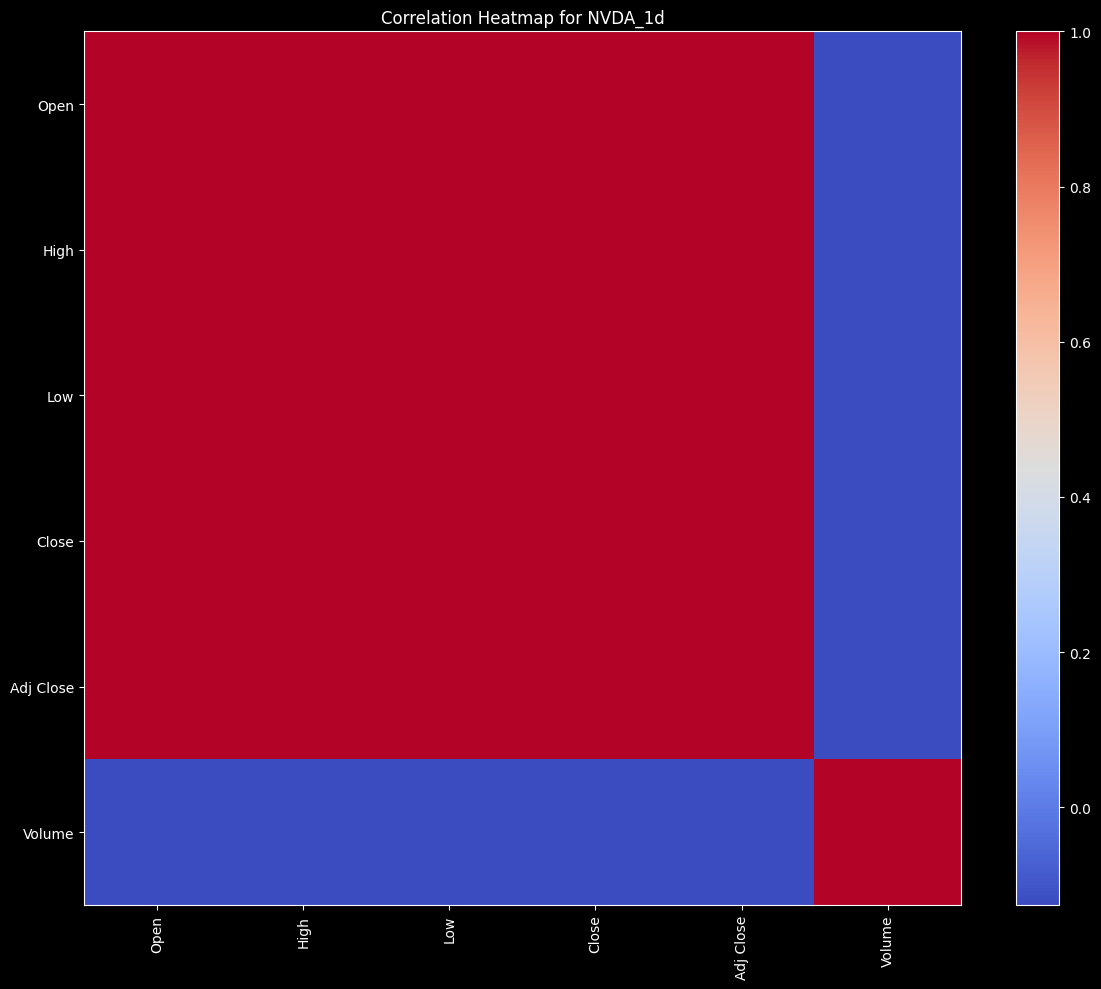


Correlation Matrix for AMD_1d:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999051  0.999023  0.998721   0.998721  0.536803
High       0.999051  1.000000  0.999724  0.999750   0.999750  0.536672
Low        0.999023  0.999724  1.000000  0.999774   0.999774  0.531006
Close      0.998721  0.999750  0.999774  1.000000   1.000000  0.534071
Adj Close  0.998721  0.999750  0.999774  1.000000   1.000000  0.534071
Volume     0.536803  0.536672  0.531006  0.534071   0.534071  1.000000


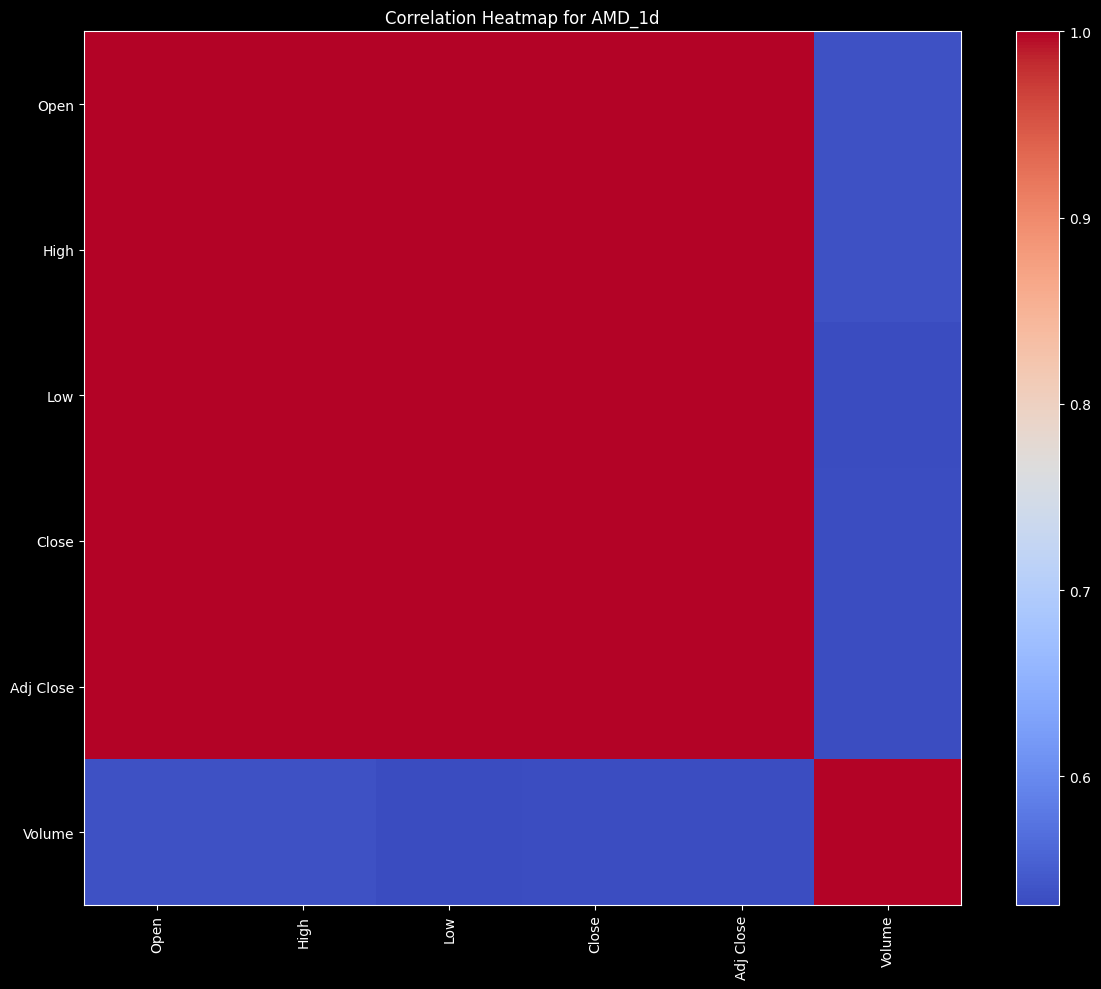


Correlation Matrix for TQQQ_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.9997

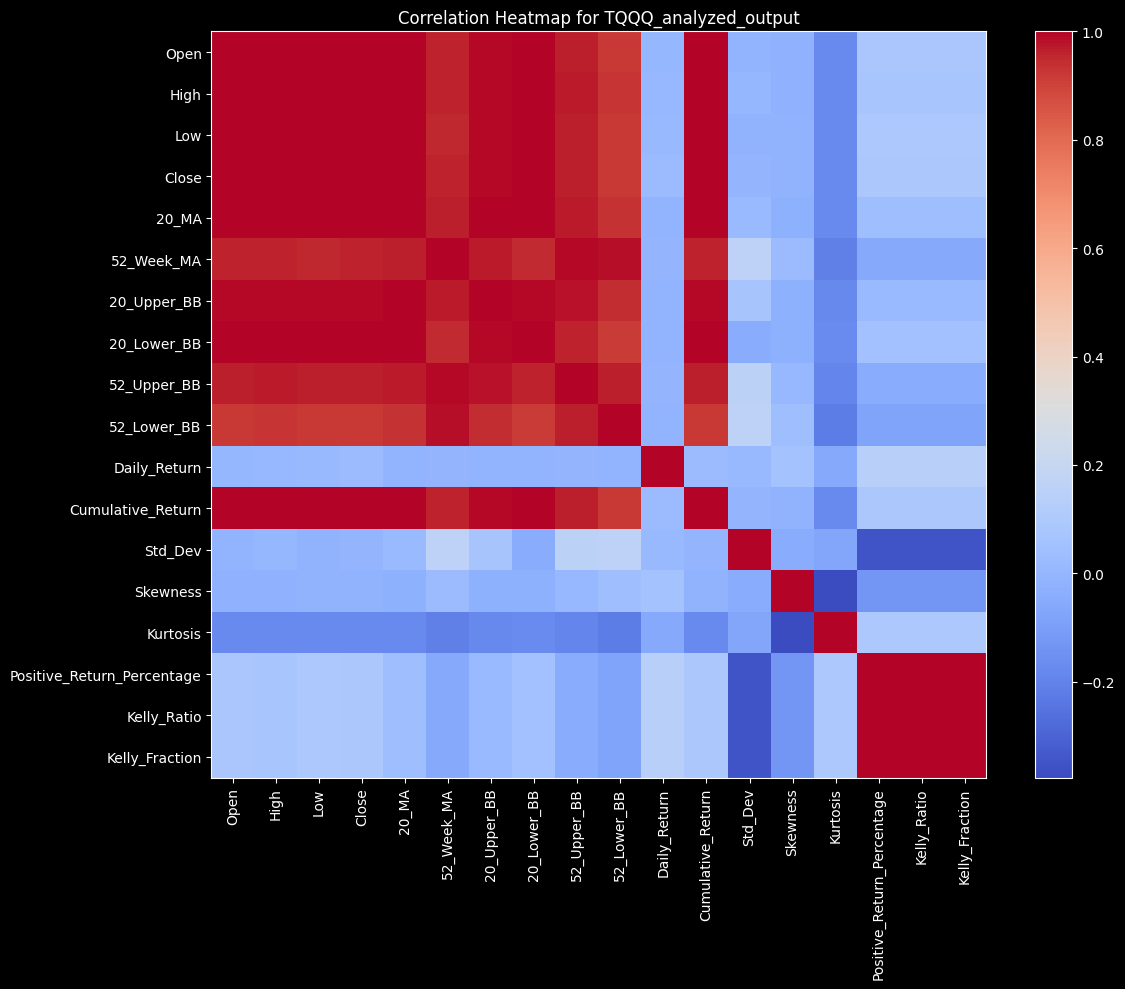


Correlation Matrix for SPY_1mo:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.998989  0.997403  0.996770   0.994491  0.073067
High       0.998989  1.000000  0.997505  0.998349   0.996159  0.072442
Low        0.997403  0.997505  1.000000  0.998495   0.995988  0.052656
Close      0.996770  0.998349  0.998495  1.000000   0.997635  0.061053
Adj Close  0.994491  0.996159  0.995988  0.997635   1.000000  0.070241
Volume     0.073067  0.072442  0.052656  0.061053   0.070241  1.000000


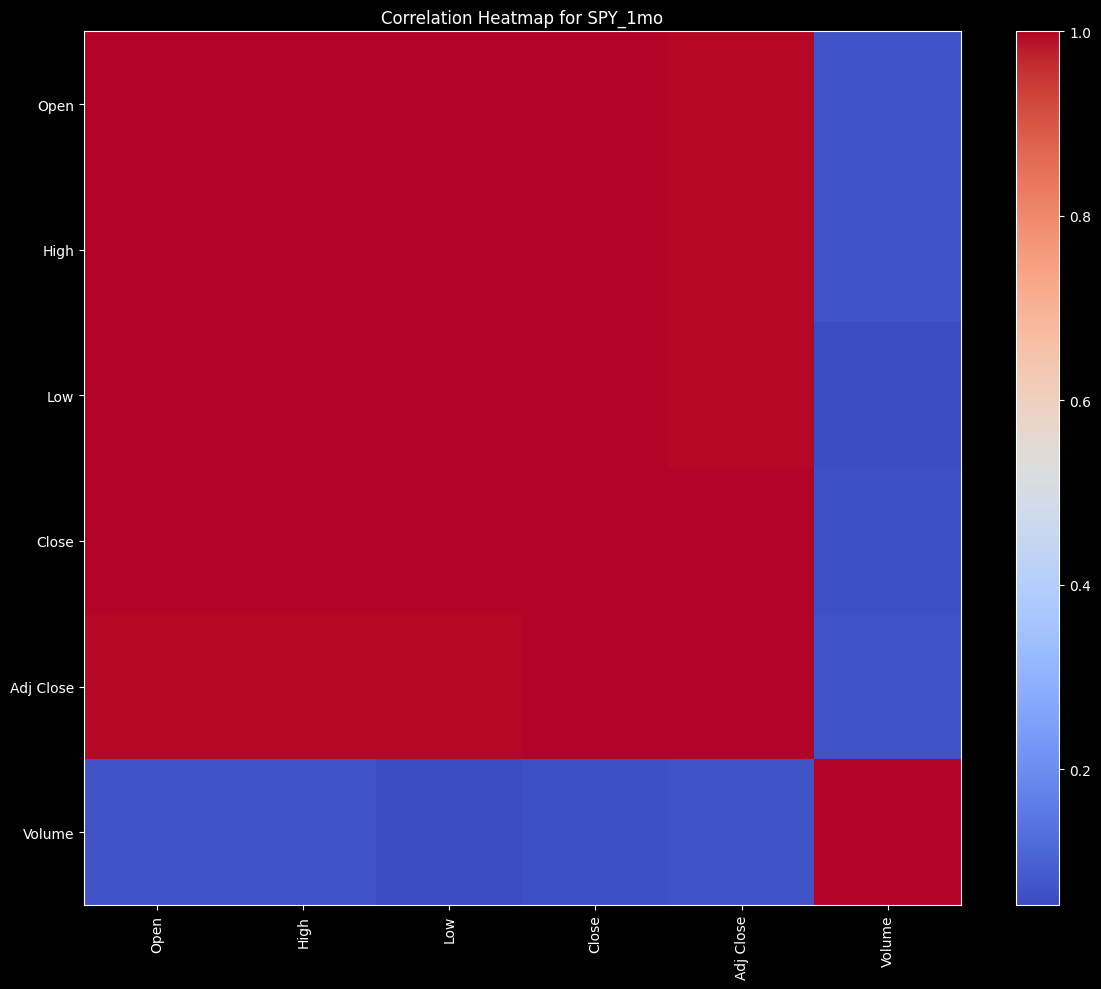


Correlation Matrix for SPY_1d:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999946  0.999930  0.999880   0.997393  0.063798
High       0.999946  1.000000  0.999889  0.999926   0.997450  0.066067
Low        0.999930  0.999889  1.000000  0.999935   0.997450  0.060669
Close      0.999880  0.999926  0.999935  1.000000   0.997518  0.063054
Adj Close  0.997393  0.997450  0.997450  0.997518   1.000000  0.072418
Volume     0.063798  0.066067  0.060669  0.063054   0.072418  1.000000


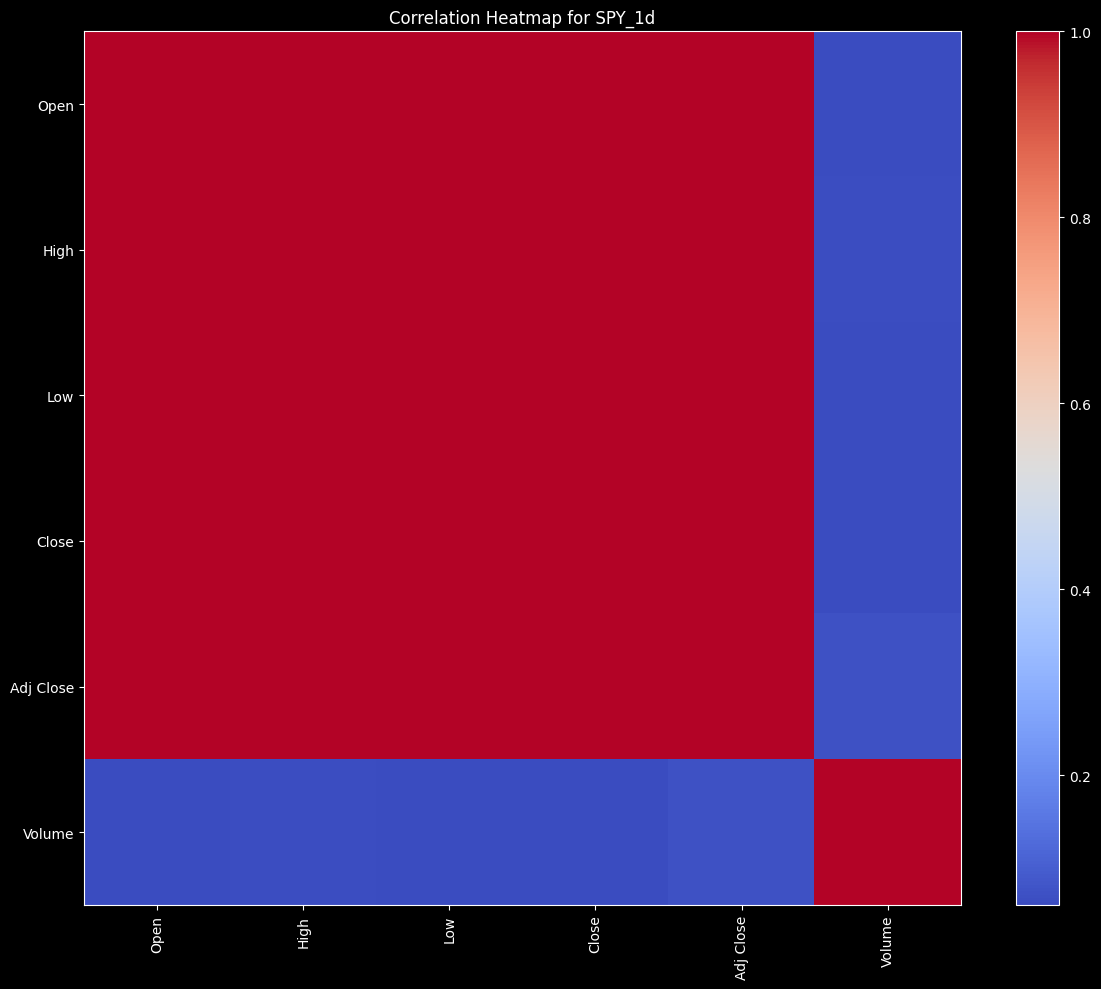


Correlation Matrix for INTC_1d:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999788  0.999786  0.999561   0.964633 -0.163140
High       0.999788  1.000000  0.999675  0.999767   0.963760 -0.159986
Low        0.999786  0.999675  1.000000  0.999786   0.965846 -0.166724
Close      0.999561  0.999767  0.999786  1.000000   0.965129 -0.163451
Adj Close  0.964633  0.963760  0.965846  0.965129   1.000000 -0.219663
Volume    -0.163140 -0.159986 -0.166724 -0.163451  -0.219663  1.000000


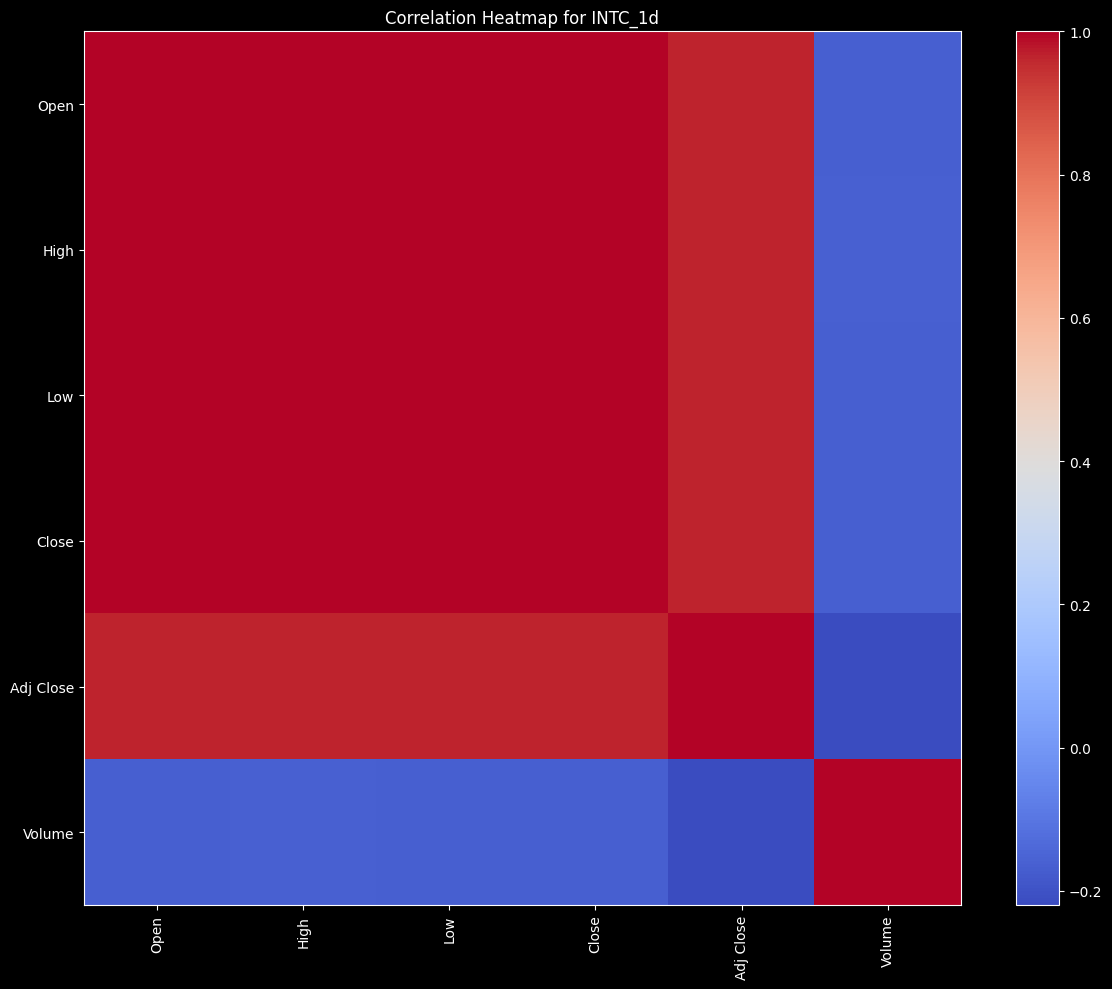


Correlation Matrix for INTC_1wk:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.998779  0.998328  0.997008   0.962642 -0.197757
High       0.998779  1.000000  0.997897  0.998353   0.961670 -0.190276
Low        0.998328  0.997897  1.000000  0.998772   0.966608 -0.209145
Close      0.997008  0.998353  0.998772  1.000000   0.965141 -0.201353
Adj Close  0.962642  0.961670  0.966608  0.965141   1.000000 -0.269010
Volume    -0.197757 -0.190276 -0.209145 -0.201353  -0.269010  1.000000


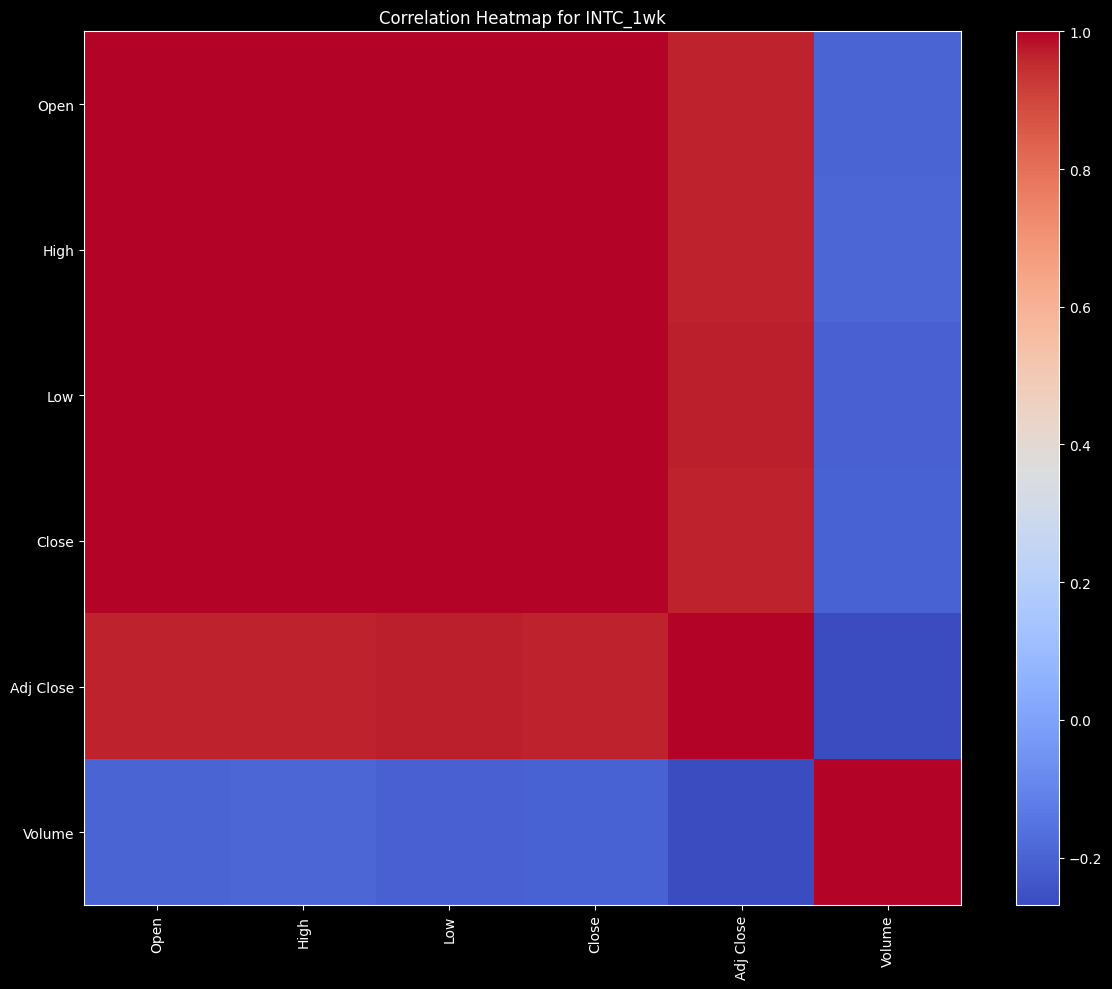


Correlation Matrix for SPY_1wk:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999708  0.999601  0.999287   0.996840  0.066450
High       0.999708  1.000000  0.999437  0.999602   0.997205  0.069694
Low        0.999601  0.999437  1.000000  0.999631   0.997164  0.058452
Close      0.999287  0.999602  0.999631  1.000000   0.997539  0.062708
Adj Close  0.996840  0.997205  0.997164  0.997539   1.000000  0.072332
Volume     0.066450  0.069694  0.058452  0.062708   0.072332  1.000000


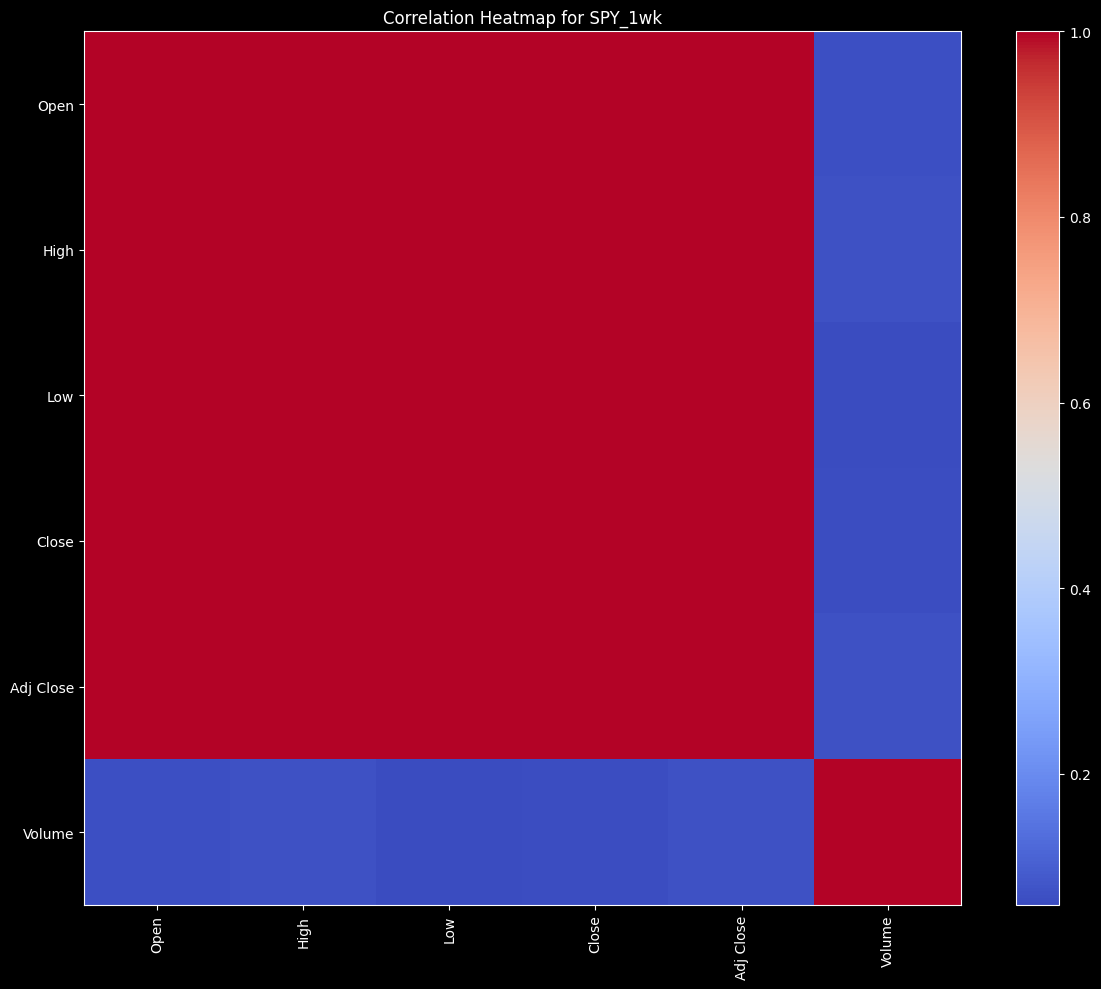


Correlation Matrix for AMD_1wk:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.997929  0.997998  0.995908   0.995908  0.561429
High       0.997929  1.000000  0.998737  0.998667   0.998667  0.565476
Low        0.997998  0.998737  1.000000  0.998604   0.998604  0.555379
Close      0.995908  0.998667  0.998604  1.000000   1.000000  0.560791
Adj Close  0.995908  0.998667  0.998604  1.000000   1.000000  0.560791
Volume     0.561429  0.565476  0.555379  0.560791   0.560791  1.000000


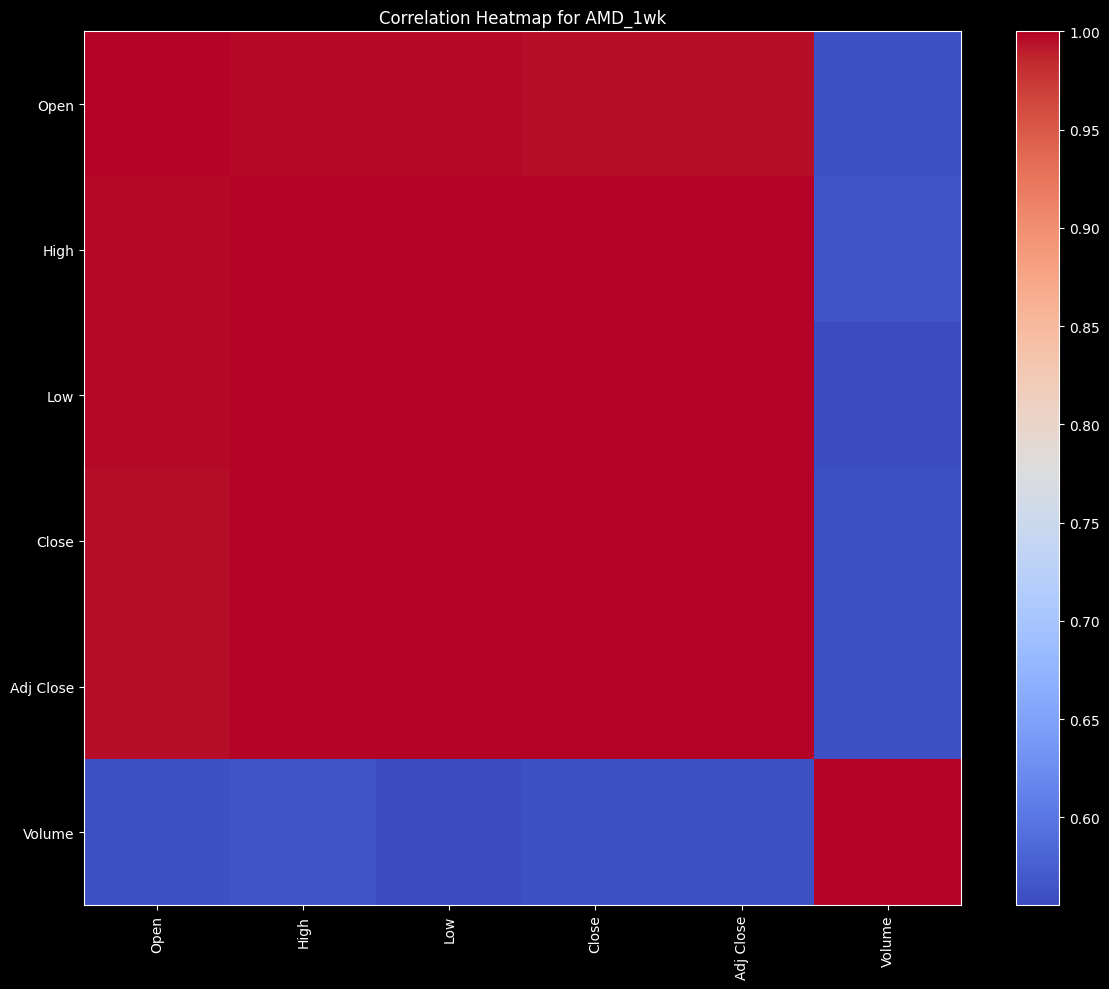


Correlation Matrix for QQQ_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.99976

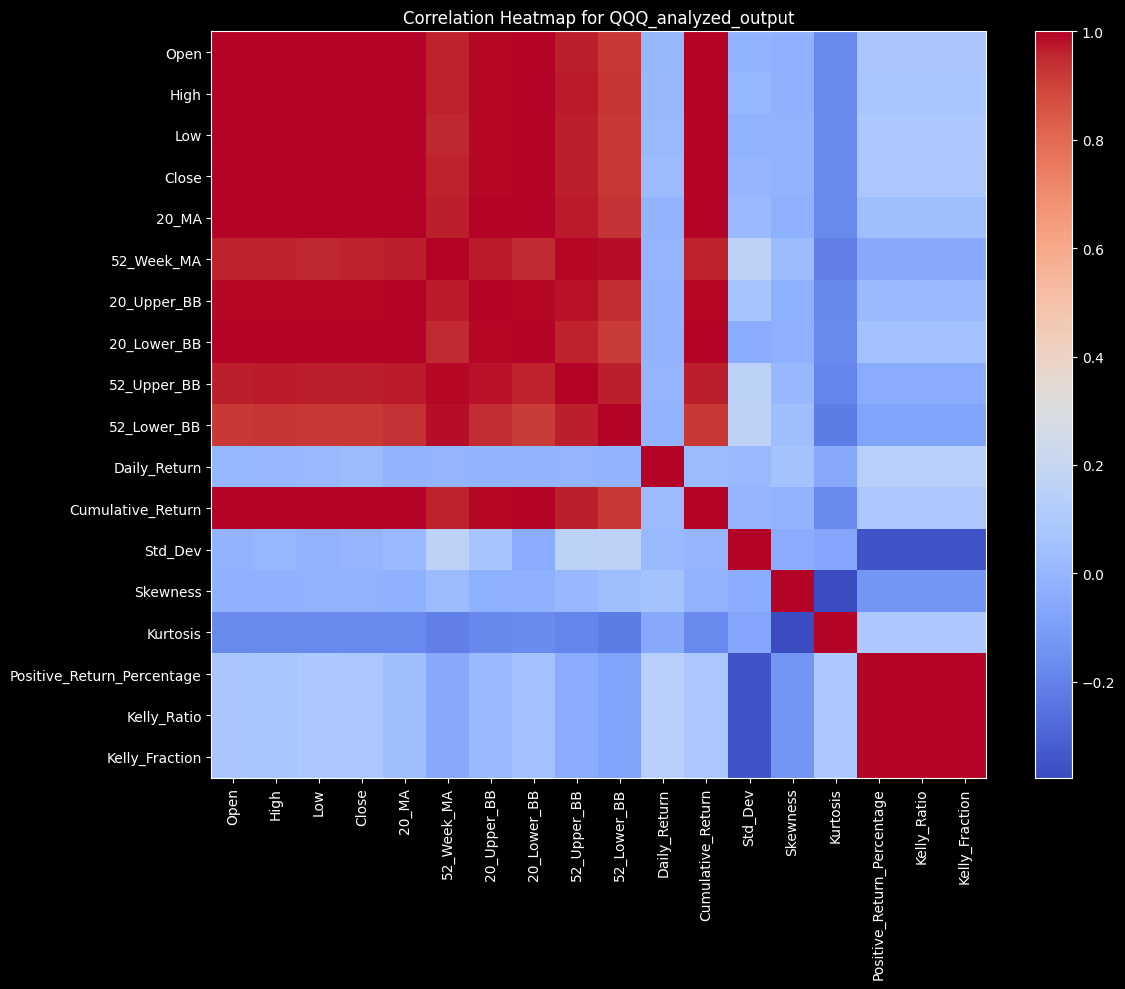


Correlation Matrix for NVDA_1wk:
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.998908  0.999123  0.997392   0.997392 -0.155368
High       0.998908  1.000000  0.999039  0.999077   0.999077 -0.152399
Low        0.999123  0.999039  1.000000  0.998825   0.998824 -0.156798
Close      0.997392  0.999077  0.998825  1.000000   1.000000 -0.154470
Adj Close  0.997392  0.999077  0.998824  1.000000   1.000000 -0.154508
Volume    -0.155368 -0.152399 -0.156798 -0.154470  -0.154508  1.000000


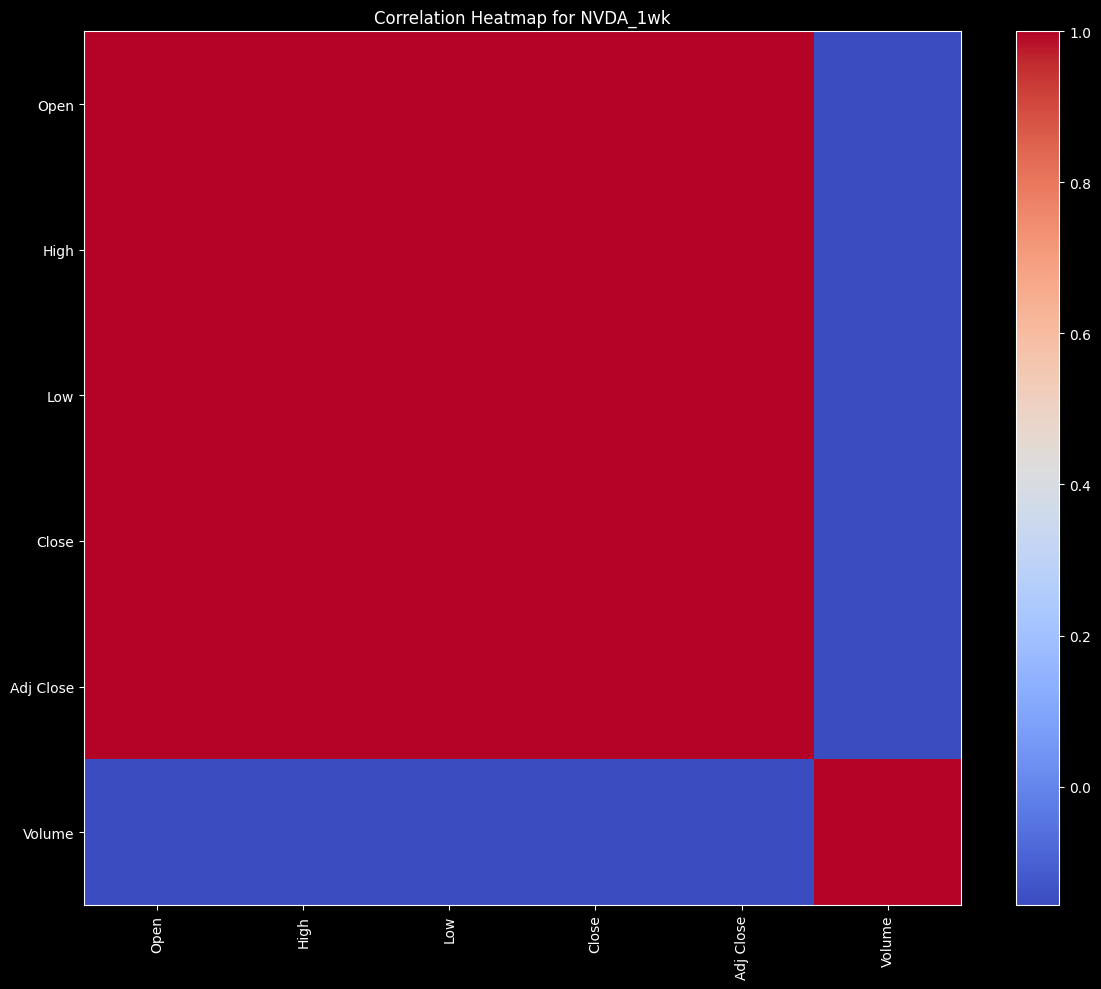


Correlation Matrix for UPRO_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.9997

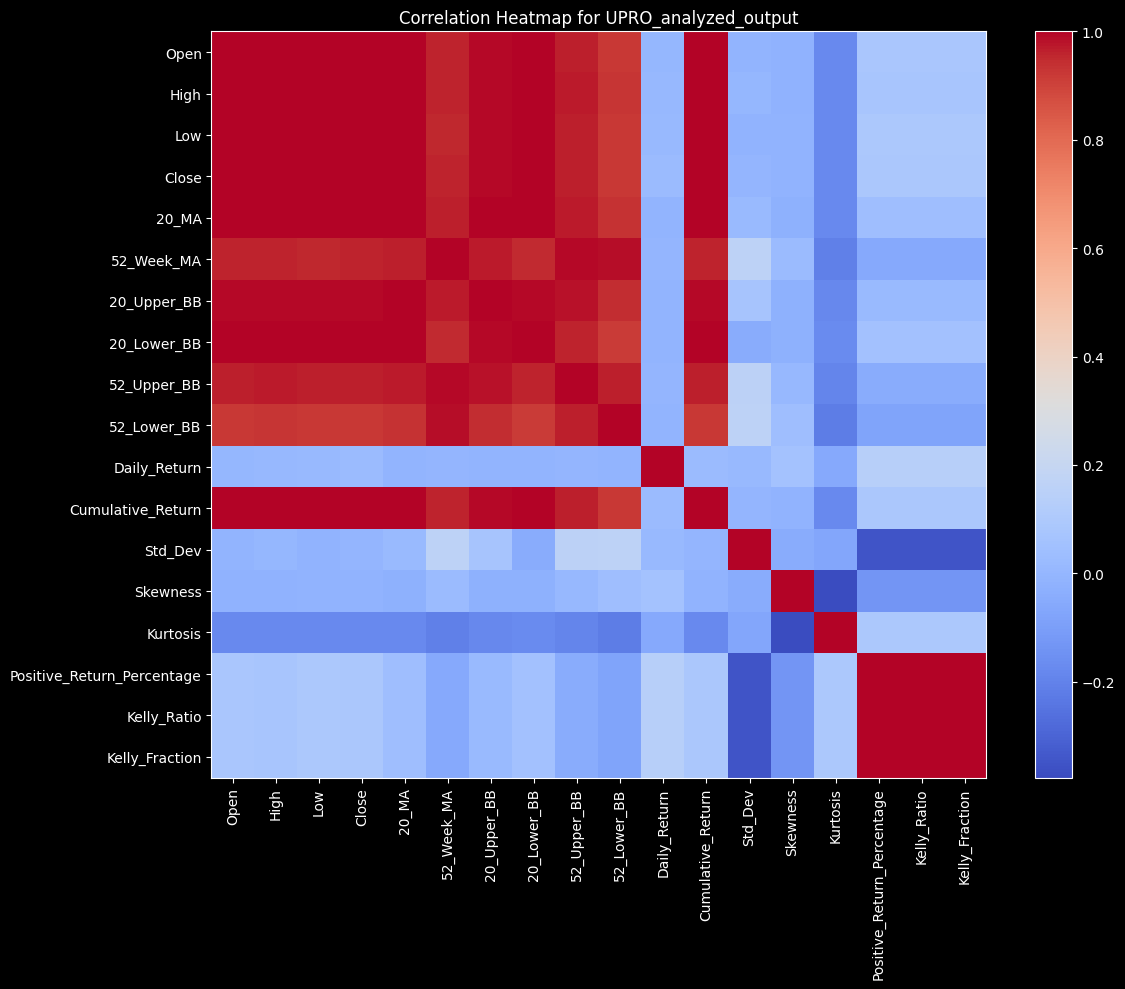


Correlation Matrix for SQQQ_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.9997

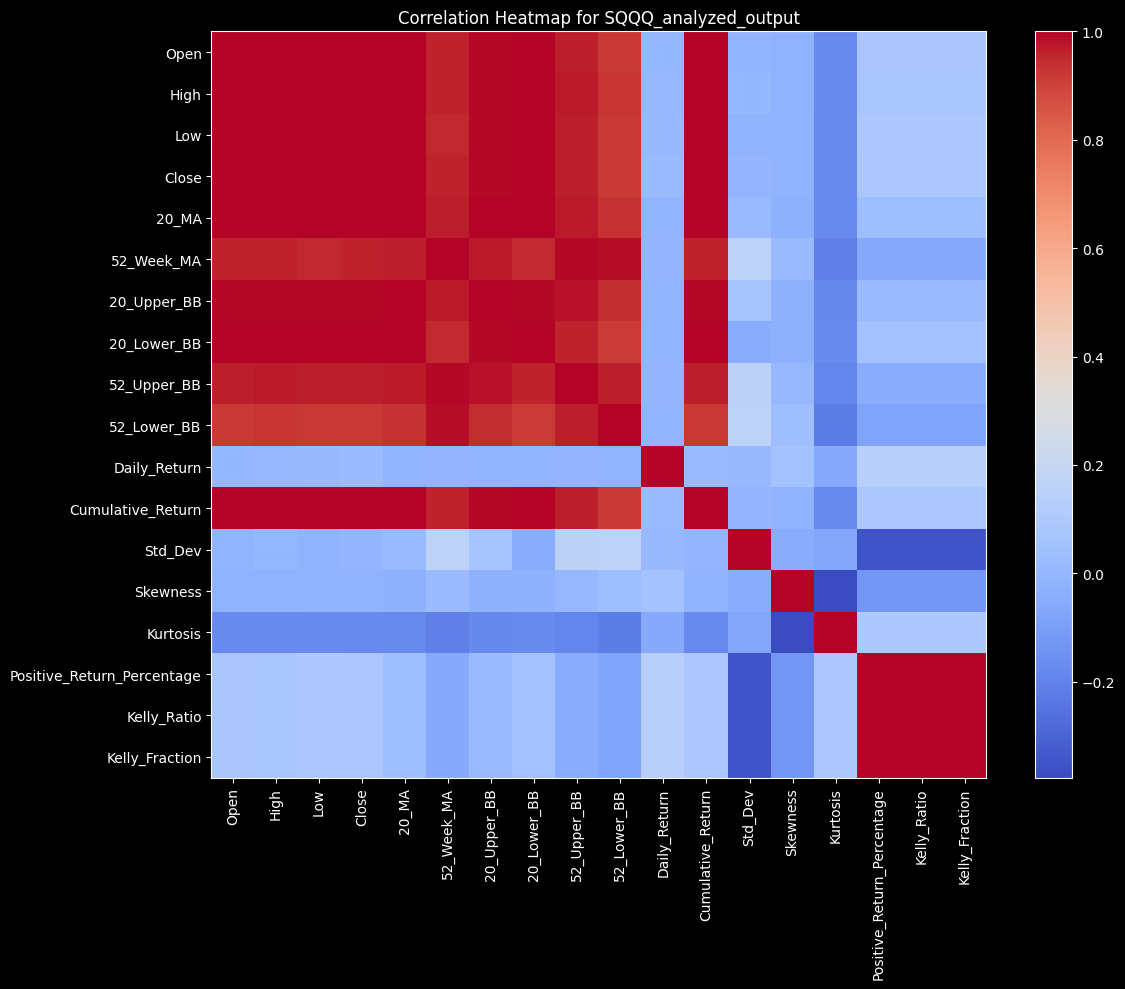


Correlation Matrix for PSQ_analyzed_output:
                                Open      High       Low     Close     20_MA  52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  Daily_Return  Cumulative_Return   Std_Dev  Skewness  Kurtosis  Positive_Return_Percentage  Kelly_Ratio  Kelly_Fraction
Open                        1.000000  0.999805  0.999745  0.999560  0.996220    0.958094     0.991980     0.995357     0.967624     0.923318      0.001814           0.999560 -0.006004 -0.017176 -0.175968                    0.084665     0.084665        0.084665
High                        0.999805  1.000000  0.999593  0.999723  0.996781    0.960295     0.993157     0.995256     0.969690     0.925667      0.008147           0.999723  0.003155 -0.017068 -0.177180                    0.079902     0.079902        0.079902
Low                         0.999745  0.999593  1.000000  0.999764  0.995376    0.955904     0.990607     0.995086     0.965560     0.920991      0.012261           0.99976

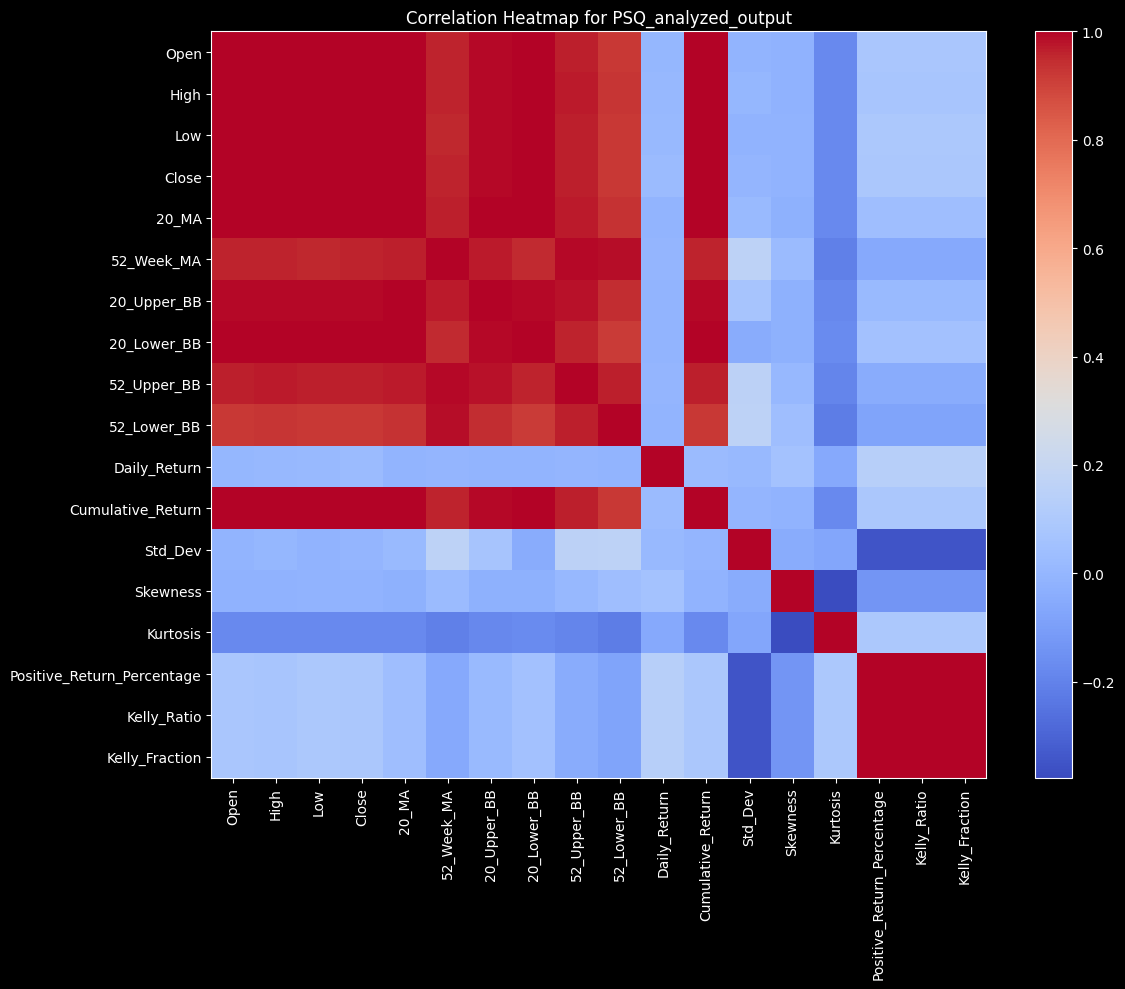


Description of the analysis:
This code performs an exploratory data analysis and initial modeling on stock data for multiple companies.
The main steps are:
1. Loading data from CSV files
2. Preparing the data for modeling by splitting it into training and test sets
3. Training a Random Forest Regressor to predict the Close price based on available features
4. Training an ARIMA model to forecast Close prices
5. Evaluating model performance using Mean Squared Error and R-squared score
6. Analyzing feature importance for the Random Forest model
7. Plotting actual vs predicted Close prices using the ARIMA model
8. Generating summary statistics and correlation matrices for each dataset

The target variable for the forecast is the 'Close' price. The Random Forest model uses all available features to predict Close, while the ARIMA model uses historical Close prices for forecasting.
This analysis works with the available data, providing insights into price predictions and the relationships be

In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Read CSV files from raw_data directory
raw_data_dir = 'raw_data'
csv_files = [f for f in os.listdir(raw_data_dir) if f.endswith('.csv')]

data_dict = {}
for file in csv_files:
    symbol = file.split('.')[0]
    df = pd.read_csv(os.path.join(raw_data_dir, file))
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    data_dict[symbol] = df

# Function to prepare data for modeling
def prepare_data(df, target='Close', features=None):
    if features is None:
        features = df.columns.drop(target).tolist()
    X = df[features].dropna()
    y = df[target].loc[X.index]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train and evaluate Random Forest model
def train_evaluate_rf(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, r2

# Function to train and evaluate ARIMA model
def train_evaluate_arima(data):
    model = auto_arima(data, start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                       start_P=0, seasonal=False, d=1, D=1, trace=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True)
    
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    model.fit(train)
    forecast = model.predict(n_periods=len(test))
    mse = mean_squared_error(test, forecast)
    return model, mse

# Set up plot style for black charts
plt.style.use('dark_background')

# Analyze each dataset
for symbol, df in data_dict.items():
    print(f"\n\033[1mAnalyzing {symbol}\033[0m")
    
    # Random Forest for predicting Close price
    X_train, X_test, y_train, y_test = prepare_data(df)
    rf_model, rf_mse, rf_r2 = train_evaluate_rf(X_train, X_test, y_train, y_test)
    
    print(f"\033[94mRandom Forest - Mean Squared Error: {rf_mse:.4f}\033[0m")
    print(f"\033[94mRandom Forest - R-squared Score: {rf_r2:.4f}\033[0m")
    
    # Feature importance for Random Forest
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n\033[1mRandom Forest Feature Importance:\033[0m")
    print(feature_importance.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'], color='white')
    plt.title(f"Random Forest Feature Importance for {symbol}", color='white')
    plt.xlabel("Features", color='white')
    plt.ylabel("Importance", color='white')
    plt.xticks(rotation=45, color='white')
    plt.yticks(color='white')
    plt.tight_layout()
    plt.show()

    # ARIMA for predicting Close price
    arima_model, arima_mse = train_evaluate_arima(df['Close'])
    print(f"\033[94mARIMA - Mean Squared Error: {arima_mse:.4f}\033[0m")

    # Plot actual vs predicted Close prices
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-100:], df['Close'][-100:], label='Actual Close', color='white')
    plt.plot(df.index[-100:], arima_model.predict(n_periods=100), label='ARIMA Forecast', color='yellow')
    plt.title(f"{symbol} Close Price - Actual vs ARIMA Forecast (Last 100 days)", color='white')
    plt.xlabel("Date", color='white')
    plt.ylabel("Close Price", color='white')
    plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
    plt.xticks(rotation=45, color='white')
    plt.yticks(color='white')
    plt.tight_layout()
    plt.show()

# Print summary statistics for each dataset
for symbol, df in data_dict.items():
    print(f"\n\033[1mSummary Statistics for {symbol}:\033[0m")
    print(df.describe().to_string())

# Correlation analysis
for symbol, df in data_dict.items():
    print(f"\n\033[1mCorrelation Matrix for {symbol}:\033[0m")
    
    # Combine OHLC data with other metrics
    ohlc_columns = ['Open', 'High', 'Low', 'Close']
    other_columns = [col for col in df.columns if col not in ohlc_columns]
    correlation_columns = ohlc_columns + other_columns
    
    correlation_matrix = df[correlation_columns].corr()
    print(correlation_matrix.to_string())
    
    # Heatmap of correlation matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90, color='white')
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, color='white')
    plt.title(f"Correlation Heatmap for {symbol}", color='white')
    plt.tight_layout()
    plt.show()

# Description of what the code is doing
print("\nDescription of the analysis:")
print("This code performs an exploratory data analysis and initial modeling on stock data for multiple companies.")
print("The main steps are:")
print("1. Loading data from CSV files")
print("2. Preparing the data for modeling by splitting it into training and test sets")
print("3. Training a Random Forest Regressor to predict the Close price based on available features")
print("4. Training an ARIMA model to forecast Close prices")
print("5. Evaluating model performance using Mean Squared Error and R-squared score")
print("6. Analyzing feature importance for the Random Forest model")
print("7. Plotting actual vs predicted Close prices using the ARIMA model")
print("8. Generating summary statistics and correlation matrices for each dataset")
print("\nThe target variable for the forecast is the 'Close' price. The Random Forest model uses all available features to predict Close, while the ARIMA model uses historical Close prices for forecasting.")
print("This analysis works with the available data, providing insights into price predictions and the relationships between different price components and other metrics.")



## 5. Evaluation and Analysis
Model Performance: Evaluate models using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), R-squared, etc.
Feature Importance Analysis: Assess which features significantly impact the Sharpe ratio and returns.
Backtesting: Implement backtesting to validate the performance of predictive models using historical data.

## 6. Conclusion and Reporting
Summary of Findings: Present the key insights gained from the EDA.
Recommendations: Provide investment or strategy recommendations based on the analysis.
Future Work: Suggest areas for further research or alternative modeling approaches.
